## Initial Data Exploration Kuzushiji

Once you've identified a Use Case and Data Set it is time to get familiar with data. In the process model this task is called Initial Data Exploration. Please take a minute or two to (re)visit the following lecture

https://www.coursera.org/learn/data-science-methodology

Module 2 - Data Understanding

Please also revisit:

http://coursera.org/learn/ds

Module 3 - Mathematical Foundations and Module 4 - Visualizations

Given the lectures above, please create statistics and visualization on your Data Set to identify good columns for modeling, potential data quality issues and anticipate potential feature transformations necessary.

Create a jupyter notebook where you document your code and include visualizations as first deliverable. Please also stick to the naming conventions explained in the the process model manual.

So, the most important reasons / steps are:

Identify quality issues (e.g. missing values, wrong measurements, …)

Assess feature quality – how relevant is a certain measurement (e.g. use correlation matrix)

Get an idea on the value distribution of your data using statistical measures and visualizations

In [1]:
!pip install tensorflow
!pip install seaborn==0.11.1
!pip install Pillow
!pip install python-mnist
!pip install pyspark

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210712224851-0000
KERNEL_ID = b1e128d6-19a1-4601-b11d-91284beacf7c
     |████████████████████████████████| 454.3 MB 29 kB/s s eta 0:00:01                      | 36.2 MB 11.9 MB/s eta 0:00:36��█               | 242.2 MB 89.9 MB/s eta 0:00:03     |██████████████████▌             | 263.0 MB 89.9 MB/s eta 0:00:03
     |████████████████████████████████| 65 kB 1.6 MB/s  eta 0:00:01
     |████████████████████████████████| 6.0 MB 39.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 2.9 MB/s  eta 0:00:01
     |████████████████████████████████| 462 kB 70.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 69.1 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 73.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 436 kB/s  eta 0:00:01
     |████████████████████████████████| 4.0 MB 57.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 71.9

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import image
import tensorflow as tf
import seaborn as sns
from mnist import MNIST
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib.image as mping
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from numpy import asarray
import pandas as pd

In [3]:
tf.__version__

'2.5.0'

In [4]:
sns.__version__

'0.11.1'

In [5]:
PIL.__version__

'8.3.1'

In [6]:
# fire up the spark session
# remove this for spark environment
#sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

#spark = SparkSession \
#    .builder \
#    .getOrCreate()

In [7]:
# enable arrow which lets us transfrom a pandas dataframe into a pyspark dataframe
spark.conf.set("spark.sql.execution.arrow.enabled","true")

In [8]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz?raw=True
!mv train-images-idx3-ubyte.gz?raw=True train-images-idx3-ubyte.gz
!gunzip train-images-idx3-ubyte.gz
!ls -lahr train-images-idx3-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz?raw=True
!mv train-labels-idx1-ubyte.gz?raw=True train-labels-idx1-ubyte.gz
!gunzip train-labels-idx1-ubyte.gz
!ls -lahr train-labels-idx1-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz?raw=True
!mv t10k-images-idx3-ubyte.gz?raw=True t10k-images-idx3-ubyte.gz
!gunzip t10k-images-idx3-ubyte.gz
!ls -lahr t10k-images-idx3-ubyte

!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz?raw=True
!mv t10k-labels-idx1-ubyte.gz?raw=True t10k-labels-idx1-ubyte.gz
!gunzip t10k-labels-idx1-ubyte.gz
!ls -lahr t10k-labels-idx1-ubyte

--2021-07-12 22:52:18--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18165135 (17M)
Saving to: ‘train-images-idx3-ubyte.gz?raw=True’

train-images-idx3-u 100%[===================>]  17.32M  5.13MB/s    in 3.4s    

2021-07-12 22:52:23 (5.13 MB/s) - ‘train-images-idx3-ubyte.gz?raw=True’ saved [18165135/18165135]

-rw-rw-r-- 1 spark spark 45M Feb  4  2019 train-images-idx3-ubyte
--2021-07-12 22:52:25--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29497 (29K)
Saving to: ‘train-labels-idx1-ubyte.gz?raw=True’

train-labels-idx1-u 100

In [9]:
url = "http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist_classmap.csv"
df_classmap = pd.read_csv(url)
df_classmap.head(11)

index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す
3      3    U+3064    つ
4      4    U+306A    な
5      5    U+306F    は
6      6    U+307E    ま
7      7    U+3084    や
8      8    U+308C    れ
9      9    U+3092    を

In [10]:
# let's add the sound the character makes for non-Japanese speakers
# just to clarify the function of these characters in spoken Japanese

phonetic = ['o','ki','su','tsu','na','ha','ma','ya','re','wo']
df_classmap['phonetic'] = phonetic
df_classmap

index codepoint char phonetic
0      0    U+304A    お        o
1      1    U+304D    き       ki
2      2    U+3059    す       su
3      3    U+3064    つ      tsu
4      4    U+306A    な       na
5      5    U+306F    は       ha
6      6    U+307E    ま       ma
7      7    U+3084    や       ya
8      8    U+308C    れ       re
9      9    U+3092    を       wo

In [11]:
!mkdir kmnistdata

In [12]:
!ls -al

total 53948
drwxr-xr-x 11 spark  2000     4096 Jul 12 22:52 .
drwxrwxr-x  1 spark spark     4096 Jul 12 22:48 ..
drwxrwxr-x  4 spark spark     4096 Jul 12 22:52 .cache
drwxrwxr-x  3 spark spark     4096 Jul 12 22:48 conda
drwxrwxr-x  3 spark spark     4096 Jul 12 22:52 .config
drwxr-xr-x  5 spark spark     4096 Jul 12 22:48 .ipython
drwxrwxr-x  2 spark spark     4096 Jul 12 22:52 .keras
drwxrwxr-x  2 spark spark     4096 Jul 12 22:52 kmnistdata
drwxrwxr-x  2 spark spark     4096 Jul 12 22:48 logs
drwxrwxr-x  2 spark spark     4096 Jul 12 22:48 spark-events
-rw-rw-r--  1 spark spark  7840016 Feb  4  2019 t10k-images-idx3-ubyte
-rw-rw-r--  1 spark spark    10008 Feb  4  2019 t10k-labels-idx1-ubyte
-rw-rw-r--  1 spark spark 47040016 Feb  4  2019 train-images-idx3-ubyte
-rw-rw-r--  1 spark spark    60008 Feb  4  2019 train-labels-idx1-ubyte
drwxrwxr-x  6 spark spark     4096 Jul 12 22:48 user-libs


In [13]:
!cp t10k-images-idx3-ubyte kmnistdata/t10k-images-idx3-ubyte
!cp t10k-labels-idx1-ubyte kmnistdata/t10k-labels-idx1-ubyte
!cp train-images-idx3-ubyte kmnistdata/train-images-idx3-ubyte
!cp train-labels-idx1-ubyte kmnistdata/train-labels-idx1-ubyte

In [14]:
!ls -al kmnistdata

total 53908
drwxrwxr-x  2 spark spark     4096 Jul 12 22:52 .
drwxr-xr-x 11 spark  2000     4096 Jul 12 22:52 ..
-rw-rw-r--  1 spark spark  7840016 Jul 12 22:52 t10k-images-idx3-ubyte
-rw-rw-r--  1 spark spark    10008 Jul 12 22:52 t10k-labels-idx1-ubyte
-rw-rw-r--  1 spark spark 47040016 Jul 12 22:52 train-images-idx3-ubyte
-rw-rw-r--  1 spark spark    60008 Jul 12 22:52 train-labels-idx1-ubyte


In [15]:
data = MNIST('kmnistdata')
train_images, train_labels = data.load_training()
test_images, test_labels = data.load_testing()

In [16]:
print(train_labels[0])
print(train_images[0])

8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 118, 255, 255, 124, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 238, 255, 146, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 203, 255, 220, 14, 0, 0, 0, 11, 132, 95, 187, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 255, 251, 66, 0, 0, 0, 7, 168, 136, 10, 223, 245, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 247, 255, 156, 1, 0, 0, 0, 130, 201, 9, 0, 158, 255, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 212, 255, 226, 22, 0, 0, 0, 79, 240, 38, 0, 0, 143, 255, 197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 255, 255, 107, 0, 0, 0, 33, 237, 121, 0, 0, 0, 144, 255, 222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 205, 255, 178, 3, 0, 0, 1, 179, 208, 5, 0, 0, 0, 126, 255, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 245, 255, 76, 0, 0, 0, 124, 254, 108, 0, 0, 0, 0, 91, 255, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 255, 239, 12, 0, 0, 62, 250, 225, 8, 0, 0, 0, 0, 78, 255, 197, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
print(train_labels[1])
print(train_images[1])

7
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 134, 162, 155, 49, 0, 63, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 120, 253, 250, 129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 77, 252, 251, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 107, 210, 241, 121, 133, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 147, 254, 244, 235, 230, 255, 138, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 82,

In [18]:
type(train_labels)

array.array

In [19]:
type(train_images)

list

In [20]:
train_labels.typecode

'B'

In [21]:
# the following output is (address, length) giving current memory address
# and length in elements of the buffer used to hold the array's
# contents

train_labels.buffer_info()

(94388122555104, 60000)

In [22]:
# In the first dataset that we downloaded and loaded above, the data
# is already flattened, which is good for the machine learning model
# but we would like to actaully be able to view the images

# so, the first step here is the convert the data into numpy arrays
# numpy arrays can be used to normalize for the ML model, but also
# numpy arrays are easier to reshape in case we want to actually view 
# the data as images

In [23]:
# transform to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [24]:
# now we should be able to do more data exploration
train_images.shape

(60000, 784)

In [25]:
# the data is already flattened for use in the model, but
# we need to unflatten the data if we want to view and verify 
# that these are actually images of kuzushiji characters

train_images = np.reshape(train_images, (60000, 28, 28))

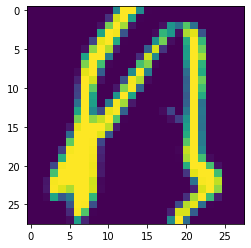

In [26]:
# let's see the image at index 0
plt.figure()
plt.imshow(train_images[0])
plt.show()

In [27]:
df_classmap

index codepoint char phonetic
0      0    U+304A    お        o
1      1    U+304D    き       ki
2      2    U+3059    す       su
3      3    U+3064    つ      tsu
4      4    U+306A    な       na
5      5    U+306F    は       ha
6      6    U+307E    ま       ma
7      7    U+3084    や       ya
8      8    U+308C    れ       re
9      9    U+3092    を       wo

In [28]:
# so we can see, using the classmap that this character 
# pronounced "re" should be type number 8
train_labels[0]

8

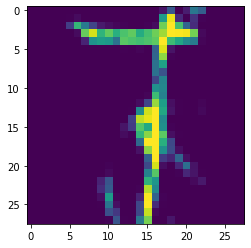

In [29]:
# we can check another one:
plt.figure()
plt.imshow(train_images[5])
plt.show()

In [30]:
# this one is 'su', so according to the classmap
# it should be type 2
train_labels[5]

2

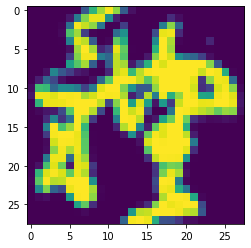

In [31]:
# next
plt.figure()
plt.imshow(train_images[7])
plt.show()

In [32]:
# I cannot visually determine which one it is
# Checking the type:
train_labels[7]

8

8
れ re


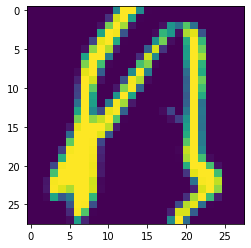

7
や ya


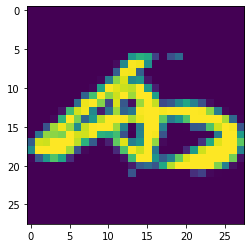

0
お o


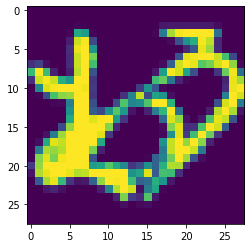

1
き ki


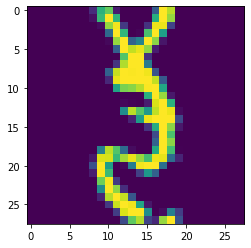

4
な na


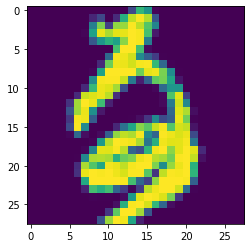

2
す su


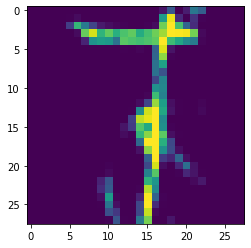

4
な na


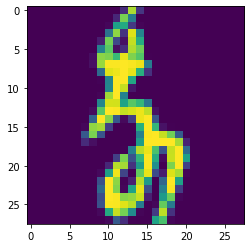

8
れ re


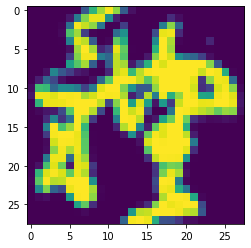

1
き ki


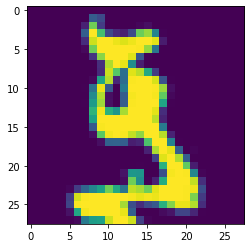

1
き ki


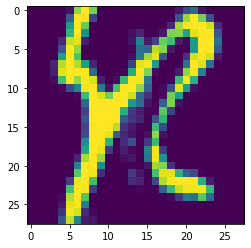

5
は ha


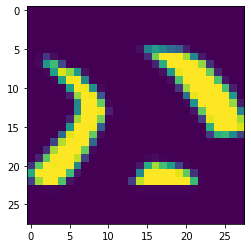

1
き ki


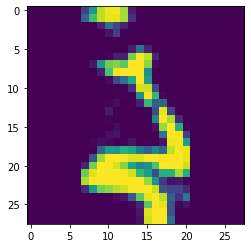

0
お o


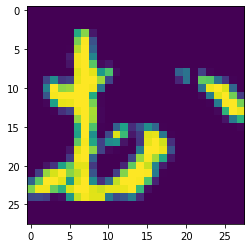

5
は ha


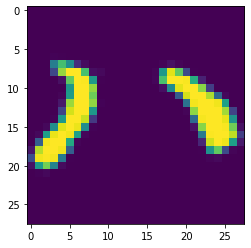

7
や ya


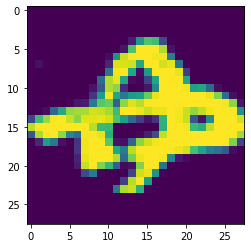

6
ま ma


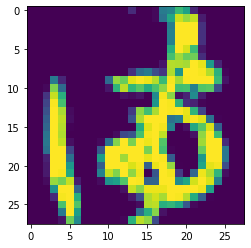

1
き ki


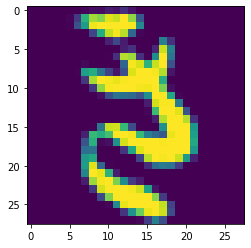

7
や ya


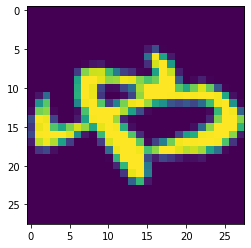

9
を wo


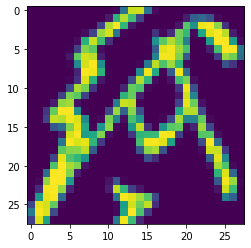

5
は ha


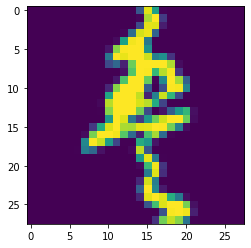

7
や ya


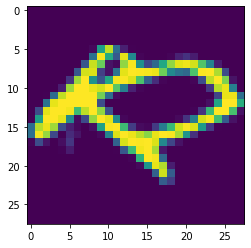

3
つ tsu


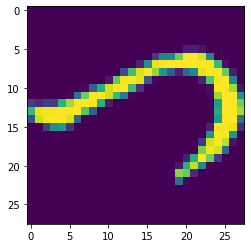

7
や ya


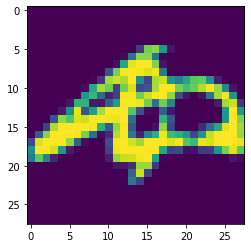

5
は ha


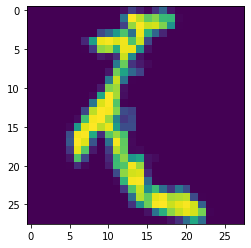

6
ま ma


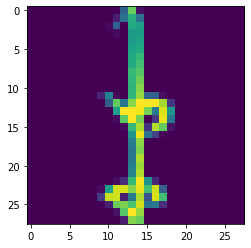

6
ま ma


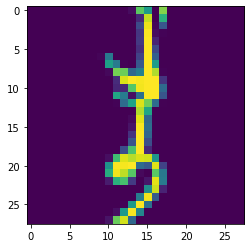

2
す su


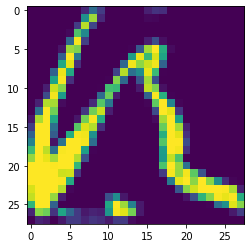

7
や ya


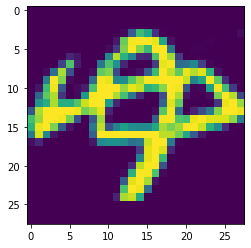

6
ま ma


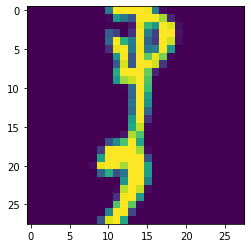

0
お o


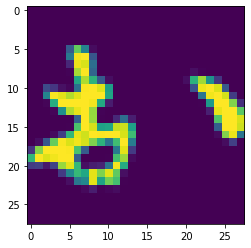

9
を wo


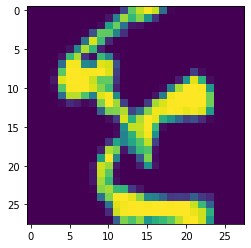

6
ま ma


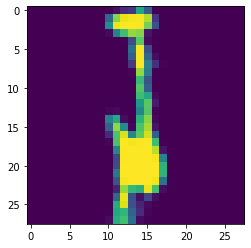

1
き ki


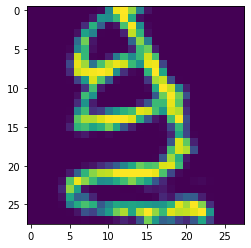

5
は ha


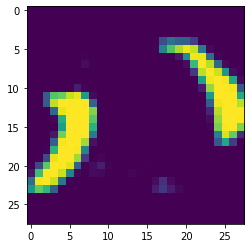

9
を wo


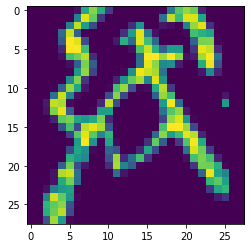

5
は ha


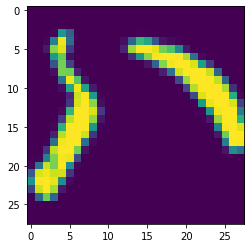

8
れ re


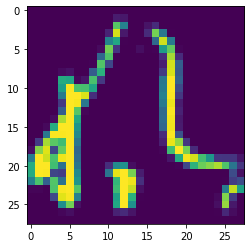

0
お o


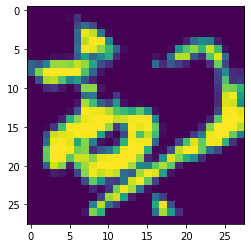

0
お o


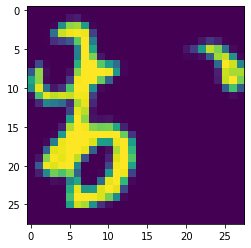

8
れ re


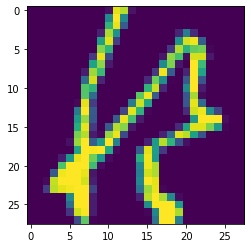

8
れ re


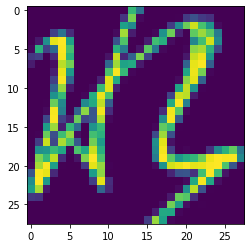

6
ま ma


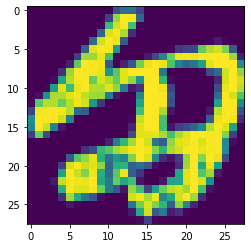

7
や ya


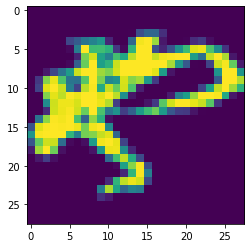

7
や ya


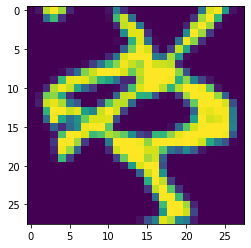

7
や ya


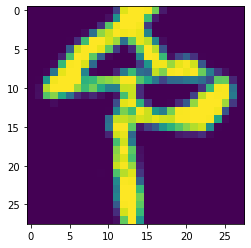

8
れ re


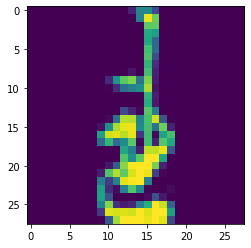

1
き ki


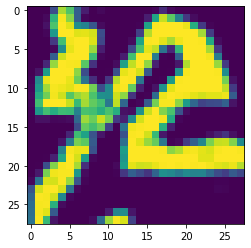

9
を wo


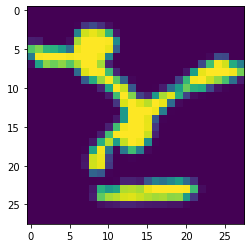

6
ま ma


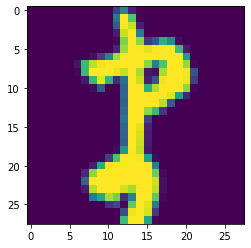

0
お o


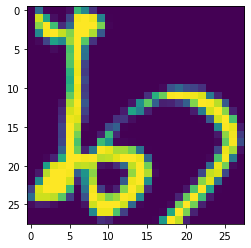

5
は ha


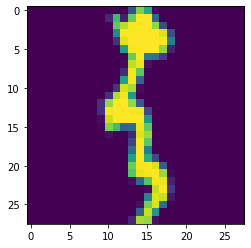

1
き ki


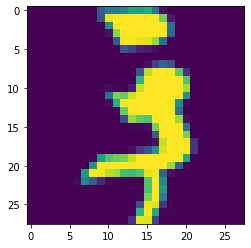

1
き ki


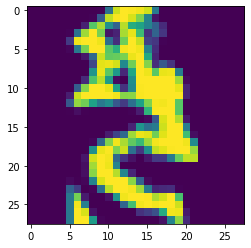

1
き ki


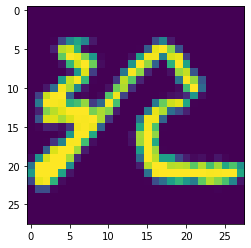

3
つ tsu


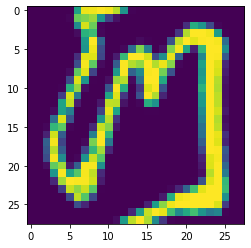

2
す su


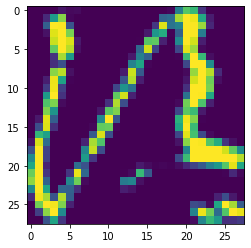

2
す su


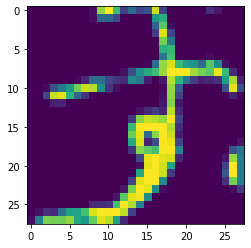

6
ま ma


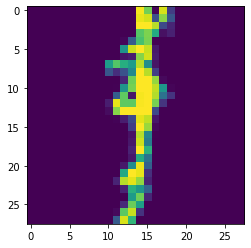

4
な na


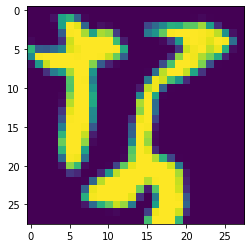

3
つ tsu


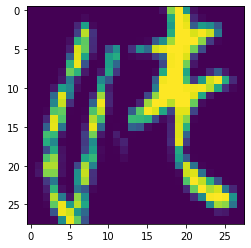

5
は ha


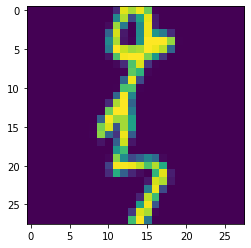

5
は ha


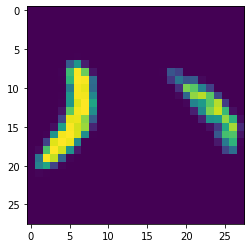

4
な na


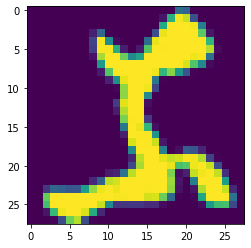

6
ま ma


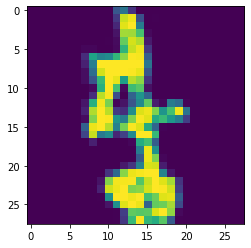

6
ま ma


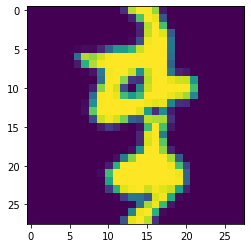

1
き ki


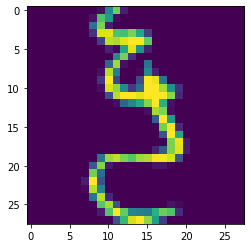

7
や ya


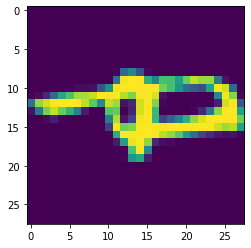

8
れ re


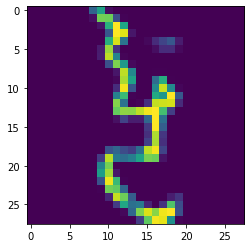

8
れ re


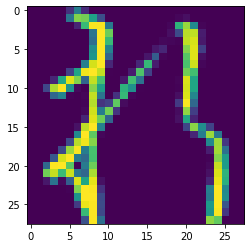

3
つ tsu


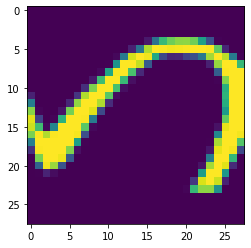

1
き ki


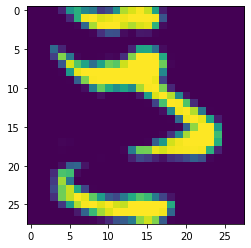

9
を wo


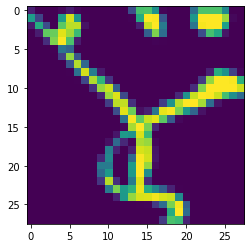

9
を wo


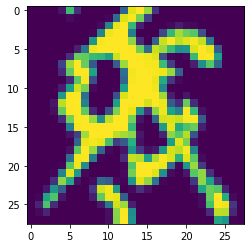

3
つ tsu


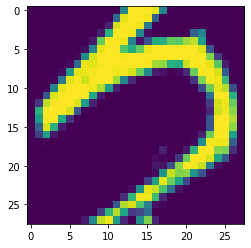

2
す su


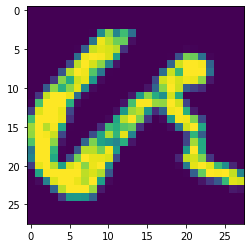

1
き ki


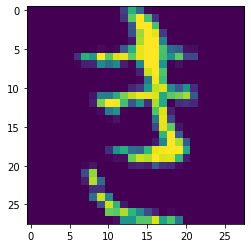

0
お o


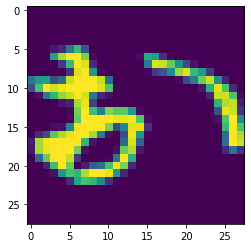

4
な na


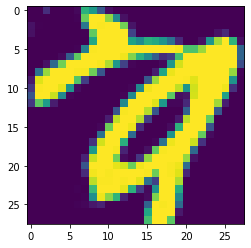

8
れ re


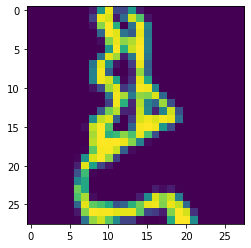

2
す su


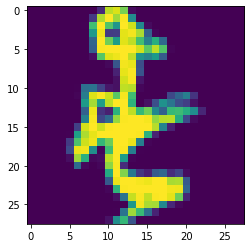

3
つ tsu


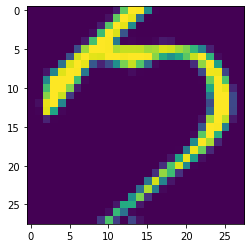

6
ま ma


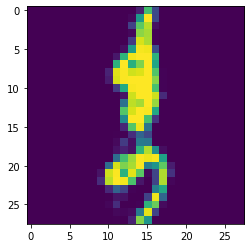

9
を wo


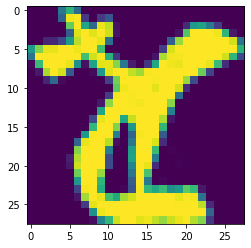

9
を wo


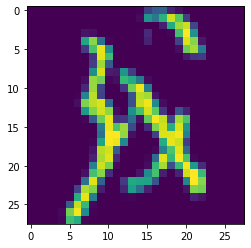

6
ま ma


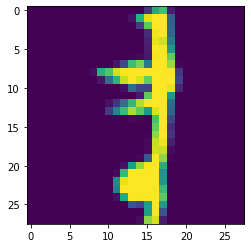

5
は ha


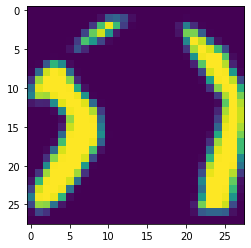

6
ま ma


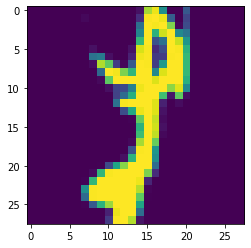

1
き ki


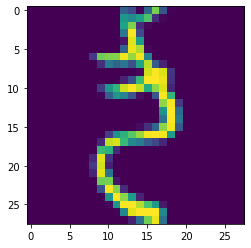

0
お o


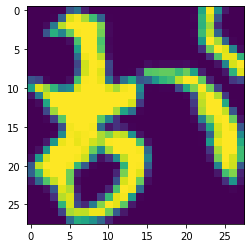

7
や ya


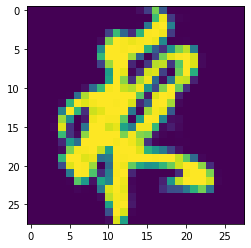

2
す su


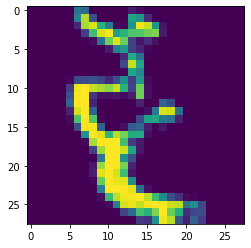

2
す su


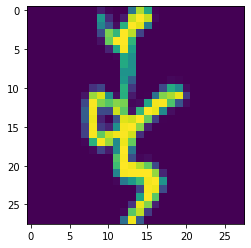

8
れ re


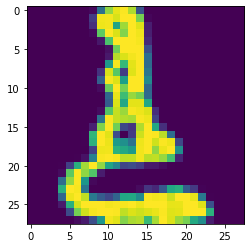

0
お o


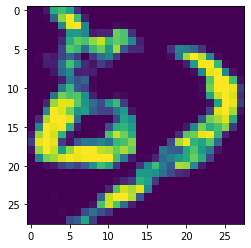

1
き ki


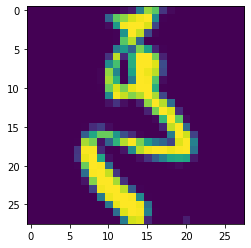

8
れ re


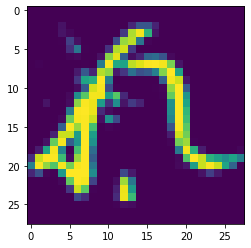

6
ま ma


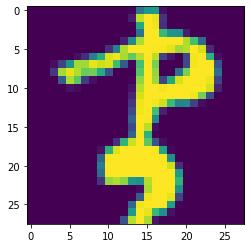

6
ま ma


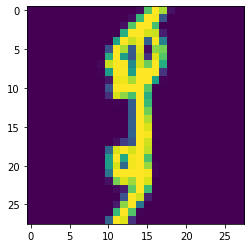

3
つ tsu


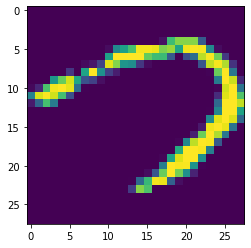

In [33]:
# next we print the class number, the written character, and the phonetic
# for index numbers 0 through 99:
for i in range(0,99):
    print(train_labels[i])
    print(df_classmap.loc[train_labels[i],'char'], df_classmap.loc[train_labels[i],'phonetic'])
    plt.figure()
    plt.imshow(train_images[i])
    plt.show()
    
    i+=1

In [34]:
# So we now we have verified this data is what we want: namely images of kuzushiji characters
# which we can view in "unflattned" format (60000, 28, 28) as images and that we can leave in "flattened" 
# format in two dimensional numpy arrays with dimensions (60000, 784) for use in the ML model

# next we convert the train_labels numpy array to a dataframe

df_train_labels = pd.DataFrame(train_labels)

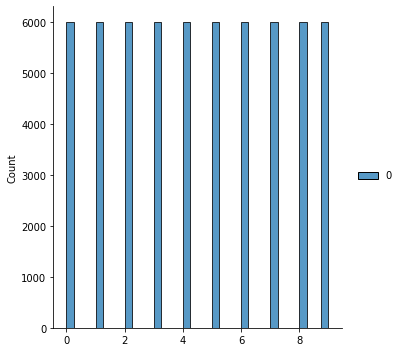

In [35]:
sns.displot(df_train_labels)

In [36]:
# so shows us this is a balanced set

In [37]:
df_train_labels[0].value_counts()

8    6000
7    6000
0    6000
1    6000
4    6000
2    6000
5    6000
6    6000
9    6000
3    6000
Name: 0, dtype: int64

In [38]:
# this confirms the set is perfectly balanced

In [39]:
# next we obtain a slightly more difficult dataset
# which includes 49 classes of kuzushiji instead of just
# 10 classes:

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz?raw=True
!mv k49-train-imgs.npz?raw=True k49-train-imgs.npz
!ls -lahr k49-train-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz?raw=True
!mv k49-train-labels.npz?raw=True k49-train-labels.npz
!ls -lahr k49-train-labels.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz?raw=True
!mv k49-test-imgs.npz?raw=True k49-test-imgs.npz
!ls -lahr k49-test-imgs.npz

!wget http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz?raw=True
!mv k49-test-labels.npz?raw=True k49-test-labels.npz
!ls -lahr k49-test-labels.npz

--2021-07-12 22:53:01--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66117696 (63M)
Saving to: ‘k49-train-imgs.npz?raw=True’

k49-train-imgs.npz? 100%[===================>]  63.05M  4.94MB/s    in 13s     

2021-07-12 22:53:14 (4.90 MB/s) - ‘k49-train-imgs.npz?raw=True’ saved [66117696/66117696]

-rw-rw-r-- 1 spark spark 64M Feb  4  2019 k49-train-imgs.npz
--2021-07-12 22:53:16--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164485 (161K)
Saving to: ‘k49-train-labels.npz?raw=True’

k49-train-labels.np 100%[===================>] 160.63K   390KB/s    

In [40]:
# define a load function and use it to load to numpy arrays

def load(f):
    return np.load(f)['arr_0']

k49_train_images = load('k49-train-imgs.npz')
k49_train_labels = load('k49-train-labels.npz')
k49_test_images = load('k49-test-imgs.npz')
k49_test_labels = load('k49-test-labels.npz')

In [41]:
# and the class map of the 49 character data set

url = "http://codh.rois.ac.jp/kmnist/dataset/k49/k49_classmap.csv"
df_k49_classmap = pd.read_csv(url)
df_k49_classmap.head(51)

index codepoint char
0       0    U+3042    あ
1       1    U+3044    い
2       2    U+3046    う
3       3    U+3048    え
4       4    U+304A    お
5       5    U+304B    か
6       6    U+304D    き
7       7    U+304F    く
8       8    U+3051    け
9       9    U+3053    こ
10     10    U+3055    さ
11     11    U+3057    し
12     12    U+3059    す
13     13    U+305B    せ
14     14    U+305D    そ
15     15    U+305F    た
16     16    U+3061    ち
17     17    U+3064    つ
18     18    U+3066    て
19     19    U+3068    と
20     20    U+306A    な
21     21    U+306B    に
22     22    U+306C    ぬ
23     23    U+306D    ね
24     24    U+306E    の
25     25    U+306F    は
26     26    U+3072    ひ
27     27    U+3075    ふ
28     28    U+3078    へ
29     29    U+307B    ほ
30     30    U+307E    ま
31     31    U+307F    み
32     32    U+3080    む
33     33    U+3081    め
34     34    U+3082    も
35     35    U+3084    や
36     36    U+3086    ゆ
37     37    U+3088    よ
38     38    U+3089    ら
39     39    U+308A    り
40     40    U+308B    る
41     41    U+308C    れ
42     42    U+308D    ろ
43     43    U+308F    わ
44     44    U+3090    ゐ
45     45    U+3091    ゑ
46     46    U+3092    を
47     47    U+3093    ん
48     48    U+309D    ゝ

In [42]:
# let's add the phonetic sound the character makes for clarity

k49_phonetic = ['a', 'i',  'u',  'e',  'o',\
                'ka','ki', 'ku', 'ke', 'ko',\
                'sa','shi','su', 'se', 'so',\
                'ta','chi','tsu','te', 'to',\
                'na','ni', 'nu', 'ne', 'no',\
                'ha','hi', 'fu', 'he', 'ho',\
                'ma','mi', 'mu', 'me', 'mo',\
                'ya','yu', 'yo',\
                'ra','ri', 'ru', 're', 'ro',\
                'wa','wi', 'we ','wo', 'n','iteration_mark']
print(len(k49_phonetic))
df_k49_classmap['phonetic'] = k49_phonetic
df_k49_classmap

49


index codepoint char        phonetic
0       0    U+3042    あ               a
1       1    U+3044    い               i
2       2    U+3046    う               u
3       3    U+3048    え               e
4       4    U+304A    お               o
5       5    U+304B    か              ka
6       6    U+304D    き              ki
7       7    U+304F    く              ku
8       8    U+3051    け              ke
9       9    U+3053    こ              ko
10     10    U+3055    さ              sa
11     11    U+3057    し             shi
12     12    U+3059    す              su
13     13    U+305B    せ              se
14     14    U+305D    そ              so
15     15    U+305F    た              ta
16     16    U+3061    ち             chi
17     17    U+3064    つ             tsu
18     18    U+3066    て              te
19     19    U+3068    と              to
20     20    U+306A    な              na
21     21    U+306B    に              ni
22     22    U+306C    ぬ              nu
23     23    U+306D    ね              ne
24     24    U+306E    の              no
25     25    U+306F    は              ha
26     26    U+3072    ひ              hi
27     27    U+3075    ふ              fu
28     28    U+3078    へ              he
29     29    U+307B    ほ              ho
30     30    U+307E    ま              ma
31     31    U+307F    み              mi
32     32    U+3080    む              mu
33     33    U+3081    め              me
34     34    U+3082    も              mo
35     35    U+3084    や              ya
36     36    U+3086    ゆ              yu
37     37    U+3088    よ              yo
38     38    U+3089    ら              ra
39     39    U+308A    り              ri
40     40    U+308B    る              ru
41     41    U+308C    れ              re
42     42    U+308D    ろ              ro
43     43    U+308F    わ              wa
44     44    U+3090    ゐ              wi
45     45    U+3091    ゑ             we 
46     46    U+3092    を              wo
47     47    U+3093    ん               n
48     48    U+309D    ゝ  iteration_mark

In [43]:
type(k49_train_images)

numpy.ndarray

In [44]:
k49_train_images.shape

(232365, 28, 28)

In [45]:
# this tells us that we have 232,365 images 
# that are each 28 x 28 pixels

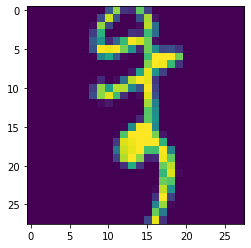

In [46]:
# let's see the image at index 0
plt.figure()
plt.imshow(k49_train_images[0])
plt.show()

In [47]:
# visually, this one look like 'ma'
# so according to the classmap
# it should be type 30
k49_train_labels[0]

30

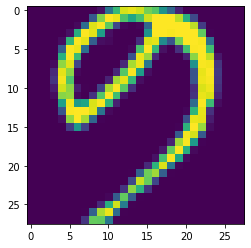

In [48]:
# let's see the image at index 11
plt.figure()
plt.imshow(k49_train_images[11])
plt.show()

In [49]:
# visually, we can see using the classmap
# that this one looks like 'no'
# so according to the classmap
# it should be type 24
k49_train_labels[11]

24

30
ま ma


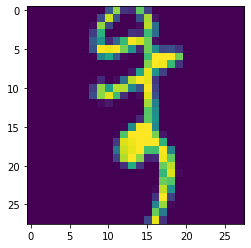

19
と to


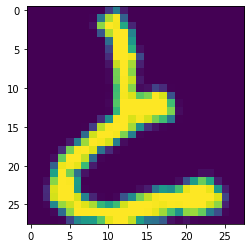

20
な na


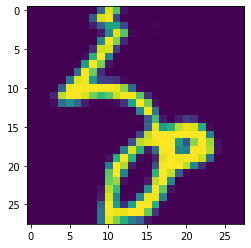

30
ま ma


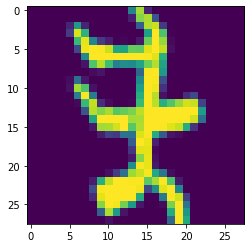

7
く ku


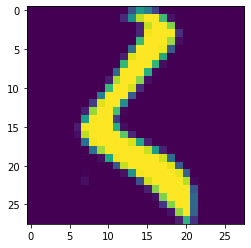

4
お o


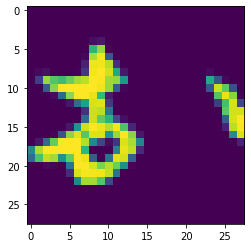

35
や ya


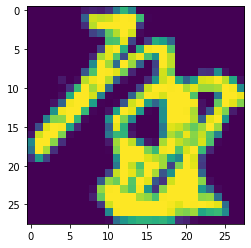

20
な na


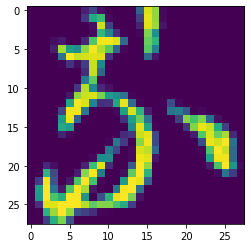

24
の no


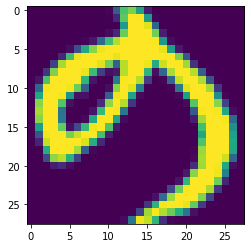

43
わ wa


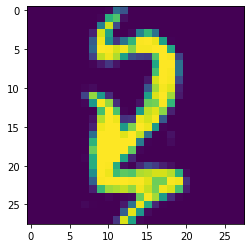

24
の no


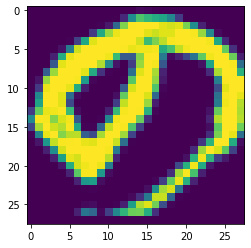

24
の no


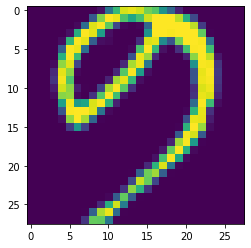

46
を wo


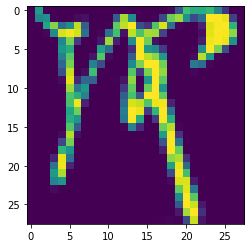

25
は ha


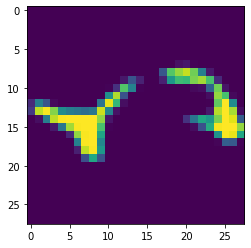

25
は ha


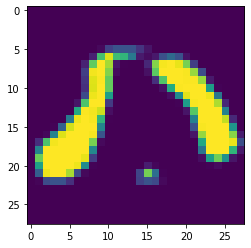

46
を wo


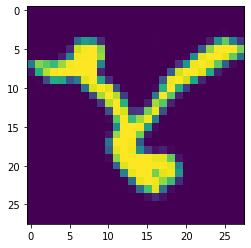

15
た ta


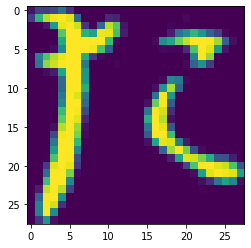

27
ふ fu


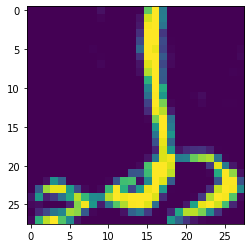

47
ん n


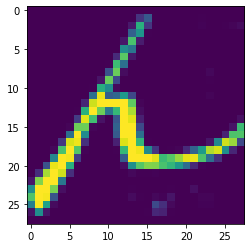

47
ん n


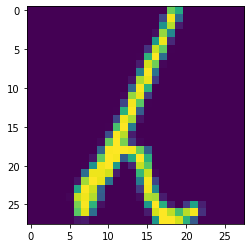

47
ん n


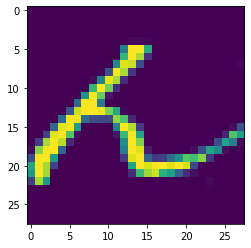

27
ふ fu


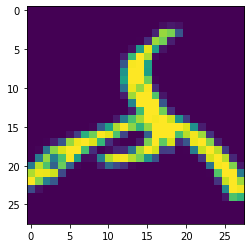

12
す su


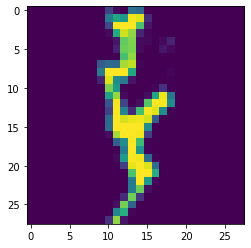

20
な na


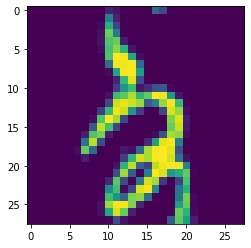

13
せ se


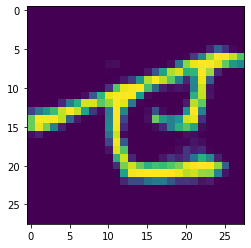

10
さ sa


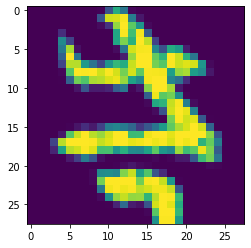

37
よ yo


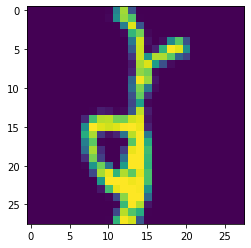

40
る ru


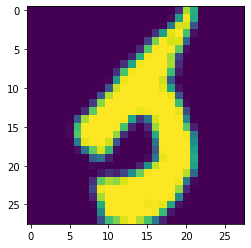

0
あ a


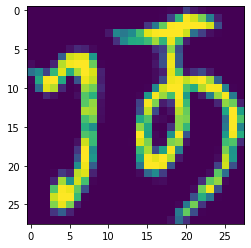

19
と to


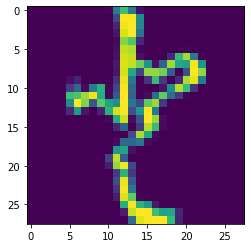

2
う u


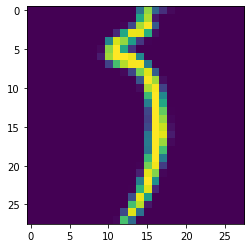

25
は ha


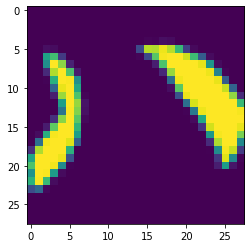

6
き ki


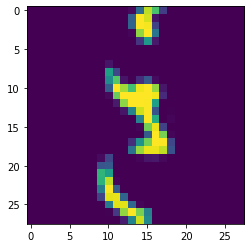

1
い i


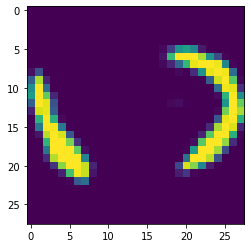

8
け ke


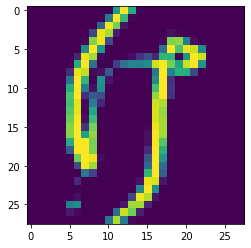

18
て te


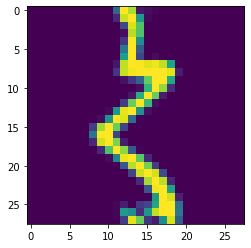

21
に ni


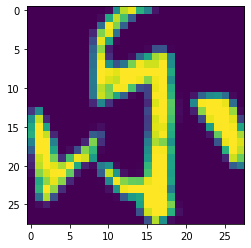

8
け ke


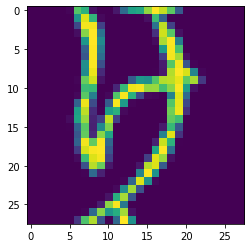

41
れ re


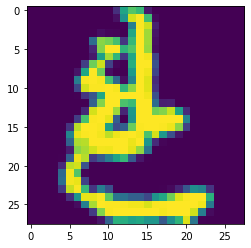

0
あ a


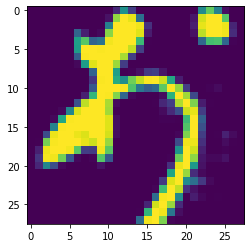

39
り ri


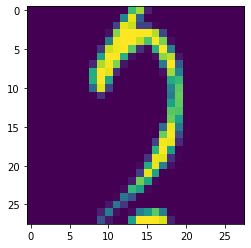

28
へ he


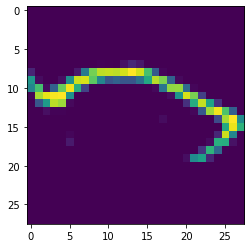

26
ひ hi


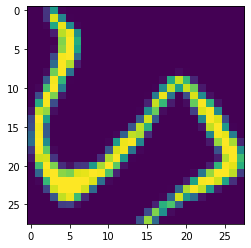

21
に ni


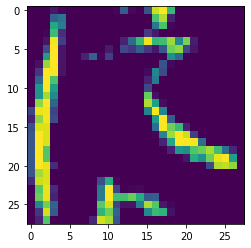

28
へ he


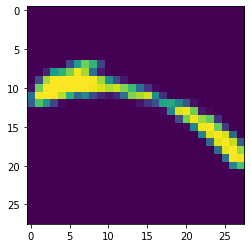

35
や ya


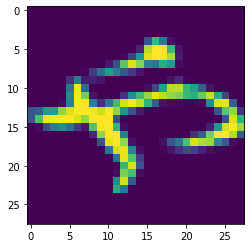

34
も mo


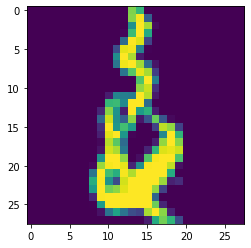

27
ふ fu


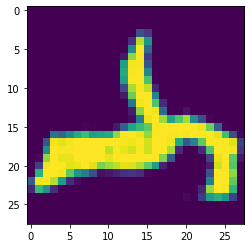

2
う u


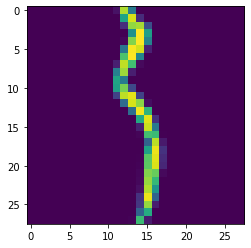

20
な na


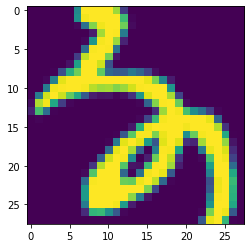

24
の no


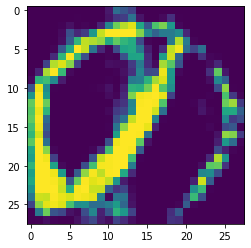

3
え e


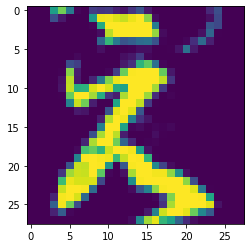

26
ひ hi


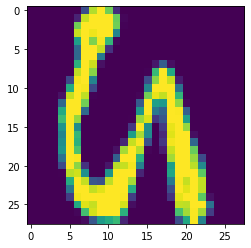

20
な na


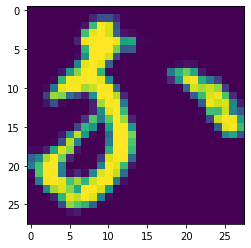

28
へ he


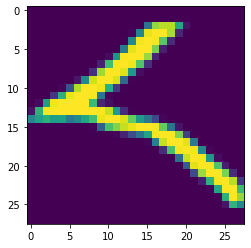

24
の no


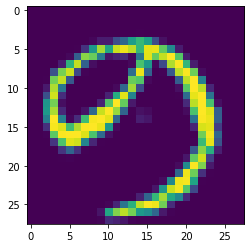

14
そ so


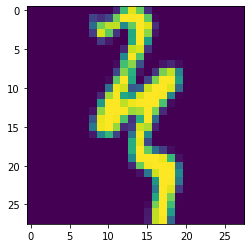

12
す su


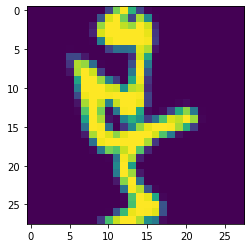

14
そ so


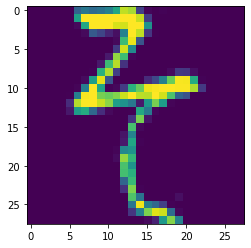

10
さ sa


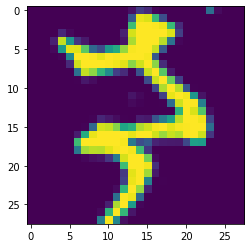

24
の no


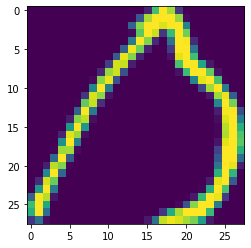

31
み mi


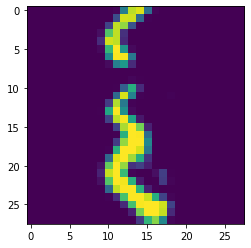

21
に ni


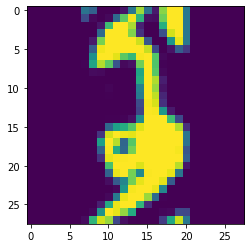

38
ら ra


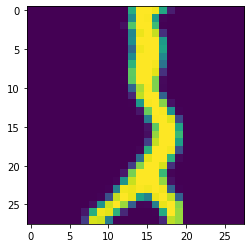

27
ふ fu


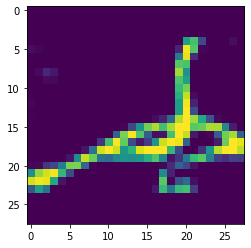

20
な na


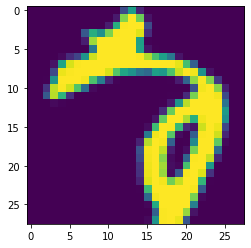

30
ま ma


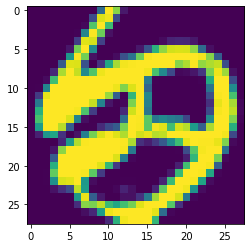

25
は ha


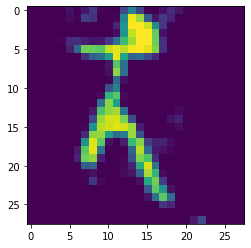

0
あ a


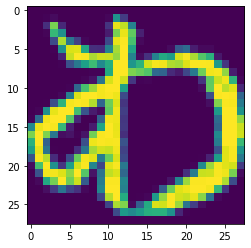

5
か ka


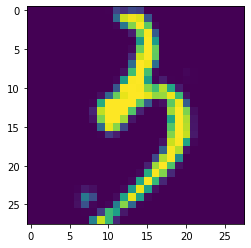

44
ゐ wi


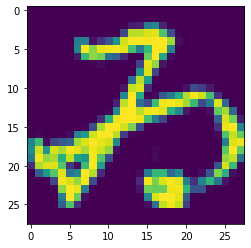

18
て te


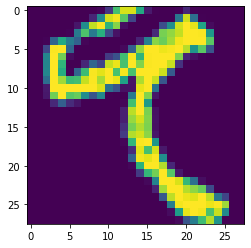

47
ん n


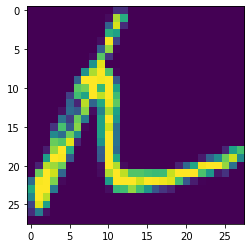

46
を wo


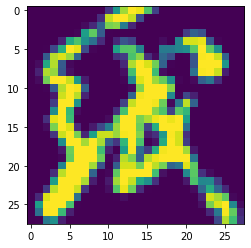

42
ろ ro


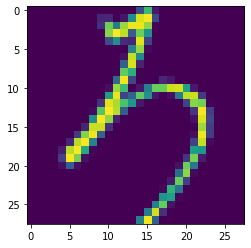

4
お o


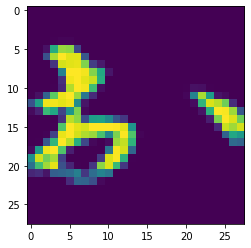

21
に ni


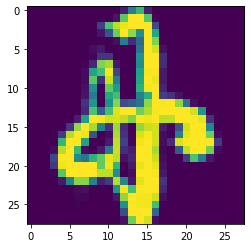

41
れ re


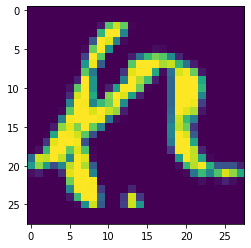

30
ま ma


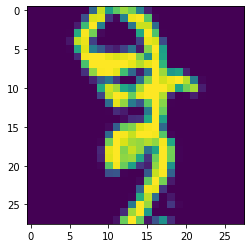

39
り ri


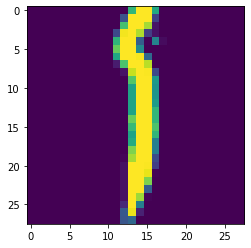

40
る ru


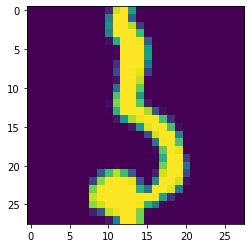

47
ん n


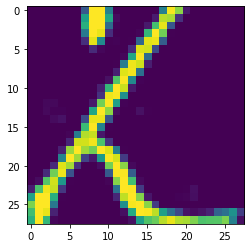

39
り ri


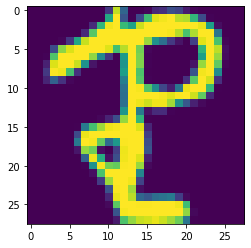

16
ち chi


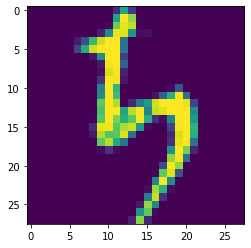

27
ふ fu


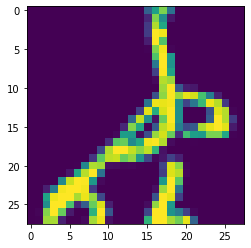

15
た ta


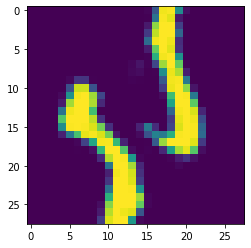

1
い i


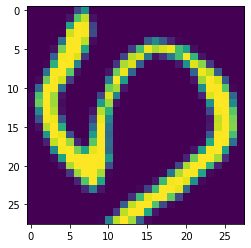

36
ゆ yu


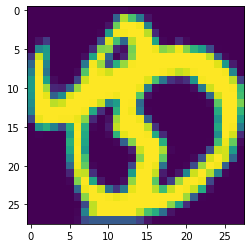

46
を wo


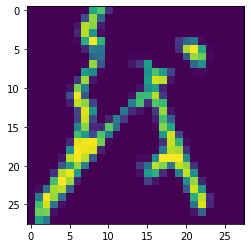

34
も mo


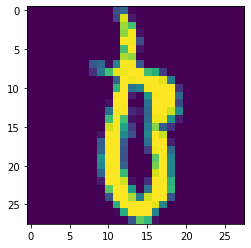

31
み mi


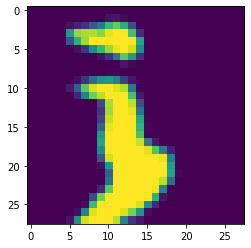

47
ん n


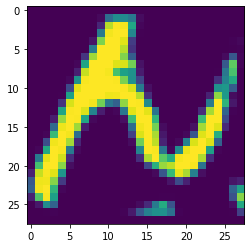

7
く ku


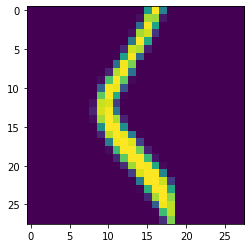

1
い i


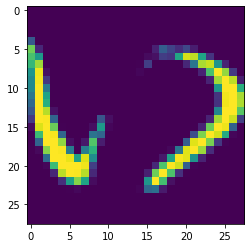

43
わ wa


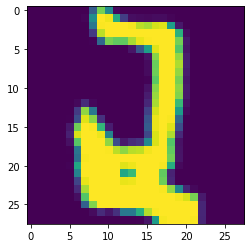

38
ら ra


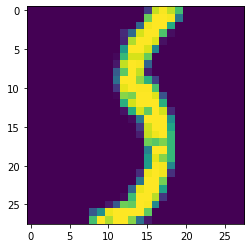

22
ぬ nu


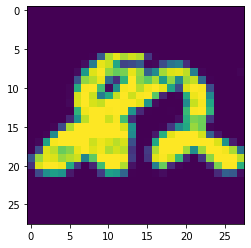

39
り ri


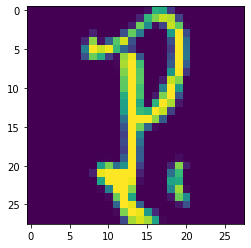

40
る ru


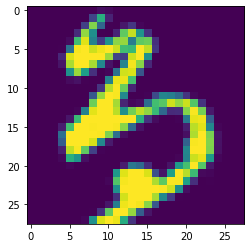

14
そ so


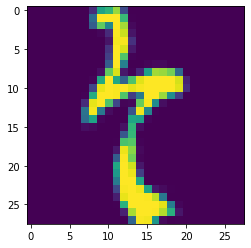

18
て te


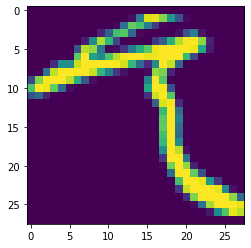

2
う u


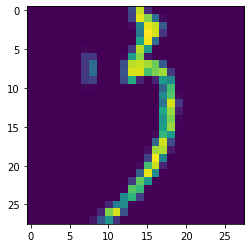

5
か ka


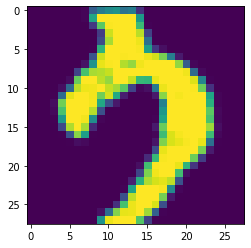

8
け ke


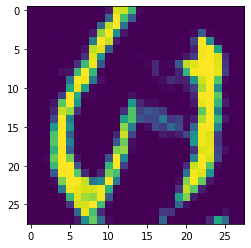

24
の no


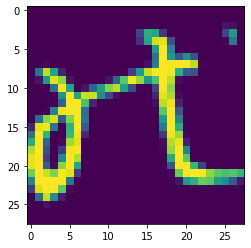

25
は ha


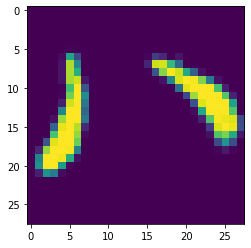

48
ゝ iteration_mark


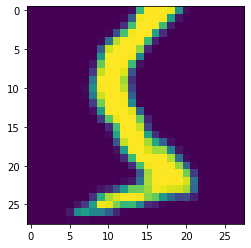

20
な na


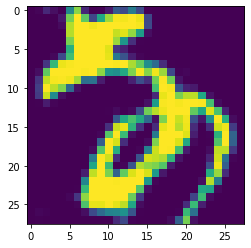

30
ま ma


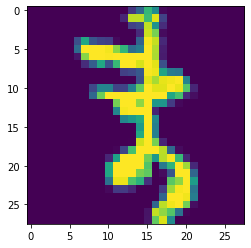

20
な na


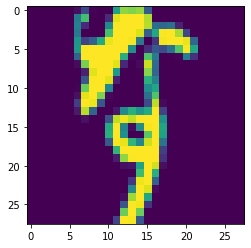

15
た ta


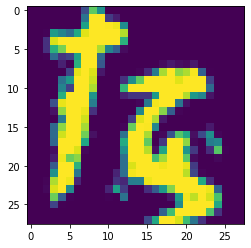

14
そ so


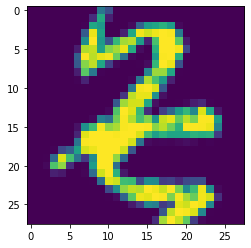

20
な na


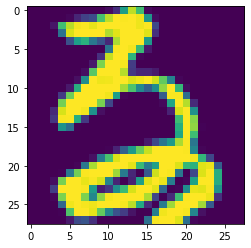

1
い i


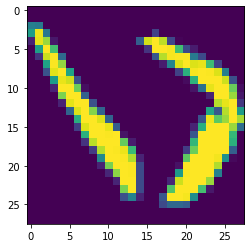

40
る ru


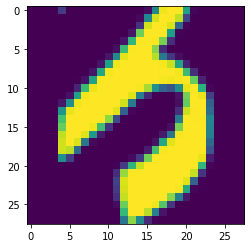

6
き ki


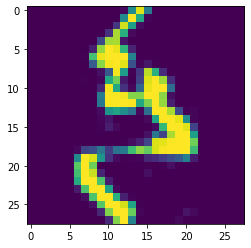

15
た ta


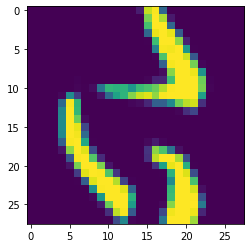

10
さ sa


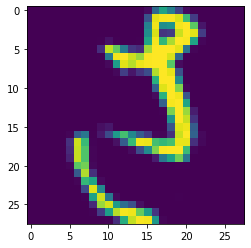

37
よ yo


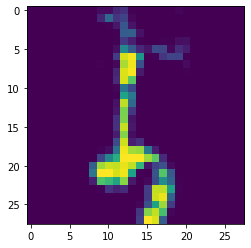

33
め me


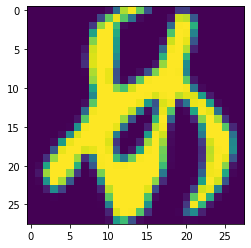

17
つ tsu


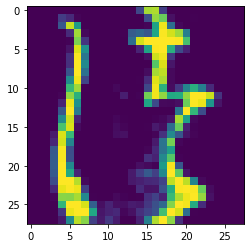

26
ひ hi


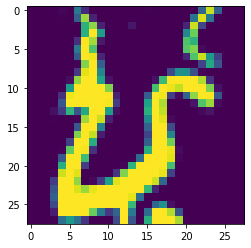

1
い i


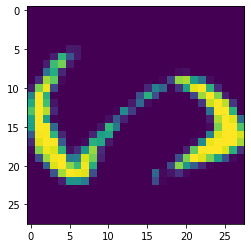

2
う u


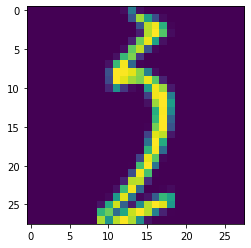

2
う u


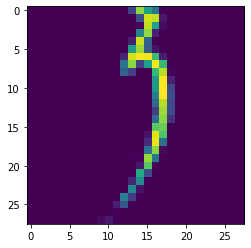

24
の no


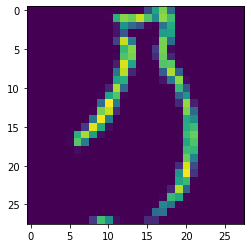

27
ふ fu


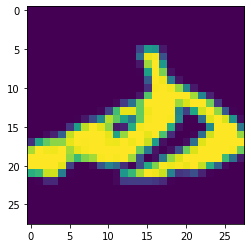

18
て te


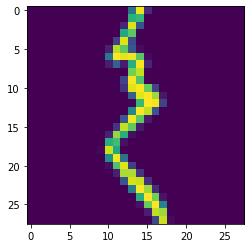

30
ま ma


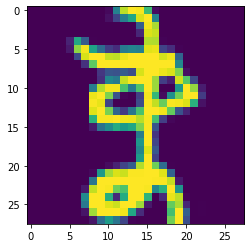

12
す su


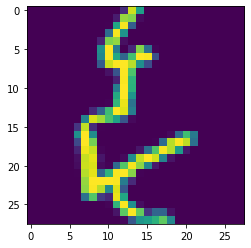

45
ゑ we 


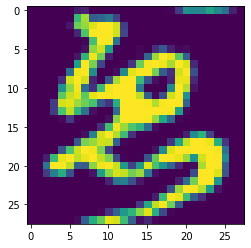

9
こ ko


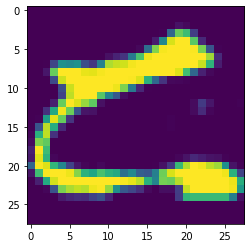

28
へ he


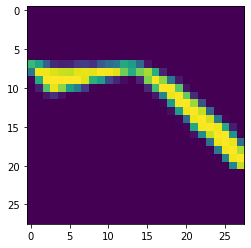

41
れ re


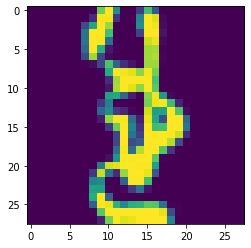

44
ゐ wi


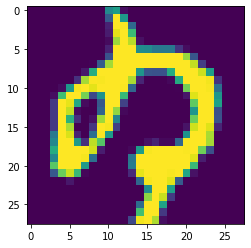

28
へ he


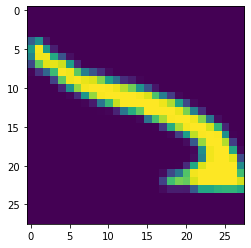

6
き ki


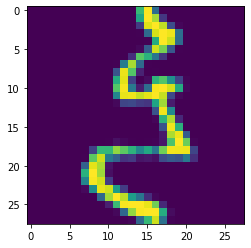

25
は ha


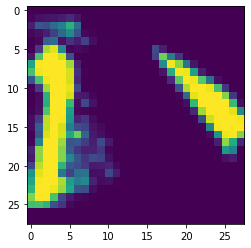

38
ら ra


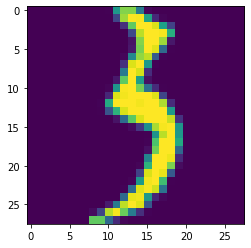

46
を wo


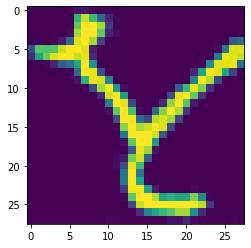

20
な na


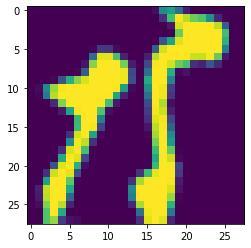

24
の no


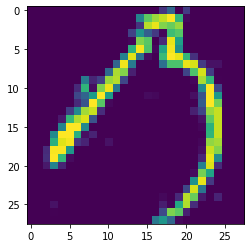

11
し shi


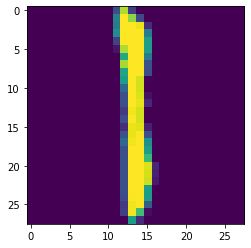

40
る ru


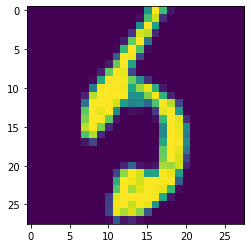

18
て te


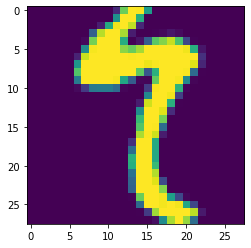

25
は ha


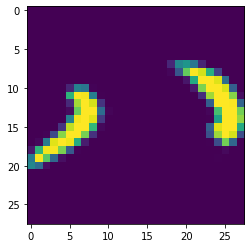

34
も mo


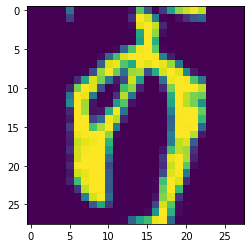

26
ひ hi


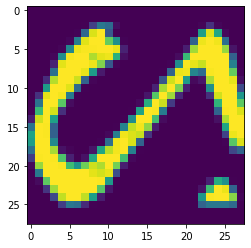

9
こ ko


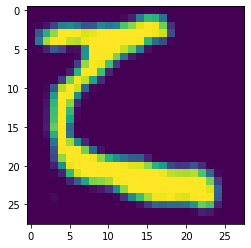

25
は ha


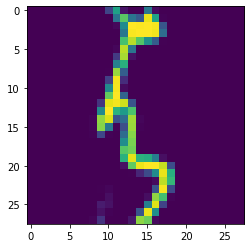

21
に ni


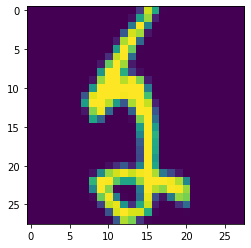

10
さ sa


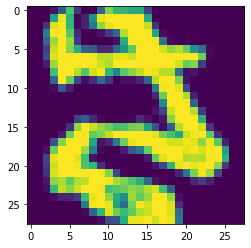

37
よ yo


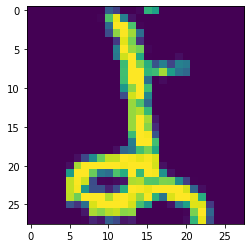

43
わ wa


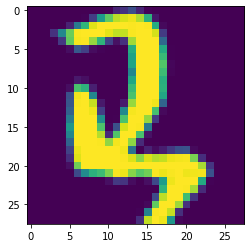

1
い i


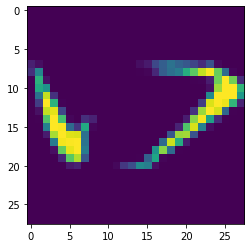

20
な na


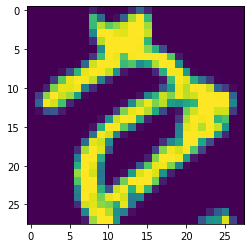

30
ま ma


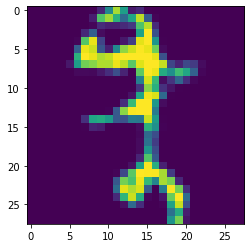

38
ら ra


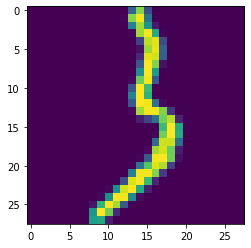

13
せ se


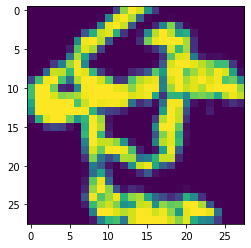

12
す su


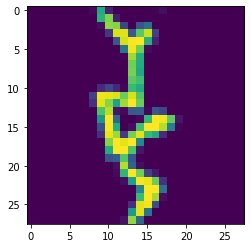

10
さ sa


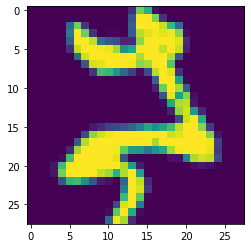

41
れ re


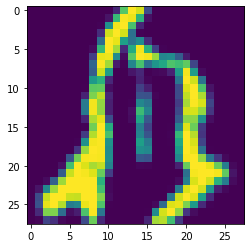

41
れ re


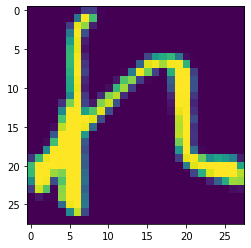

42
ろ ro


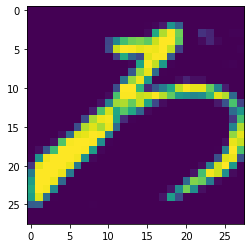

30
ま ma


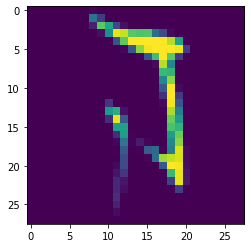

19
と to


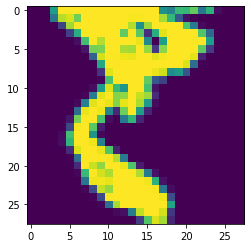

7
く ku


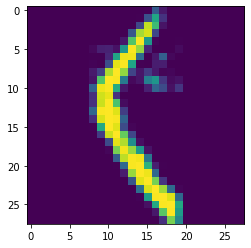

40
る ru


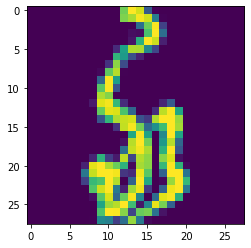

47
ん n


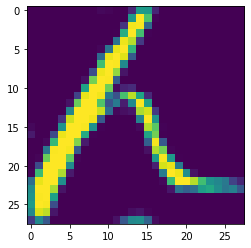

23
ね ne


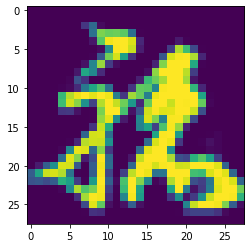

5
か ka


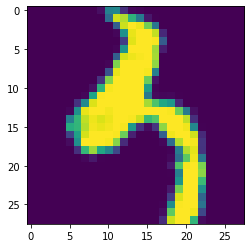

2
う u


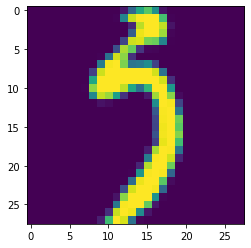

48
ゝ iteration_mark


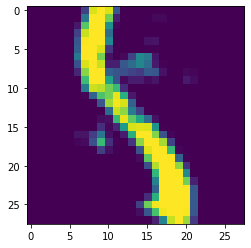

6
き ki


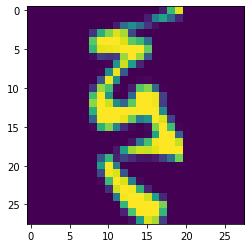

6
き ki


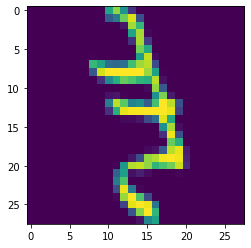

28
へ he


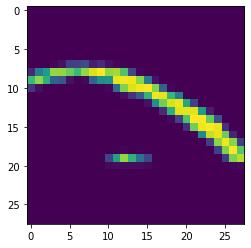

34
も mo


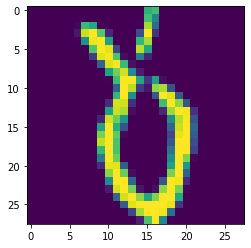

37
よ yo


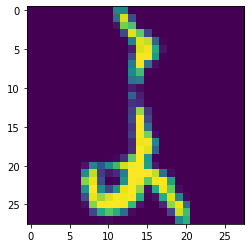

14
そ so


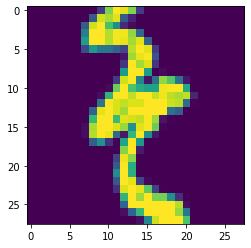

4
お o


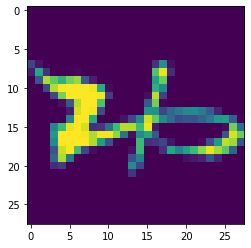

6
き ki


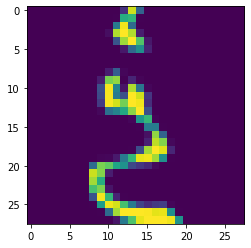

17
つ tsu


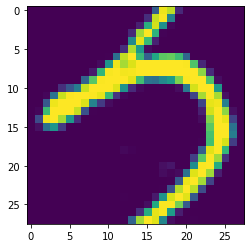

37
よ yo


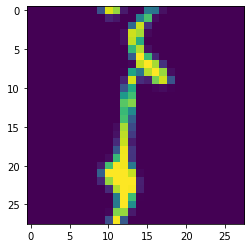

16
ち chi


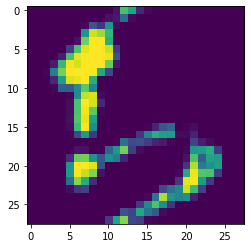

41
れ re


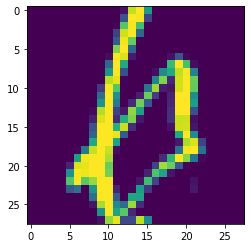

11
し shi


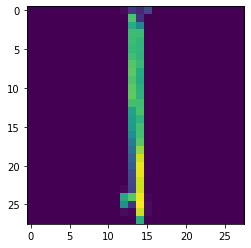

7
く ku


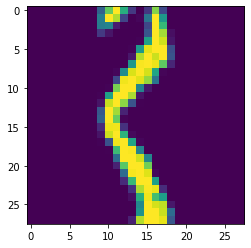

18
て te


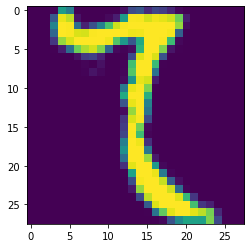

25
は ha


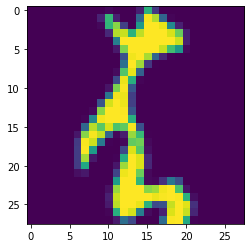

9
こ ko


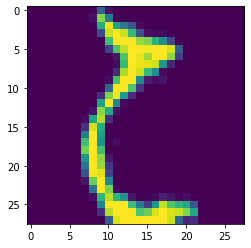

29
ほ ho


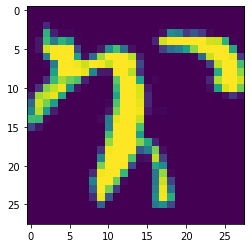

29
ほ ho


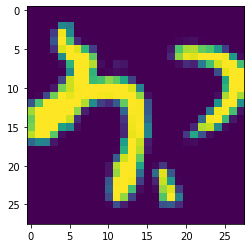

41
れ re


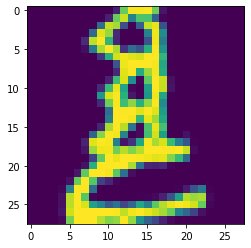

37
よ yo


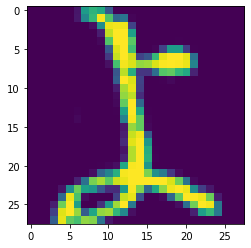

11
し shi


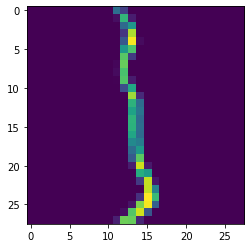

4
お o


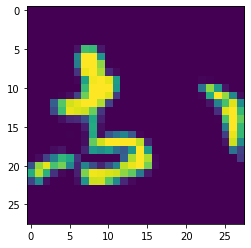

41
れ re


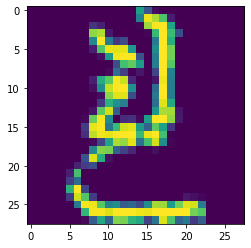

22
ぬ nu


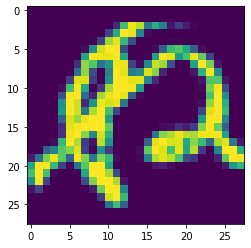

34
も mo


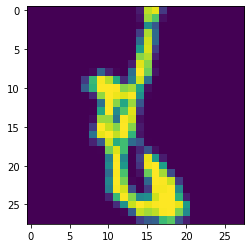

In [50]:
# next we print the class number, the written character, and the phonetic
# for index numbers 0 through 199:
for i in range(0,199):
    print(k49_train_labels[i])
    print(df_k49_classmap.loc[k49_train_labels[i],'char'], df_k49_classmap.loc[k49_train_labels[i],'phonetic'])
    plt.figure()
    plt.imshow(k49_train_images[i])
    plt.show()
    
    i+=1

In [51]:
# For the 2nd dataset with 49 classes
# we now we have verified visually that data is what we want:
# images of 49 different kuzushiji characters

# next we convert k49_train_labels numpy array to a dataframe
# in order to inspect the dataset further:

df_k49_train_labels = pd.DataFrame(k49_train_labels)

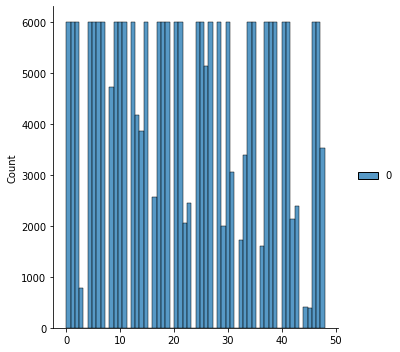

In [52]:
# lets see how the character data is distributed among the 49 classes:
sns.displot(df_k49_train_labels)

In [53]:
df_k49_train_labels[0].value_counts().sort_index()

0     6000
1     6000
2     6000
3      777
4     6000
5     6000
6     6000
7     6000
8     4714
9     6000
10    6000
11    6000
12    6000
13    4165
14    3867
15    6000
16    2565
17    6000
18    6000
19    6000
20    6000
21    6000
22    2063
23    2451
24    6000
25    6000
26    5132
27    6000
28    6000
29    1993
30    6000
31    3060
32    1718
33    3394
34    6000
35    6000
36    1598
37    6000
38    6000
39    6000
40    6000
41    6000
42    2139
43    2397
44     417
45     392
46    6000
47    6000
48    3523
Name: 0, dtype: int64

In [54]:
# so we confirm that many of the classes do not have 6,000 in the second data 
# set so the data set is not balanced

In [55]:
# the final dataset includes Kanji characters
# this data has 3832 different classes and
# consists of 140,426 images

# this dataset is not as processed as the other two:
# it is just a bunch of png images in a directory
# inside an archive file

# we download the archive:

!wget http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar?raw=True
!mv kkanji.tar?raw=True kkanji.tar
!ls -lahr kkanji.tar

--2021-07-12 22:53:54--  http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar?raw=True
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324290560 (309M) [application/x-tar]
Saving to: ‘kkanji.tar?raw=True’

kkanji.tar?raw=True 100%[===================>] 309.27M  2.90MB/s    in 81s     

2021-07-12 22:55:16 (3.80 MB/s) - ‘kkanji.tar?raw=True’ saved [324290560/324290560]

-rw-rw-r-- 1 spark spark 310M Dec  8  2018 kkanji.tar


In [56]:
# next, unarchive and set up the numpy arrays
# for the third (kanji) dataset

# first we'll set up the classmap for the 
# kanji dataset

In [57]:
# list the contents of the archive
# limit output to the first 70 files

!tar -tf kkanji.tar | head -70

kkanji2/
kkanji2/U+5B87/
kkanji2/U+5B87/72d56fcb33d10fe0.png
kkanji2/U+5B87/75f7923797777c74.png
kkanji2/U+5B87/69d6becd4f8f2d61.png
kkanji2/U+5B87/522dd01c5f9573f5.png
kkanji2/U+5B87/36aadd8d92c64049.png
kkanji2/U+5B87/58f75629e53b9e63.png
kkanji2/U+5B87/557950fbb39b019b.png
kkanji2/U+5B87/c4ca643dbc0299b6.png
kkanji2/U+5B87/02f161e7e7a3c364.png
kkanji2/U+5B87/c45553bb4a35c8d4.png
kkanji2/U+5B87/ffa955bd6cb43af8.png
kkanji2/U+5B87/d0387f14448f2a95.png
kkanji2/U+5B87/d8c4a0dbd99fc02f.png
kkanji2/U+5B87/419beef7f2c593da.png
kkanji2/U+5B87/f2308287339f973d.png
kkanji2/U+5B87/f885e3a957b99e8e.png
kkanji2/U+5B87/f5e7a417e3d831d8.png
kkanji2/U+5B87/17681a9b66db23e0.png
kkanji2/U+5B87/cc2b8cd01c984262.png
kkanji2/U+5B87/3e76b512ef42c8f2.png
kkanji2/U+5B87/49276561d0ca08e0.png
kkanji2/U+5B87/a169cf27462e020d.png
kkanji2/U+5B87/61b85600b3fdbea9.png
kkanji2/U+5B87/112b17b885fbfa61.png
kkanji2/U+5B87/99654e0e2e597032.png
kkanji2/U+5B87/7af7faf202121801.png
kkanji2/U+5B87/8a6b7ea64d025e6d.png
kka

In [58]:
# remove the directory of images, so it an be rebuilt
!rm -rf kkanji2

In [59]:
# checking whats in the current working directory:

!ls -al

total 447688
drwxr-xr-x 11 spark  2000      4096 Jul 12 22:55 .
drwxrwxr-x  1 spark spark      4096 Jul 12 22:48 ..
drwxrwxr-x  4 spark spark      4096 Jul 12 22:52 .cache
drwxrwxr-x  3 spark spark      4096 Jul 12 22:48 conda
drwxrwxr-x  3 spark spark      4096 Jul 12 22:52 .config
drwxr-xr-x  5 spark spark      4096 Jul 12 22:48 .ipython
-rw-rw-r--  1 spark spark  10971201 Feb  4  2019 k49-test-imgs.npz
-rw-rw-r--  1 spark spark     27450 Feb  4  2019 k49-test-labels.npz
-rw-rw-r--  1 spark spark  66117696 Feb  4  2019 k49-train-imgs.npz
-rw-rw-r--  1 spark spark    164485 Feb  4  2019 k49-train-labels.npz
drwxrwxr-x  2 spark spark      4096 Jul 12 22:52 .keras
-rw-rw-r--  1 spark spark 324290560 Dec  8  2018 kkanji.tar
drwxrwxr-x  2 spark spark      4096 Jul 12 22:52 kmnistdata
drwxrwxr-x  2 spark spark      4096 Jul 12 22:48 logs
drwxrwxr-x  2 spark spark      4096 Jul 12 22:48 spark-events
-rw-rw-r--  1 spark spark   7840016 Feb  4  2019 t10k-images-idx3-ubyte
-rw-rw-r--  1 spark 

In [60]:
# so the format of the data is that the individual images exist
# in folders whose names are the codepoint for the image category
# these folder names will be the basis for the class Index for each image

# next lets extract:

!tar -xf kkanji.tar

In [61]:
# checking whats in the current working directory:

!ls -al

total 447984
drwxr-xr-x   12 spark  2000      4096 Jul 12 22:55 .
drwxrwxr-x    1 spark spark      4096 Jul 12 22:48 ..
drwxrwxr-x    4 spark spark      4096 Jul 12 22:52 .cache
drwxrwxr-x    3 spark spark      4096 Jul 12 22:48 conda
drwxrwxr-x    3 spark spark      4096 Jul 12 22:52 .config
drwxr-xr-x    5 spark spark      4096 Jul 12 22:48 .ipython
-rw-rw-r--    1 spark spark  10971201 Feb  4  2019 k49-test-imgs.npz
-rw-rw-r--    1 spark spark     27450 Feb  4  2019 k49-test-labels.npz
-rw-rw-r--    1 spark spark  66117696 Feb  4  2019 k49-train-imgs.npz
-rw-rw-r--    1 spark spark    164485 Feb  4  2019 k49-train-labels.npz
drwxrwxr-x    2 spark spark      4096 Jul 12 22:52 .keras
drwxr-xr-x 3834 spark spark    299008 Dec  8  2018 kkanji2
-rw-rw-r--    1 spark spark 324290560 Dec  8  2018 kkanji.tar
drwxrwxr-x    2 spark spark      4096 Jul 12 22:52 kmnistdata
drwxrwxr-x    2 spark spark      4096 Jul 12 22:48 logs
drwxrwxr-x    2 spark spark      4096 Jul 12 22:48 spark-events
-rw

In [62]:
# now list out the first 50 folder names in the directory kkanji2
# the folder names are also the codepoint of each of the characters:

!ls kkanji2 | head -50

U+241C6
U+24FA3
U+25DA1
U+27752
U+29780
U+29DDA
U+29E75
U+4093
U+4453
U+4543
U+4572
U+4C61
U+4C99
U+4E00
U+4E01
U+4E03
U+4E07
U+4E08
U+4E09
U+4E0A
U+4E0B
U+4E0D
U+4E0E
U+4E11
U+4E14
U+4E16
U+4E17
U+4E18
U+4E19
U+4E1E
U+4E21
U+4E26
U+4E2D
U+4E32
U+4E38
U+4E39
U+4E3B
U+4E3C
U+4E42
U+4E43
U+4E45
U+4E4B
U+4E4D
U+4E4E
U+4E4F
U+4E57
U+4E58
U+4E59
U+4E5D
U+4E5E
ls: write error: Broken pipe


In [63]:
# put the codepoints in a file
# let the first line of the file be name
# of the column in the dataframe we are creating
!echo codepoint > codepoints.csv
!ls kkanji2 >> codepoints.csv
!cat codepoints.csv | head -50

codepoint
U+241C6
U+24FA3
U+25DA1
U+27752
U+29780
U+29DDA
U+29E75
U+4093
U+4453
U+4543
U+4572
U+4C61
U+4C99
U+4E00
U+4E01
U+4E03
U+4E07
U+4E08
U+4E09
U+4E0A
U+4E0B
U+4E0D
U+4E0E
U+4E11
U+4E14
U+4E16
U+4E17
U+4E18
U+4E19
U+4E1E
U+4E21
U+4E26
U+4E2D
U+4E32
U+4E38
U+4E39
U+4E3B
U+4E3C
U+4E42
U+4E43
U+4E45
U+4E4B
U+4E4D
U+4E4E
U+4E4F
U+4E57
U+4E58
U+4E59
U+4E5D


In [64]:
!ls -al

total 448016
drwxr-xr-x   12 spark  2000      4096 Jul 12 23:00 .
drwxrwxr-x    1 spark spark      4096 Jul 12 22:48 ..
drwxrwxr-x    4 spark spark      4096 Jul 12 22:52 .cache
-rw-rw-r--    1 spark spark     26841 Jul 12 23:00 codepoints.csv
drwxrwxr-x    3 spark spark      4096 Jul 12 22:48 conda
drwxrwxr-x    3 spark spark      4096 Jul 12 22:52 .config
drwxr-xr-x    5 spark spark      4096 Jul 12 22:48 .ipython
-rw-rw-r--    1 spark spark  10971201 Feb  4  2019 k49-test-imgs.npz
-rw-rw-r--    1 spark spark     27450 Feb  4  2019 k49-test-labels.npz
-rw-rw-r--    1 spark spark  66117696 Feb  4  2019 k49-train-imgs.npz
-rw-rw-r--    1 spark spark    164485 Feb  4  2019 k49-train-labels.npz
drwxrwxr-x    2 spark spark      4096 Jul 12 22:52 .keras
drwxr-xr-x 3834 spark spark    299008 Dec  8  2018 kkanji2
-rw-rw-r--    1 spark spark 324290560 Dec  8  2018 kkanji.tar
drwxrwxr-x    2 spark spark      4096 Jul 12 22:52 kmnistdata
drwxrwxr-x    2 spark spark      4096 Jul 12 22:48 logs
d

In [65]:
print (os.path.abspath("codepoints.csv"))

/home/spark/shared/codepoints.csv


In [66]:
# read all the lines of the file into pandas dataframe
# including the column header which is already in the file

df_kanji_classmap = pd.read_csv("codepoints.csv")

In [67]:
df_kanji_classmap

codepoint
0      U+241C6
1      U+24FA3
2      U+25DA1
3      U+27752
4      U+29780
...        ...
3827    U+FA38
3828    U+FA45
3829    U+FA4A
3830    U+FA55
3831    U+FA5C

[3832 rows x 1 columns]

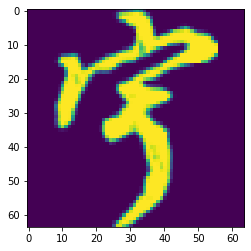

In [68]:
#read the first listed image in the first folder and display it
img = mping.imread('kkanji2/U+5B87/72d56fcb33d10fe0.png')
plt.imshow(img)
plt.show()

In [69]:
# verify the full path for the folder containing the images
path_var = str(os.path.abspath("kkanji2/"))
path_var

'/home/spark/shared/kkanji2'

In [70]:
# create a pandas dataframe that contains the codepoint for each image, 
# and its full path in the os and display that dataframe

data = []
dir = os.path.realpath(path_var)
for r, d, f in os.walk(dir):
    for file in f:
        if ".png" in file:
            data.append((r.split('/')[-1],os.path.join(r,file)))
df_kanji2 = pd.DataFrame(data, columns=['codepoint', 'image_file_path']).sort_values(by=['codepoint'], ignore_index = True)
df_kanji2

codepoint                                    image_file_path
0        U+241C6  /home/spark/shared/kkanji2/U+241C6/c0d603c6ce4...
1        U+241C6  /home/spark/shared/kkanji2/U+241C6/689fa55040e...
2        U+24FA3  /home/spark/shared/kkanji2/U+24FA3/4190e728bfc...
3        U+24FA3  /home/spark/shared/kkanji2/U+24FA3/80582798ed7...
4        U+25DA1  /home/spark/shared/kkanji2/U+25DA1/512d7fcacdd...
...          ...                                                ...
140419    U+FA55  /home/spark/shared/kkanji2/U+FA55/f03dee341d01...
140420    U+FA55  /home/spark/shared/kkanji2/U+FA55/9bb329908332...
140421    U+FA55  /home/spark/shared/kkanji2/U+FA55/9158bbb254b2...
140422    U+FA5C  /home/spark/shared/kkanji2/U+FA5C/15e2060396eb...
140423    U+FA5C  /home/spark/shared/kkanji2/U+FA5C/679e4b2f026f...

[140424 rows x 2 columns]

In [71]:
# show the os path of the first image
df_kanji2['image_file_path'][0]

'/home/spark/shared/kkanji2/U+241C6/c0d603c6ce4a4538.png'

In [72]:
# read the image using Pillow
pimage = Image.open(df_kanji2['image_file_path'][0])

In [73]:
# show some information about the image:
print(pimage.format)

PNG


In [74]:
print(pimage.size)

(64, 64)


In [75]:
print(pimage.mode)

L


In [76]:
# it is important to know that the image is 64 x 64 pixels, unlike the first two datasets

In [77]:
# next read the image using matplotlib

In [78]:
img = image.imread(df_kanji2['image_file_path'][0])

In [79]:
print(img.dtype)

float32


In [80]:
print(img.shape)

(64, 64)


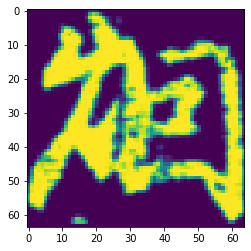

In [81]:
plt.imshow(img)

In [82]:
# next we want to try to convert this image into a numpy array

In [83]:
image_nparray = asarray(img)

In [84]:
# verify we have created a numpy array
print(type(image_nparray))

<class 'numpy.ndarray'>


In [85]:
# verify the numpy array is the correct dimensions:
print(image_nparray.shape)

(64, 64)


In [86]:
image_nparray

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.6156863 , 0.07058824,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.0627451 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [87]:
# convert the pandas dataframe into a pyspark dataframe
df_kanji2_pyspk = spark.createDataFrame(df_kanji2)

In [88]:
# our data has 3,831 different classes each with unique string names
# which is based on their character codepoints
# but we want simple numeric class index
# so we instantiate a StringIndexer in spark:

indexer = StringIndexer(inputCol="codepoint",outputCol="classIndex")
indexed_df = indexer.fit(df_kanji2_pyspk).transform(df_kanji2_pyspk)
indexed_df.show()

+---------+--------------------+----------+
|codepoint|     image_file_path|classIndex|
+---------+--------------------+----------+
|  U+241C6|/home/spark/share...|    2606.0|
|  U+241C6|/home/spark/share...|    2606.0|
|  U+24FA3|/home/spark/share...|    2607.0|
|  U+24FA3|/home/spark/share...|    2607.0|
|  U+25DA1|/home/spark/share...|    3017.0|
|  U+27752|/home/spark/share...|    1966.0|
|  U+27752|/home/spark/share...|    1966.0|
|  U+27752|/home/spark/share...|    1966.0|
|  U+27752|/home/spark/share...|    1966.0|
|  U+27752|/home/spark/share...|    1966.0|
|  U+29780|/home/spark/share...|    3018.0|
|  U+29DDA|/home/spark/share...|    3019.0|
|  U+29E75|/home/spark/share...|    3020.0|
|   U+4093|/home/spark/share...|    3021.0|
|   U+4453|/home/spark/share...|     680.0|
|   U+4453|/home/spark/share...|     680.0|
|   U+4453|/home/spark/share...|     680.0|
|   U+4453|/home/spark/share...|     680.0|
|   U+4453|/home/spark/share...|     680.0|
|   U+4453|/home/spark/share...|

In [89]:
# transform back to pandas dataframe:
df_kanji2 = indexed_df.toPandas()

In [90]:
df_kanji2

codepoint                                    image_file_path  \
0        U+241C6  /home/spark/shared/kkanji2/U+241C6/c0d603c6ce4...   
1        U+241C6  /home/spark/shared/kkanji2/U+241C6/689fa55040e...   
2        U+24FA3  /home/spark/shared/kkanji2/U+24FA3/4190e728bfc...   
3        U+24FA3  /home/spark/shared/kkanji2/U+24FA3/80582798ed7...   
4        U+25DA1  /home/spark/shared/kkanji2/U+25DA1/512d7fcacdd...   
...          ...                                                ...   
140419    U+FA55  /home/spark/shared/kkanji2/U+FA55/f03dee341d01...   
140420    U+FA55  /home/spark/shared/kkanji2/U+FA55/9bb329908332...   
140421    U+FA55  /home/spark/shared/kkanji2/U+FA55/9158bbb254b2...   
140422    U+FA5C  /home/spark/shared/kkanji2/U+FA5C/15e2060396eb...   
140423    U+FA5C  /home/spark/shared/kkanji2/U+FA5C/679e4b2f026f...   

        classIndex  
0           2606.0  
1           2606.0  
2           2607.0  
3           2607.0  
4           3017.0  
...            ...  
140419      1041.0  
140420      1041.0  
140421      1041.0  
140422      3016.0  
140423      3016.0  

[140424 rows x 3 columns]

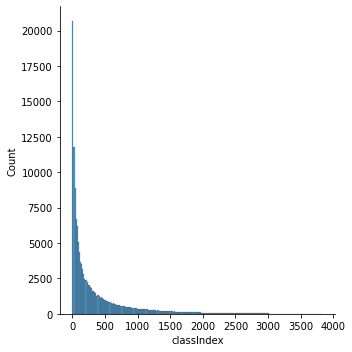

In [91]:
# now it is easy to explore the distribution between the classes:
# note that the StringIndexer took frequency into account when
# creating the classes, so the lowest indexes have the largest count:

sns.displot(df_kanji2['classIndex'])

In [92]:
df_kanji2['classIndex'].value_counts().sort_index()

0.0       1768
1.0       1766
2.0       1674
3.0       1575
4.0       1451
          ... 
3827.0       1
3828.0       1
3829.0       1
3830.0       1
3831.0       1
Name: classIndex, Length: 3832, dtype: int64

Dataframe Index:  0
Class Index:  2606.0


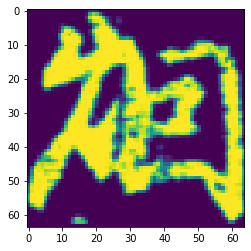

Dataframe Index:  1
Class Index:  2606.0


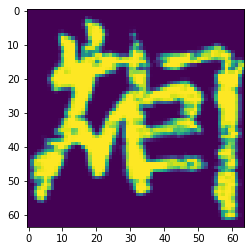

Dataframe Index:  2
Class Index:  2607.0


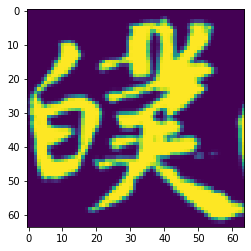

Dataframe Index:  3
Class Index:  2607.0


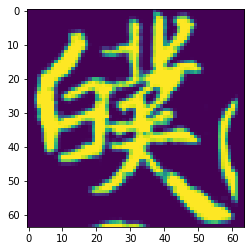

Dataframe Index:  4
Class Index:  3017.0


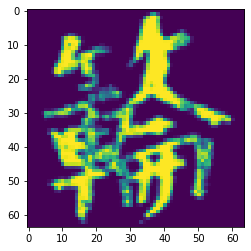

Dataframe Index:  5
Class Index:  1966.0


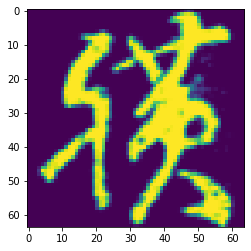

Dataframe Index:  6
Class Index:  1966.0


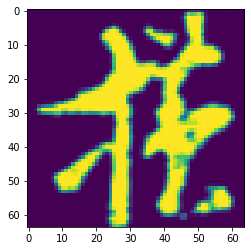

Dataframe Index:  7
Class Index:  1966.0


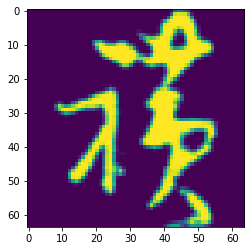

Dataframe Index:  8
Class Index:  1966.0


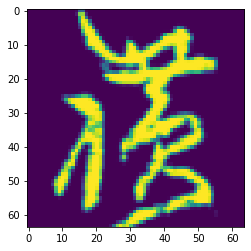

Dataframe Index:  9
Class Index:  1966.0


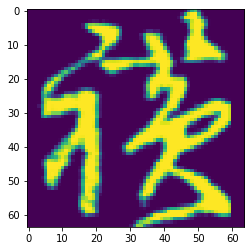

Dataframe Index:  10
Class Index:  3018.0


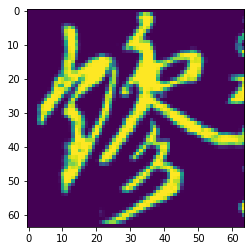

Dataframe Index:  11
Class Index:  3019.0


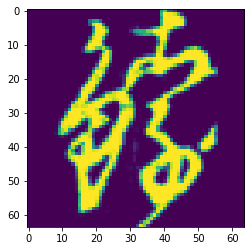

Dataframe Index:  12
Class Index:  3020.0


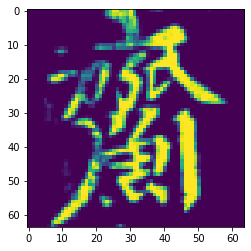

Dataframe Index:  13
Class Index:  3021.0


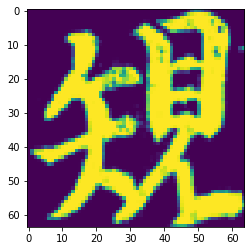

Dataframe Index:  14
Class Index:  680.0


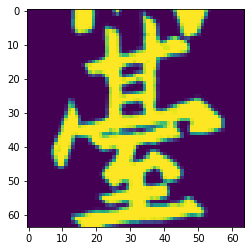

Dataframe Index:  15
Class Index:  680.0


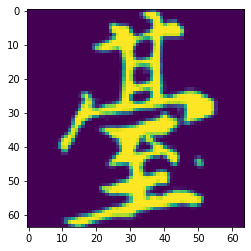

Dataframe Index:  16
Class Index:  680.0


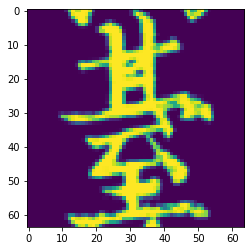

Dataframe Index:  17
Class Index:  680.0


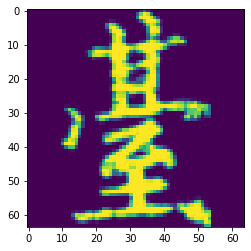

Dataframe Index:  18
Class Index:  680.0


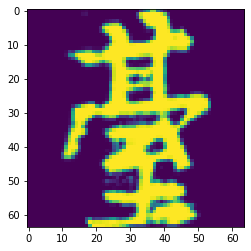

Dataframe Index:  19
Class Index:  680.0


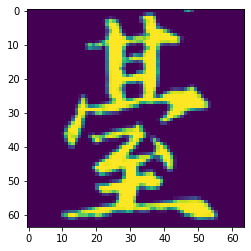

Dataframe Index:  20
Class Index:  680.0


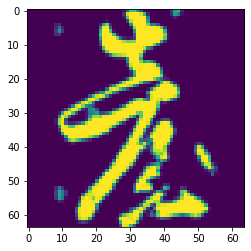

Dataframe Index:  21
Class Index:  680.0


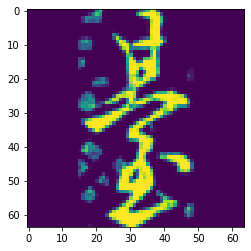

Dataframe Index:  22
Class Index:  680.0


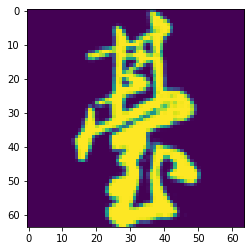

Dataframe Index:  23
Class Index:  680.0


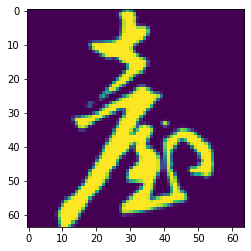

Dataframe Index:  24
Class Index:  680.0


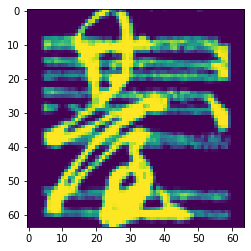

Dataframe Index:  25
Class Index:  680.0


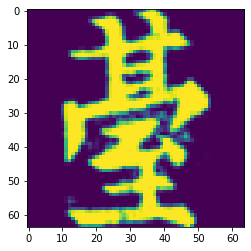

Dataframe Index:  26
Class Index:  680.0


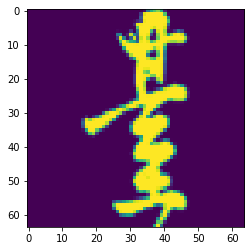

Dataframe Index:  27
Class Index:  680.0


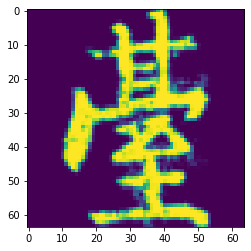

Dataframe Index:  28
Class Index:  680.0


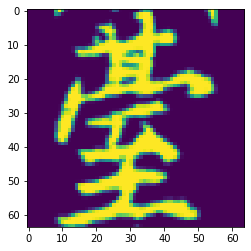

Dataframe Index:  29
Class Index:  680.0


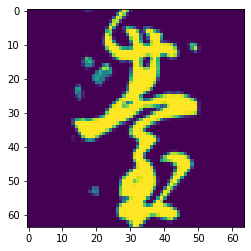

Dataframe Index:  30
Class Index:  680.0


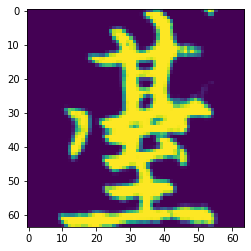

Dataframe Index:  31
Class Index:  680.0


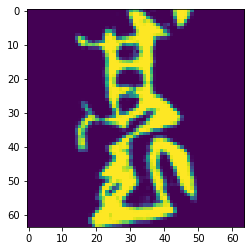

Dataframe Index:  32
Class Index:  680.0


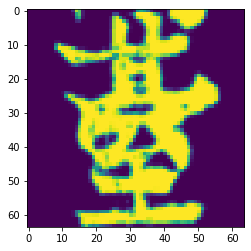

Dataframe Index:  33
Class Index:  680.0


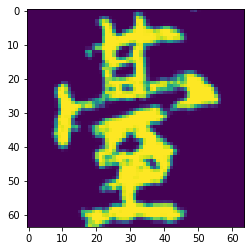

Dataframe Index:  34
Class Index:  680.0


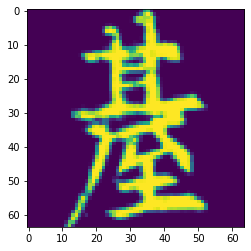

Dataframe Index:  35
Class Index:  680.0


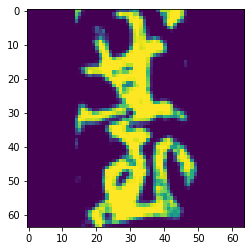

Dataframe Index:  36
Class Index:  680.0


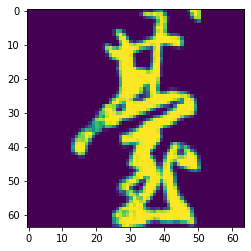

Dataframe Index:  37
Class Index:  680.0


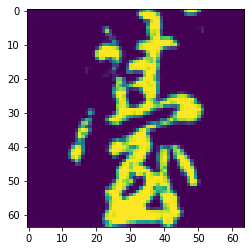

Dataframe Index:  38
Class Index:  680.0


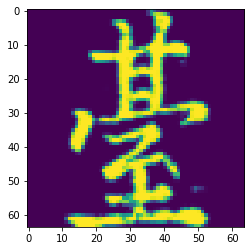

Dataframe Index:  39
Class Index:  680.0


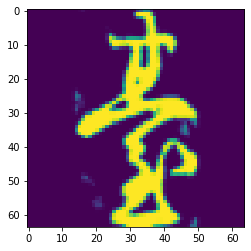

Dataframe Index:  40
Class Index:  680.0


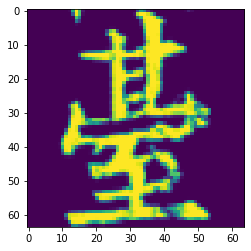

Dataframe Index:  41
Class Index:  680.0


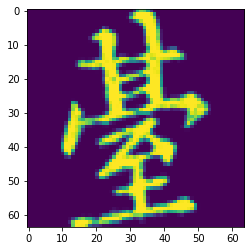

Dataframe Index:  42
Class Index:  680.0


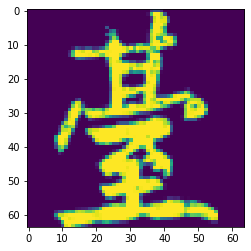

Dataframe Index:  43
Class Index:  680.0


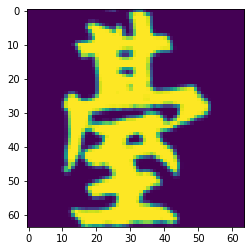

Dataframe Index:  44
Class Index:  680.0


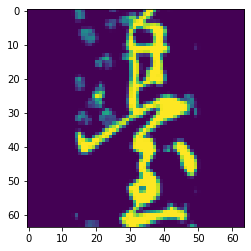

Dataframe Index:  45
Class Index:  680.0


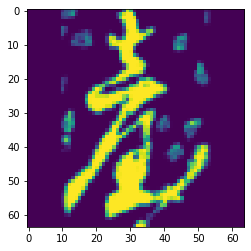

Dataframe Index:  46
Class Index:  680.0


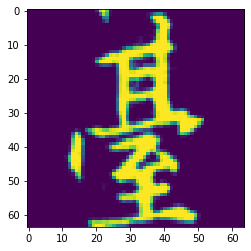

Dataframe Index:  47
Class Index:  680.0


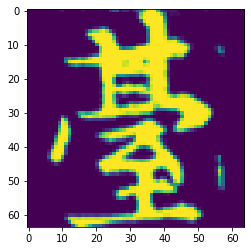

Dataframe Index:  48
Class Index:  680.0


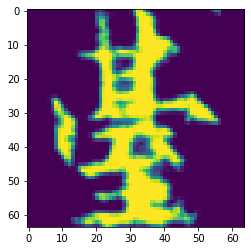

Dataframe Index:  49
Class Index:  680.0


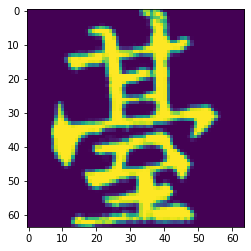

Dataframe Index:  50
Class Index:  680.0


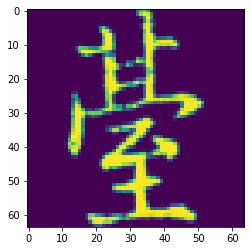

Dataframe Index:  51
Class Index:  680.0


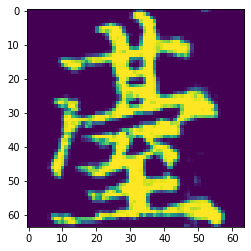

Dataframe Index:  52
Class Index:  680.0


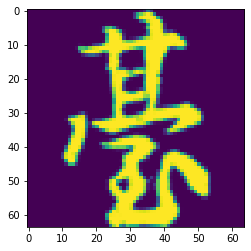

Dataframe Index:  53
Class Index:  3022.0


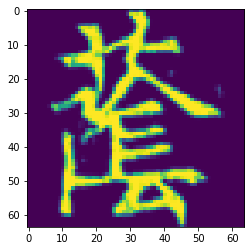

Dataframe Index:  54
Class Index:  3023.0


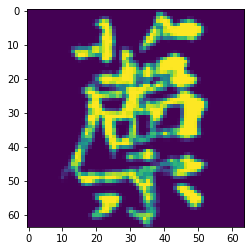

Dataframe Index:  55
Class Index:  3024.0


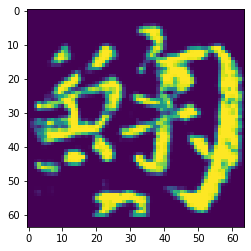

Dataframe Index:  56
Class Index:  3025.0


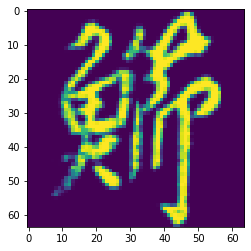

Dataframe Index:  57
Class Index:  0.0


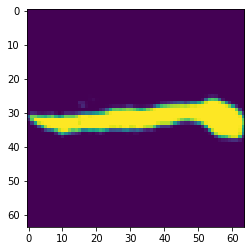

Dataframe Index:  58
Class Index:  0.0


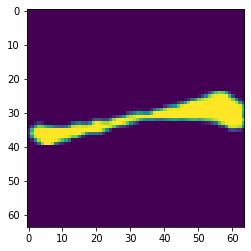

Dataframe Index:  59
Class Index:  0.0


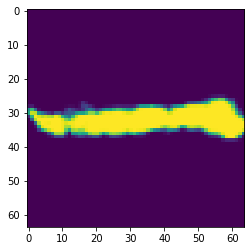

Dataframe Index:  60
Class Index:  0.0


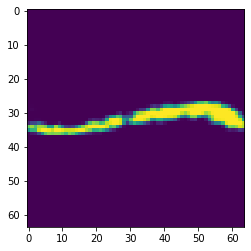

Dataframe Index:  61
Class Index:  0.0


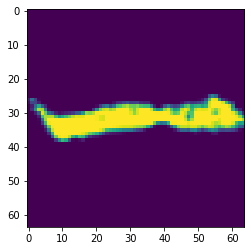

Dataframe Index:  62
Class Index:  0.0


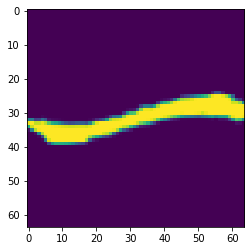

Dataframe Index:  63
Class Index:  0.0


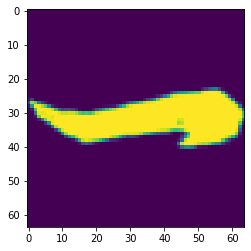

Dataframe Index:  64
Class Index:  0.0


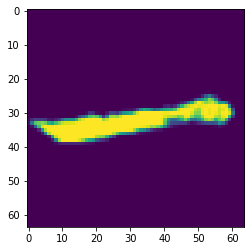

Dataframe Index:  65
Class Index:  0.0


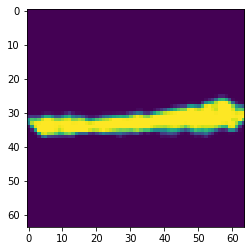

Dataframe Index:  66
Class Index:  0.0


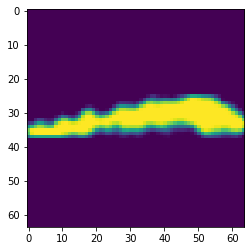

Dataframe Index:  67
Class Index:  0.0


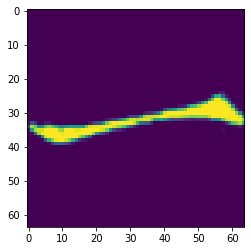

Dataframe Index:  68
Class Index:  0.0


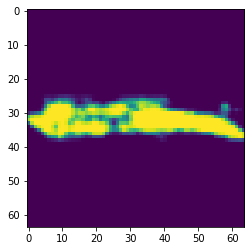

Dataframe Index:  69
Class Index:  0.0


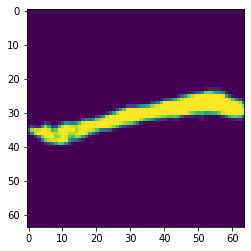

Dataframe Index:  70
Class Index:  0.0


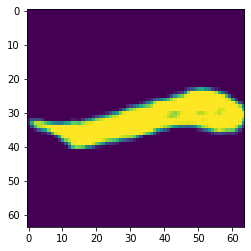

Dataframe Index:  71
Class Index:  0.0


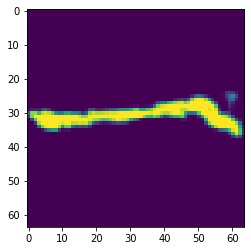

Dataframe Index:  72
Class Index:  0.0


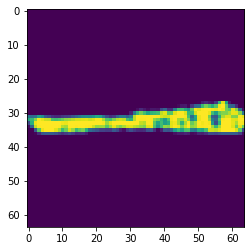

Dataframe Index:  73
Class Index:  0.0


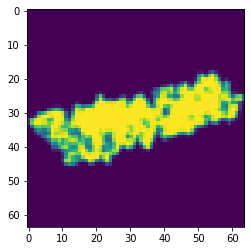

Dataframe Index:  74
Class Index:  0.0


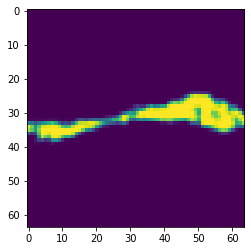

Dataframe Index:  75
Class Index:  0.0


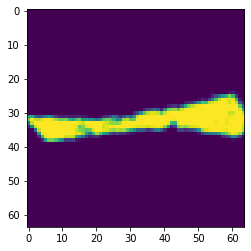

Dataframe Index:  76
Class Index:  0.0


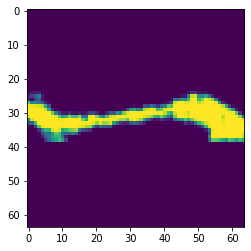

Dataframe Index:  77
Class Index:  0.0


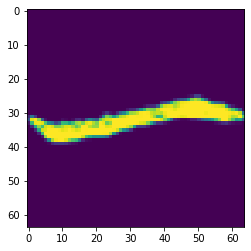

Dataframe Index:  78
Class Index:  0.0


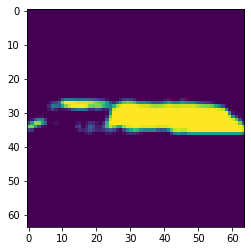

Dataframe Index:  79
Class Index:  0.0


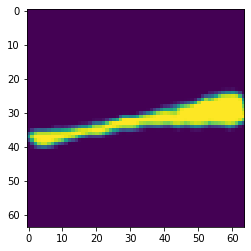

Dataframe Index:  80
Class Index:  0.0


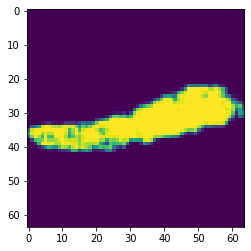

Dataframe Index:  81
Class Index:  0.0


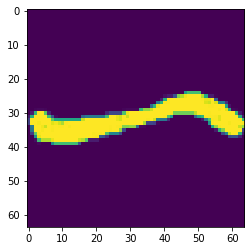

Dataframe Index:  82
Class Index:  0.0


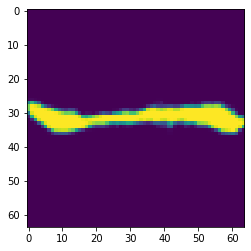

Dataframe Index:  83
Class Index:  0.0


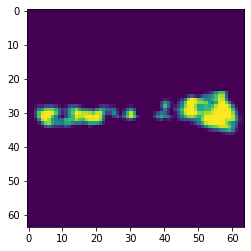

Dataframe Index:  84
Class Index:  0.0


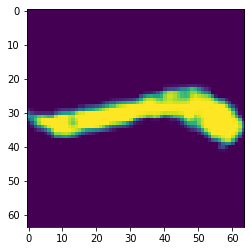

Dataframe Index:  85
Class Index:  0.0


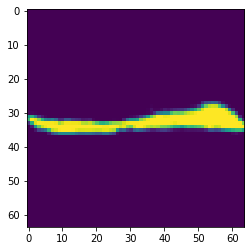

Dataframe Index:  86
Class Index:  0.0


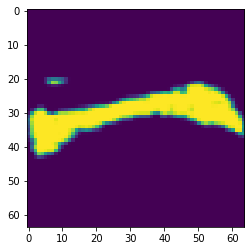

Dataframe Index:  87
Class Index:  0.0


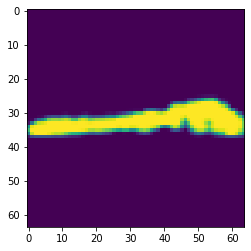

Dataframe Index:  88
Class Index:  0.0


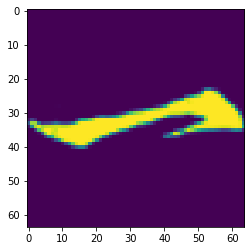

Dataframe Index:  89
Class Index:  0.0


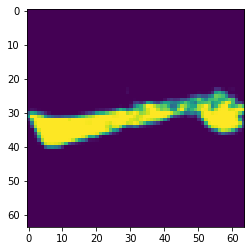

Dataframe Index:  90
Class Index:  0.0


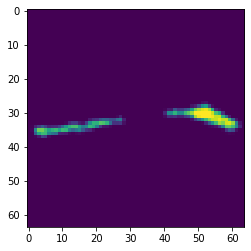

Dataframe Index:  91
Class Index:  0.0


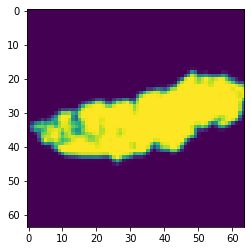

Dataframe Index:  92
Class Index:  0.0


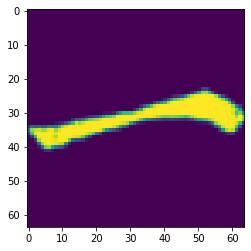

Dataframe Index:  93
Class Index:  0.0


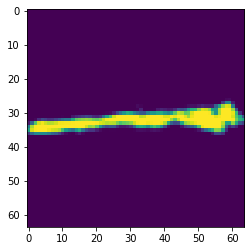

Dataframe Index:  94
Class Index:  0.0


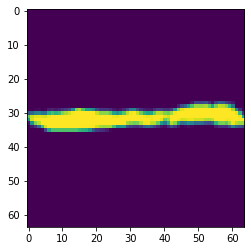

Dataframe Index:  95
Class Index:  0.0


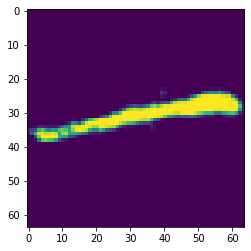

Dataframe Index:  96
Class Index:  0.0


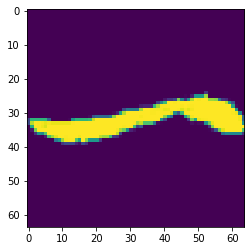

Dataframe Index:  97
Class Index:  0.0


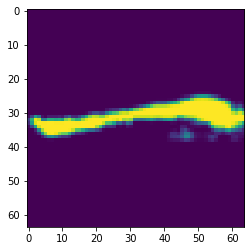

Dataframe Index:  98
Class Index:  0.0


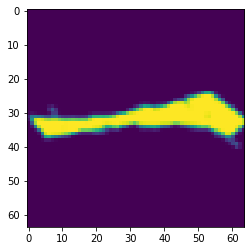

Dataframe Index:  99
Class Index:  0.0


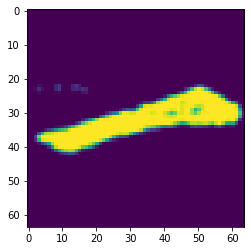

Dataframe Index:  100
Class Index:  0.0


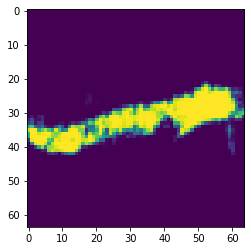

Dataframe Index:  101
Class Index:  0.0


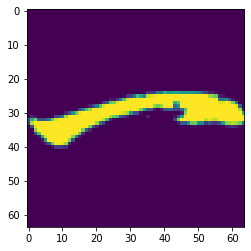

Dataframe Index:  102
Class Index:  0.0


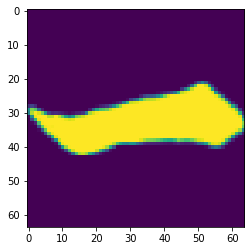

Dataframe Index:  103
Class Index:  0.0


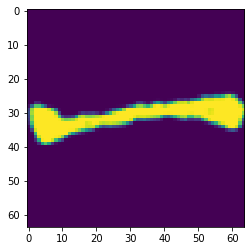

Dataframe Index:  104
Class Index:  0.0


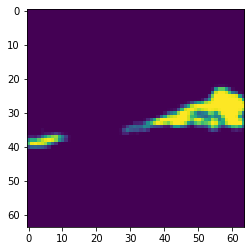

Dataframe Index:  105
Class Index:  0.0


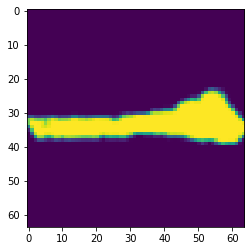

Dataframe Index:  106
Class Index:  0.0


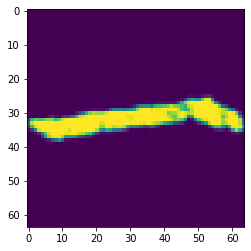

Dataframe Index:  107
Class Index:  0.0


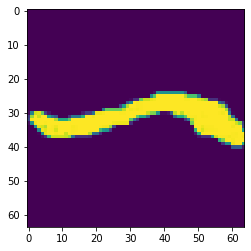

Dataframe Index:  108
Class Index:  0.0


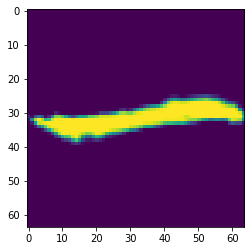

Dataframe Index:  109
Class Index:  0.0


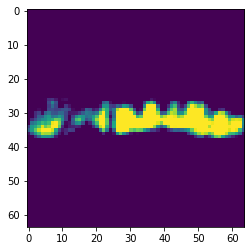

Dataframe Index:  110
Class Index:  0.0


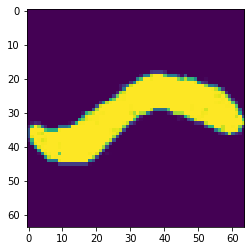

Dataframe Index:  111
Class Index:  0.0


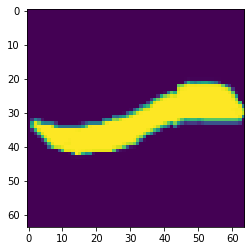

Dataframe Index:  112
Class Index:  0.0


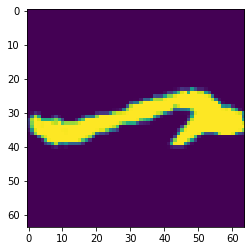

Dataframe Index:  113
Class Index:  0.0


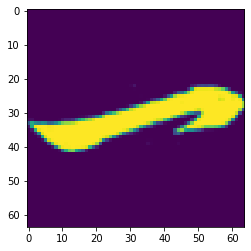

Dataframe Index:  114
Class Index:  0.0


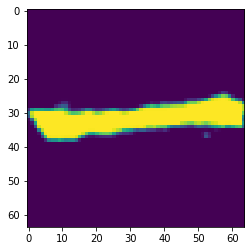

Dataframe Index:  115
Class Index:  0.0


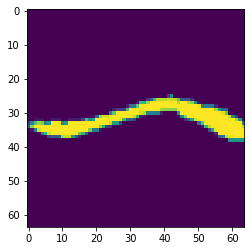

Dataframe Index:  116
Class Index:  0.0


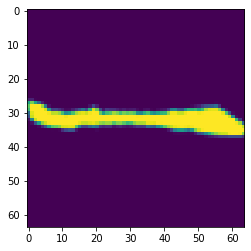

Dataframe Index:  117
Class Index:  0.0


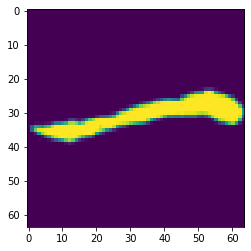

Dataframe Index:  118
Class Index:  0.0


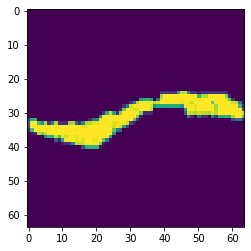

Dataframe Index:  119
Class Index:  0.0


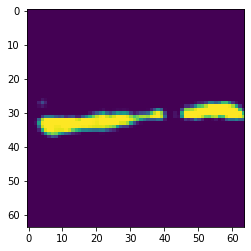

Dataframe Index:  120
Class Index:  0.0


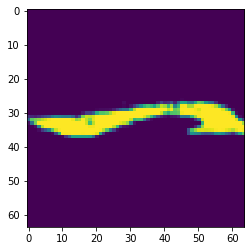

Dataframe Index:  121
Class Index:  0.0


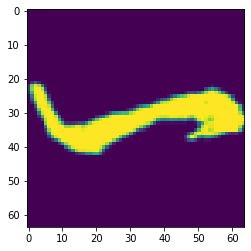

Dataframe Index:  122
Class Index:  0.0


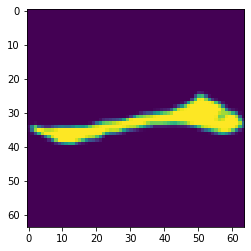

Dataframe Index:  123
Class Index:  0.0


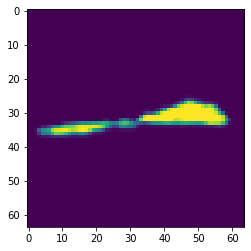

Dataframe Index:  124
Class Index:  0.0


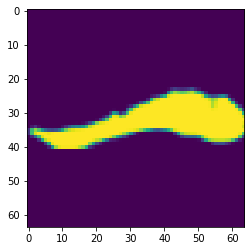

Dataframe Index:  125
Class Index:  0.0


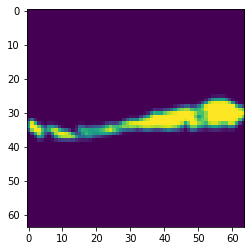

Dataframe Index:  126
Class Index:  0.0


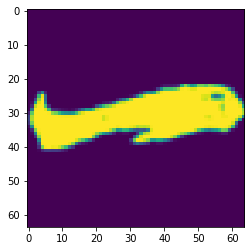

Dataframe Index:  127
Class Index:  0.0


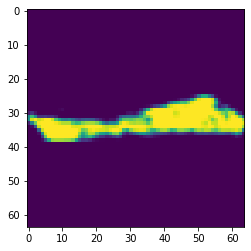

Dataframe Index:  128
Class Index:  0.0


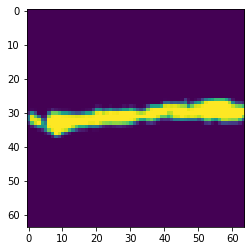

Dataframe Index:  129
Class Index:  0.0


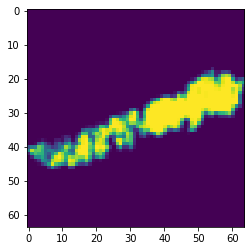

Dataframe Index:  130
Class Index:  0.0


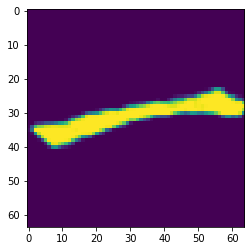

Dataframe Index:  131
Class Index:  0.0


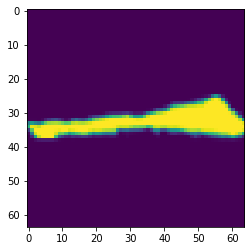

Dataframe Index:  132
Class Index:  0.0


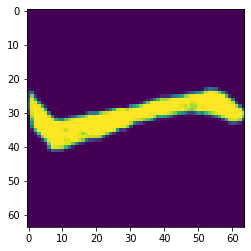

Dataframe Index:  133
Class Index:  0.0


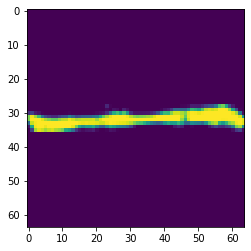

Dataframe Index:  134
Class Index:  0.0


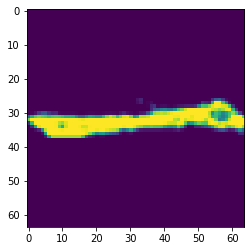

Dataframe Index:  135
Class Index:  0.0


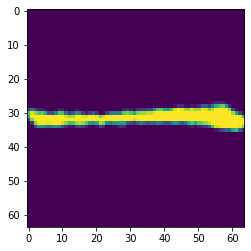

Dataframe Index:  136
Class Index:  0.0


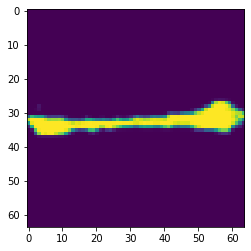

Dataframe Index:  137
Class Index:  0.0


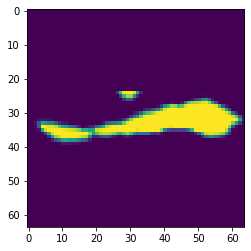

Dataframe Index:  138
Class Index:  0.0


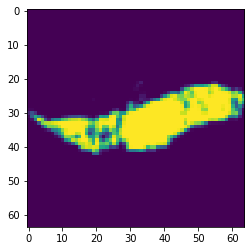

Dataframe Index:  139
Class Index:  0.0


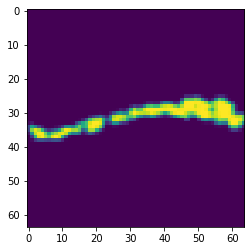

Dataframe Index:  140
Class Index:  0.0


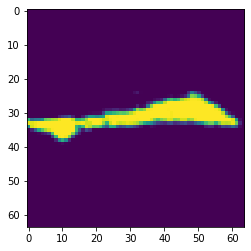

Dataframe Index:  141
Class Index:  0.0


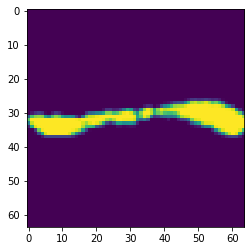

Dataframe Index:  142
Class Index:  0.0


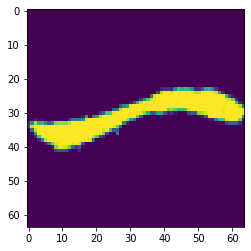

Dataframe Index:  143
Class Index:  0.0


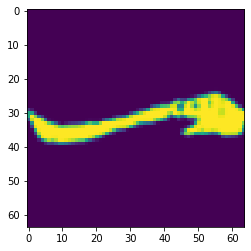

Dataframe Index:  144
Class Index:  0.0


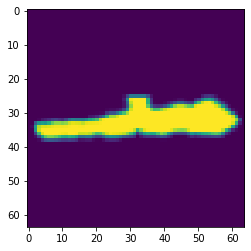

Dataframe Index:  145
Class Index:  0.0


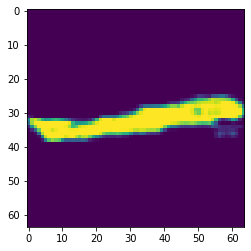

Dataframe Index:  146
Class Index:  0.0


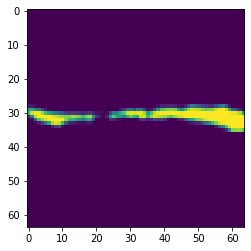

Dataframe Index:  147
Class Index:  0.0


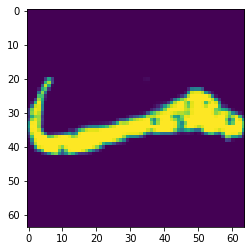

Dataframe Index:  148
Class Index:  0.0


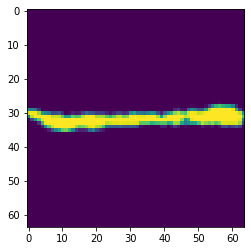

Dataframe Index:  149
Class Index:  0.0


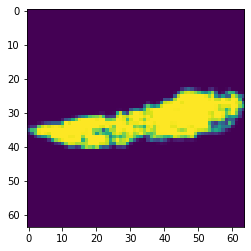

Dataframe Index:  150
Class Index:  0.0


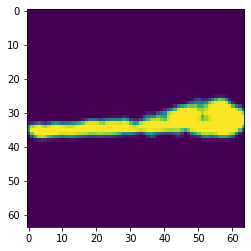

Dataframe Index:  151
Class Index:  0.0


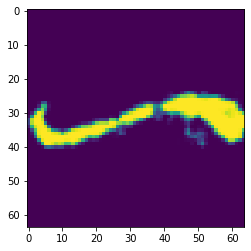

Dataframe Index:  152
Class Index:  0.0


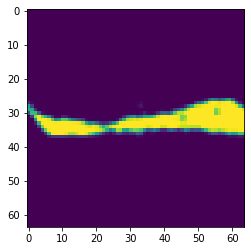

Dataframe Index:  153
Class Index:  0.0


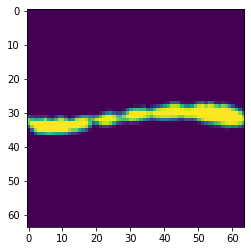

Dataframe Index:  154
Class Index:  0.0


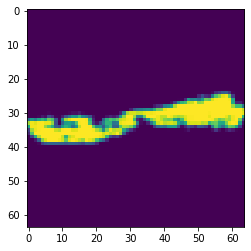

Dataframe Index:  155
Class Index:  0.0


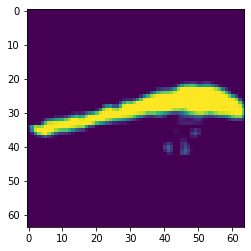

Dataframe Index:  156
Class Index:  0.0


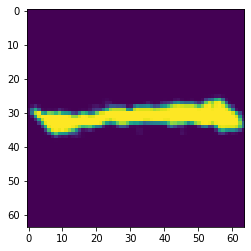

Dataframe Index:  157
Class Index:  0.0


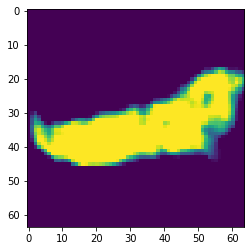

Dataframe Index:  158
Class Index:  0.0


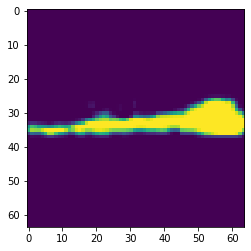

Dataframe Index:  159
Class Index:  0.0


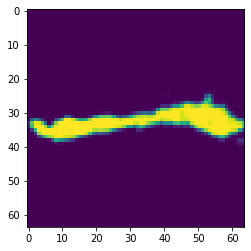

Dataframe Index:  160
Class Index:  0.0


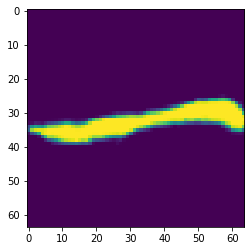

Dataframe Index:  161
Class Index:  0.0


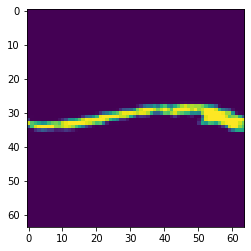

Dataframe Index:  162
Class Index:  0.0


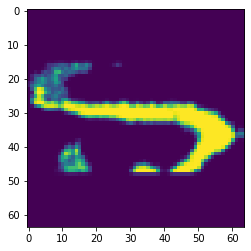

Dataframe Index:  163
Class Index:  0.0


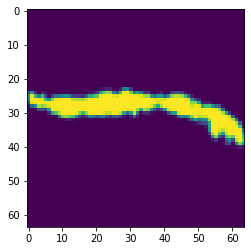

Dataframe Index:  164
Class Index:  0.0


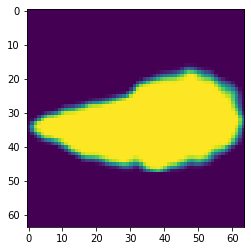

Dataframe Index:  165
Class Index:  0.0


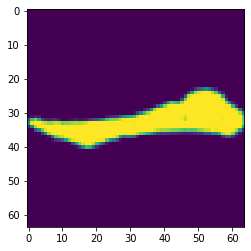

Dataframe Index:  166
Class Index:  0.0


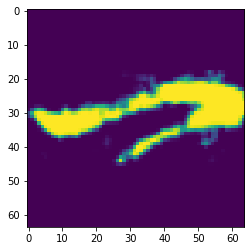

Dataframe Index:  167
Class Index:  0.0


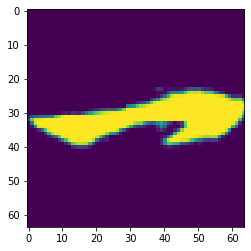

Dataframe Index:  168
Class Index:  0.0


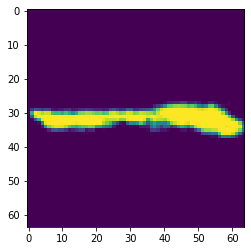

Dataframe Index:  169
Class Index:  0.0


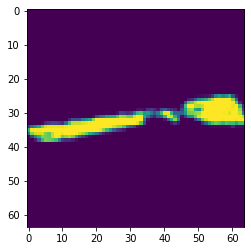

Dataframe Index:  170
Class Index:  0.0


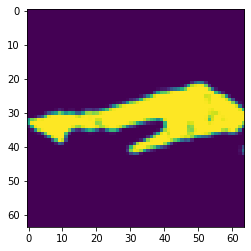

Dataframe Index:  171
Class Index:  0.0


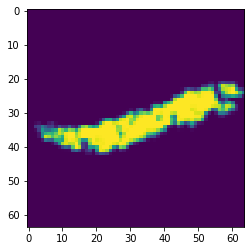

Dataframe Index:  172
Class Index:  0.0


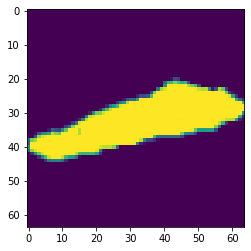

Dataframe Index:  173
Class Index:  0.0


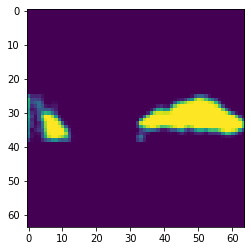

Dataframe Index:  174
Class Index:  0.0


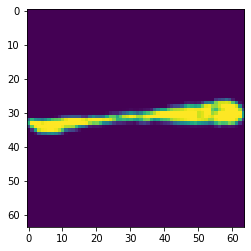

Dataframe Index:  175
Class Index:  0.0


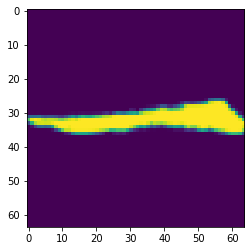

Dataframe Index:  176
Class Index:  0.0


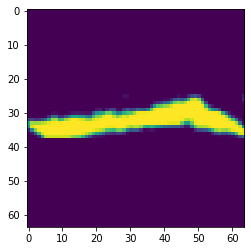

Dataframe Index:  177
Class Index:  0.0


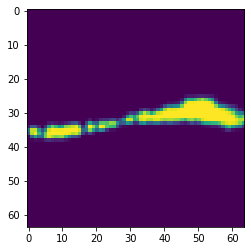

Dataframe Index:  178
Class Index:  0.0


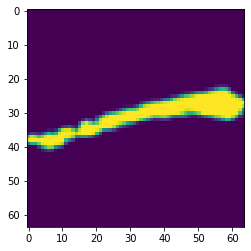

Dataframe Index:  179
Class Index:  0.0


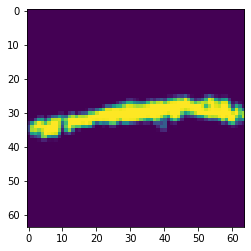

Dataframe Index:  180
Class Index:  0.0


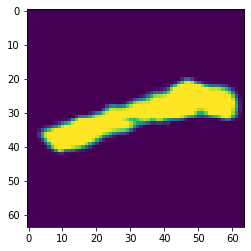

Dataframe Index:  181
Class Index:  0.0


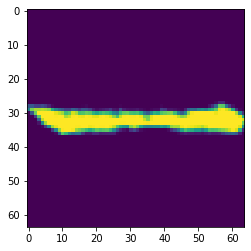

Dataframe Index:  182
Class Index:  0.0


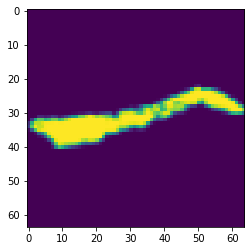

Dataframe Index:  183
Class Index:  0.0


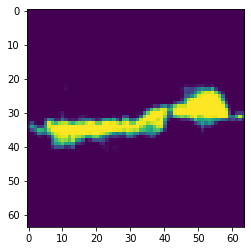

Dataframe Index:  184
Class Index:  0.0


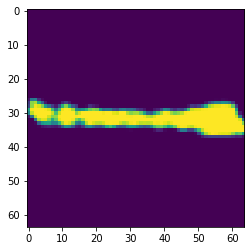

Dataframe Index:  185
Class Index:  0.0


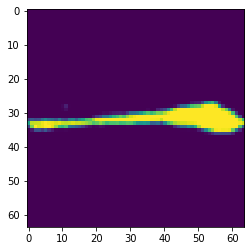

Dataframe Index:  186
Class Index:  0.0


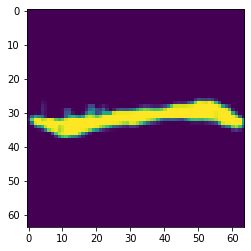

Dataframe Index:  187
Class Index:  0.0


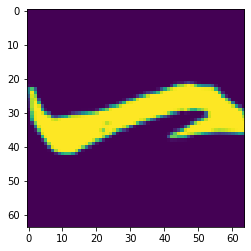

Dataframe Index:  188
Class Index:  0.0


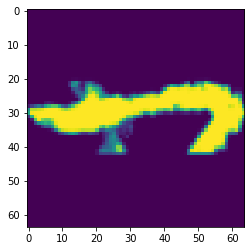

Dataframe Index:  189
Class Index:  0.0


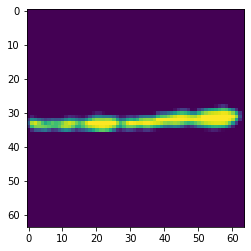

Dataframe Index:  190
Class Index:  0.0


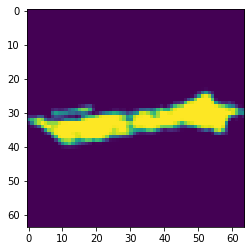

Dataframe Index:  191
Class Index:  0.0


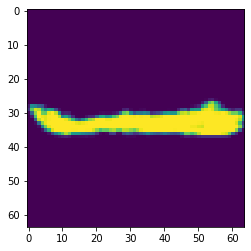

Dataframe Index:  192
Class Index:  0.0


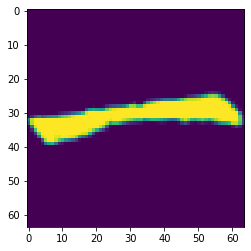

Dataframe Index:  193
Class Index:  0.0


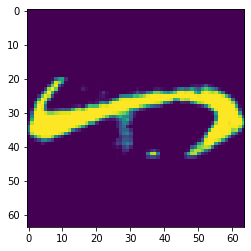

Dataframe Index:  194
Class Index:  0.0


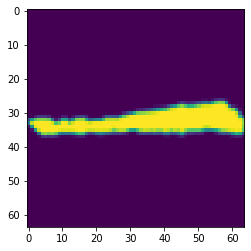

Dataframe Index:  195
Class Index:  0.0


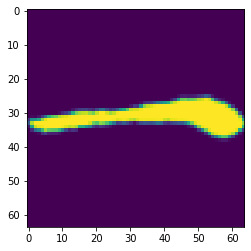

Dataframe Index:  196
Class Index:  0.0


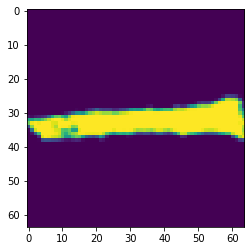

Dataframe Index:  197
Class Index:  0.0


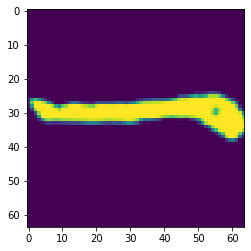

Dataframe Index:  198
Class Index:  0.0


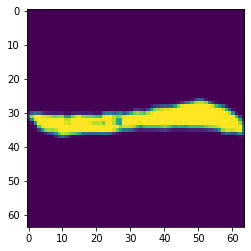

Dataframe Index:  199
Class Index:  0.0


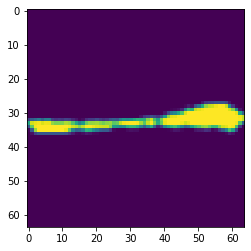

Dataframe Index:  200
Class Index:  0.0


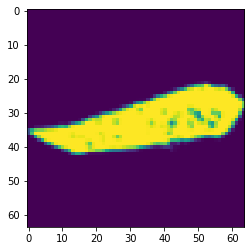

Dataframe Index:  201
Class Index:  0.0


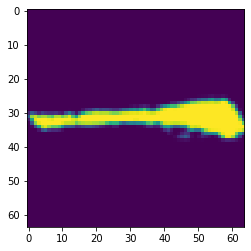

Dataframe Index:  202
Class Index:  0.0


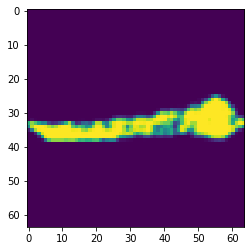

Dataframe Index:  203
Class Index:  0.0


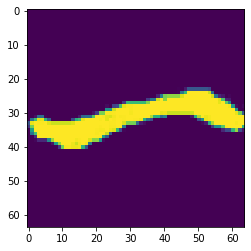

Dataframe Index:  204
Class Index:  0.0


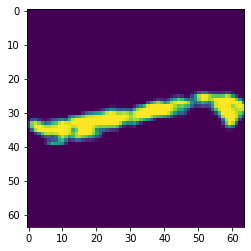

Dataframe Index:  205
Class Index:  0.0


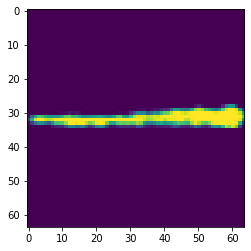

Dataframe Index:  206
Class Index:  0.0


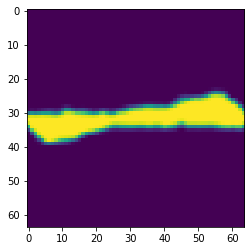

Dataframe Index:  207
Class Index:  0.0


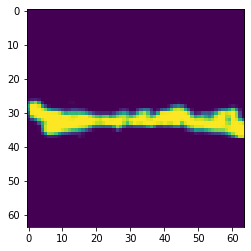

Dataframe Index:  208
Class Index:  0.0


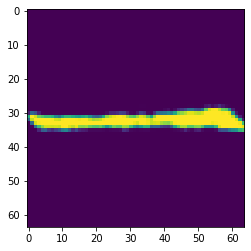

Dataframe Index:  209
Class Index:  0.0


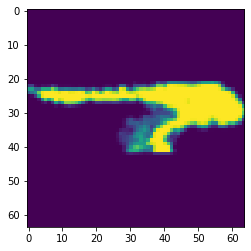

Dataframe Index:  210
Class Index:  0.0


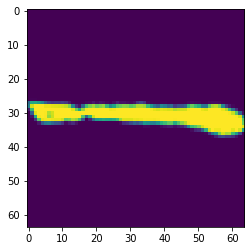

Dataframe Index:  211
Class Index:  0.0


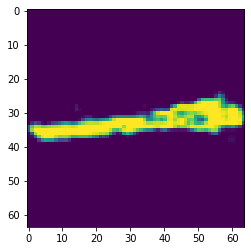

Dataframe Index:  212
Class Index:  0.0


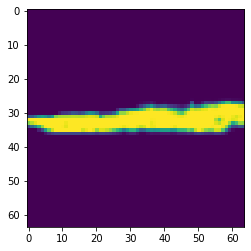

Dataframe Index:  213
Class Index:  0.0


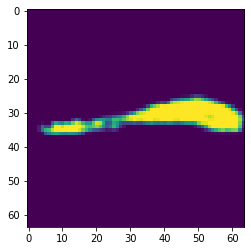

Dataframe Index:  214
Class Index:  0.0


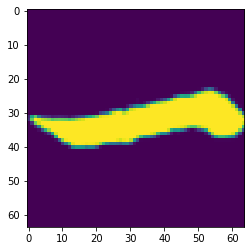

Dataframe Index:  215
Class Index:  0.0


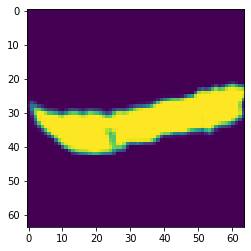

Dataframe Index:  216
Class Index:  0.0


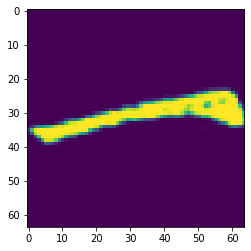

Dataframe Index:  217
Class Index:  0.0


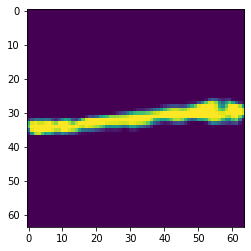

Dataframe Index:  218
Class Index:  0.0


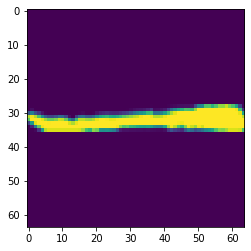

Dataframe Index:  219
Class Index:  0.0


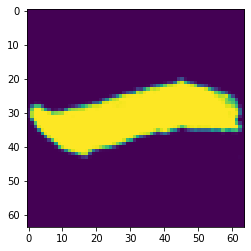

Dataframe Index:  220
Class Index:  0.0


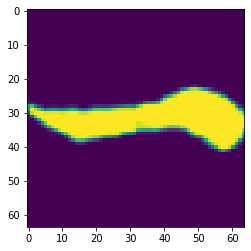

Dataframe Index:  221
Class Index:  0.0


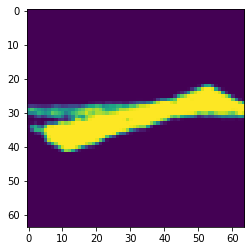

Dataframe Index:  222
Class Index:  0.0


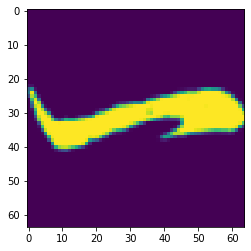

Dataframe Index:  223
Class Index:  0.0


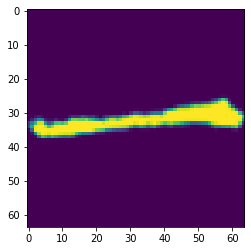

Dataframe Index:  224
Class Index:  0.0


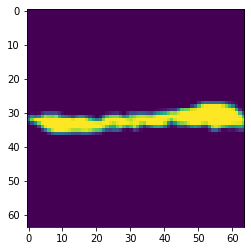

Dataframe Index:  225
Class Index:  0.0


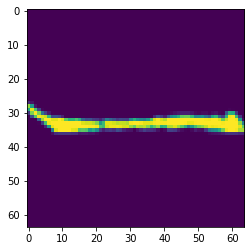

Dataframe Index:  226
Class Index:  0.0


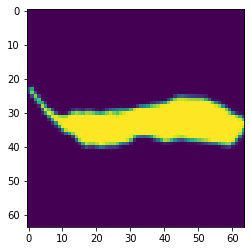

Dataframe Index:  227
Class Index:  0.0


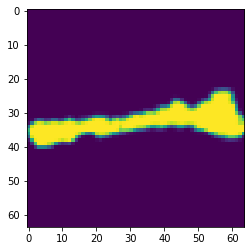

Dataframe Index:  228
Class Index:  0.0


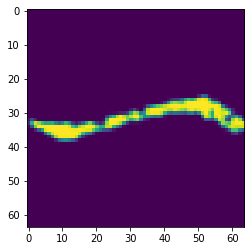

Dataframe Index:  229
Class Index:  0.0


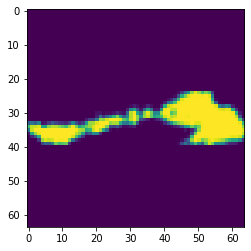

Dataframe Index:  230
Class Index:  0.0


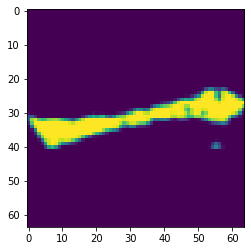

Dataframe Index:  231
Class Index:  0.0


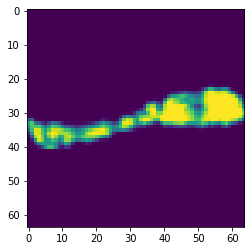

Dataframe Index:  232
Class Index:  0.0


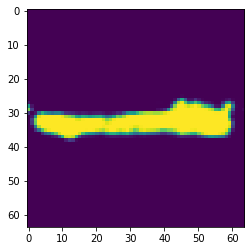

Dataframe Index:  233
Class Index:  0.0


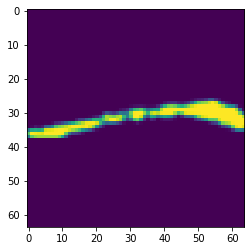

Dataframe Index:  234
Class Index:  0.0


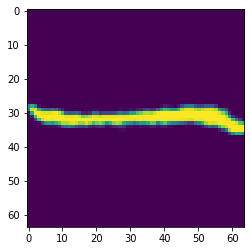

Dataframe Index:  235
Class Index:  0.0


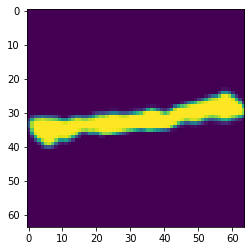

Dataframe Index:  236
Class Index:  0.0


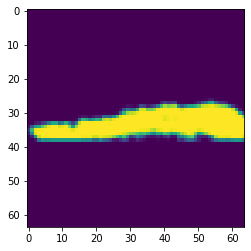

Dataframe Index:  237
Class Index:  0.0


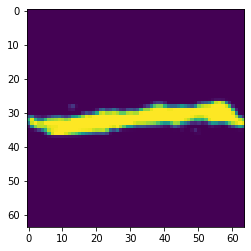

Dataframe Index:  238
Class Index:  0.0


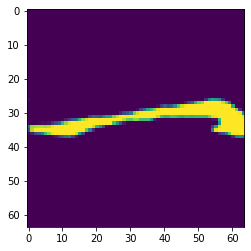

Dataframe Index:  239
Class Index:  0.0


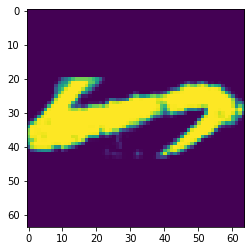

Dataframe Index:  240
Class Index:  0.0


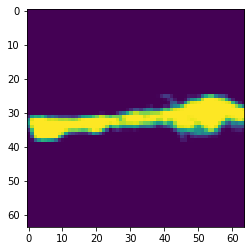

Dataframe Index:  241
Class Index:  0.0


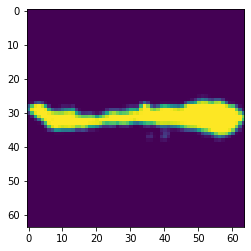

Dataframe Index:  242
Class Index:  0.0


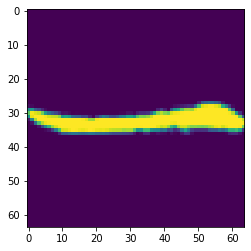

Dataframe Index:  243
Class Index:  0.0


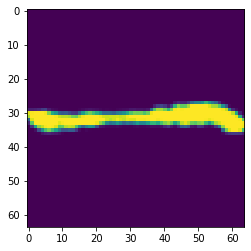

Dataframe Index:  244
Class Index:  0.0


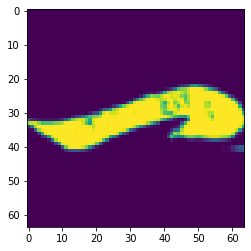

Dataframe Index:  245
Class Index:  0.0


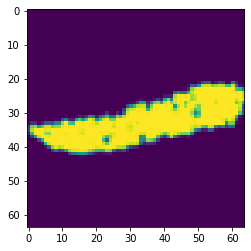

Dataframe Index:  246
Class Index:  0.0


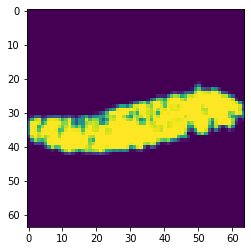

Dataframe Index:  247
Class Index:  0.0


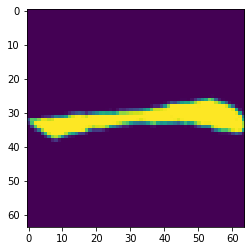

Dataframe Index:  248
Class Index:  0.0


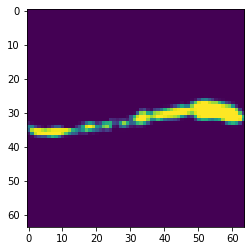

Dataframe Index:  249
Class Index:  0.0


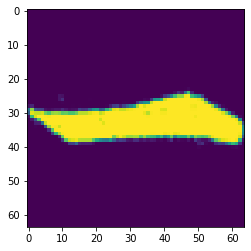

Dataframe Index:  250
Class Index:  0.0


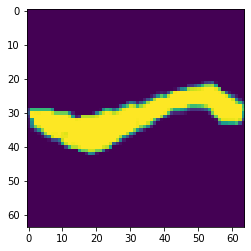

Dataframe Index:  251
Class Index:  0.0


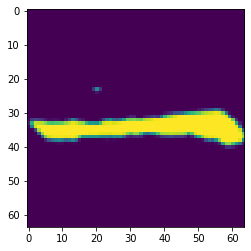

Dataframe Index:  252
Class Index:  0.0


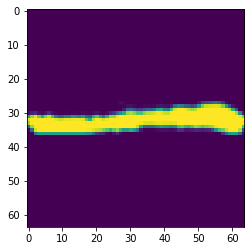

Dataframe Index:  253
Class Index:  0.0


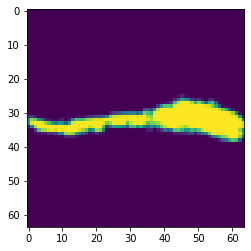

Dataframe Index:  254
Class Index:  0.0


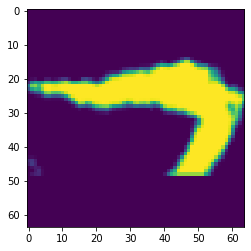

Dataframe Index:  255
Class Index:  0.0


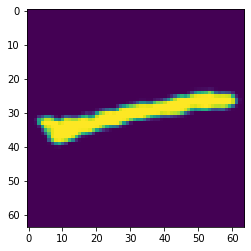

Dataframe Index:  256
Class Index:  0.0


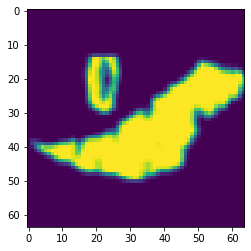

Dataframe Index:  257
Class Index:  0.0


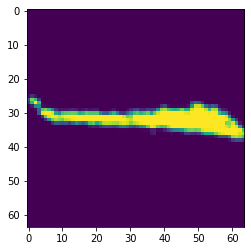

Dataframe Index:  258
Class Index:  0.0


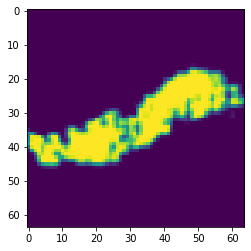

Dataframe Index:  259
Class Index:  0.0


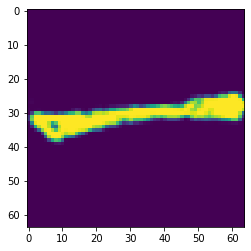

Dataframe Index:  260
Class Index:  0.0


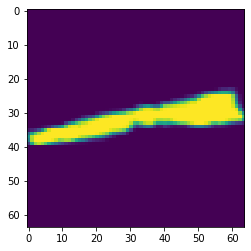

Dataframe Index:  261
Class Index:  0.0


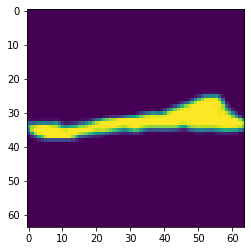

Dataframe Index:  262
Class Index:  0.0


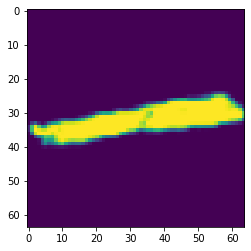

Dataframe Index:  263
Class Index:  0.0


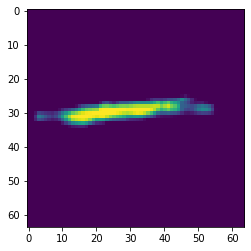

Dataframe Index:  264
Class Index:  0.0


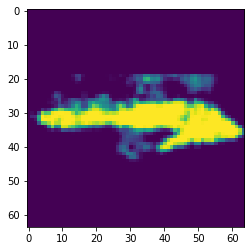

Dataframe Index:  265
Class Index:  0.0


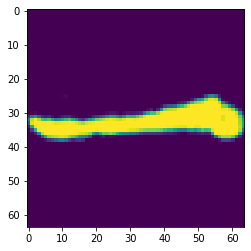

Dataframe Index:  266
Class Index:  0.0


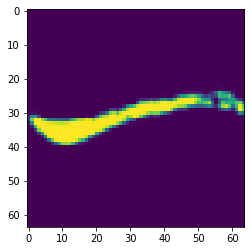

Dataframe Index:  267
Class Index:  0.0


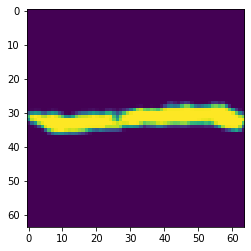

Dataframe Index:  268
Class Index:  0.0


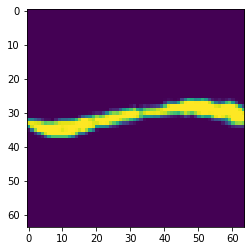

Dataframe Index:  269
Class Index:  0.0


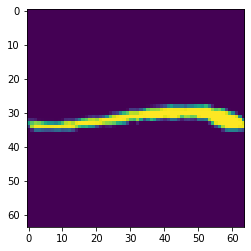

Dataframe Index:  270
Class Index:  0.0


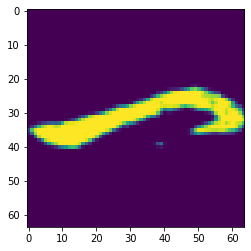

Dataframe Index:  271
Class Index:  0.0


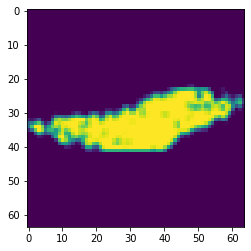

Dataframe Index:  272
Class Index:  0.0


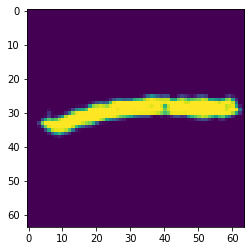

Dataframe Index:  273
Class Index:  0.0


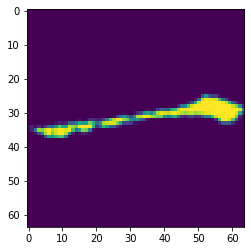

Dataframe Index:  274
Class Index:  0.0


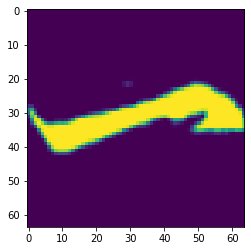

Dataframe Index:  275
Class Index:  0.0


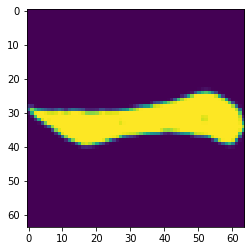

Dataframe Index:  276
Class Index:  0.0


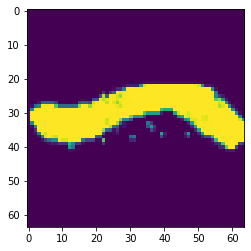

Dataframe Index:  277
Class Index:  0.0


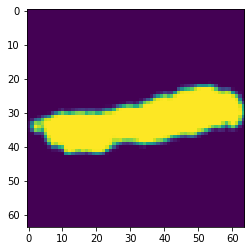

Dataframe Index:  278
Class Index:  0.0


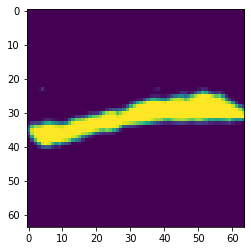

Dataframe Index:  279
Class Index:  0.0


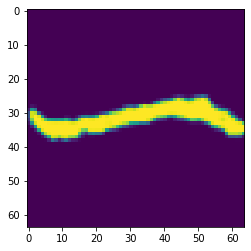

Dataframe Index:  280
Class Index:  0.0


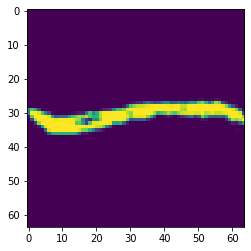

Dataframe Index:  281
Class Index:  0.0


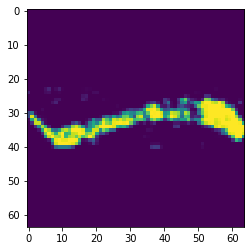

Dataframe Index:  282
Class Index:  0.0


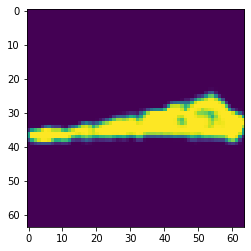

Dataframe Index:  283
Class Index:  0.0


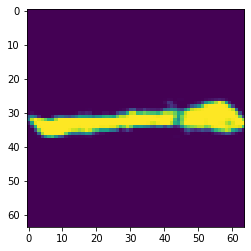

Dataframe Index:  284
Class Index:  0.0


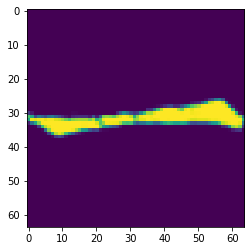

Dataframe Index:  285
Class Index:  0.0


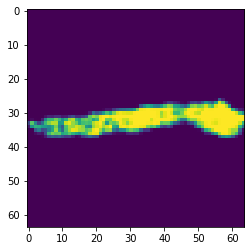

Dataframe Index:  286
Class Index:  0.0


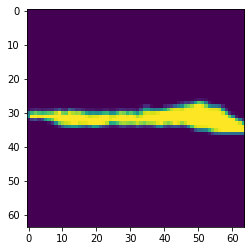

Dataframe Index:  287
Class Index:  0.0


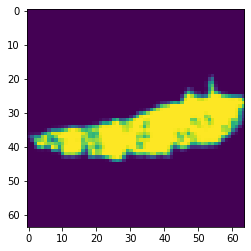

Dataframe Index:  288
Class Index:  0.0


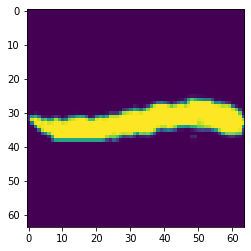

Dataframe Index:  289
Class Index:  0.0


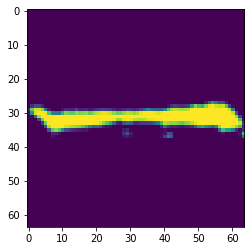

Dataframe Index:  290
Class Index:  0.0


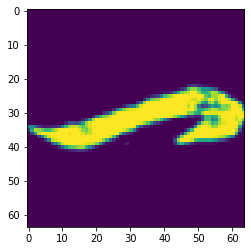

Dataframe Index:  291
Class Index:  0.0


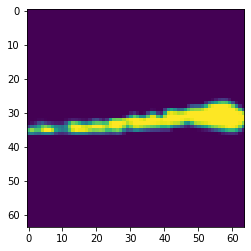

Dataframe Index:  292
Class Index:  0.0


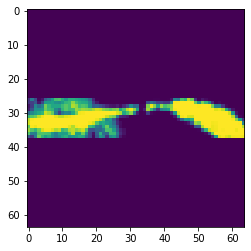

Dataframe Index:  293
Class Index:  0.0


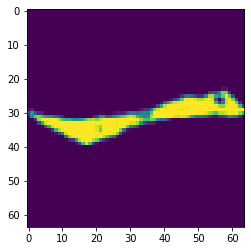

Dataframe Index:  294
Class Index:  0.0


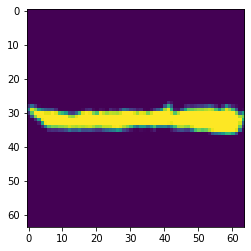

Dataframe Index:  295
Class Index:  0.0


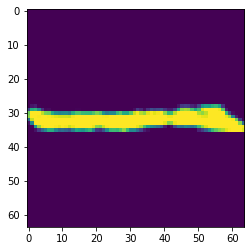

Dataframe Index:  296
Class Index:  0.0


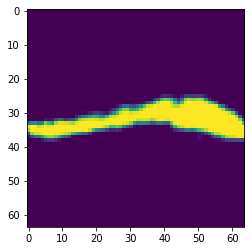

Dataframe Index:  297
Class Index:  0.0


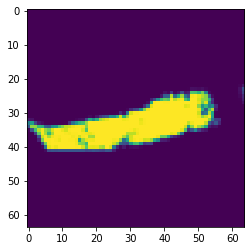

Dataframe Index:  298
Class Index:  0.0


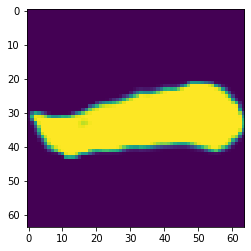

Dataframe Index:  299
Class Index:  0.0


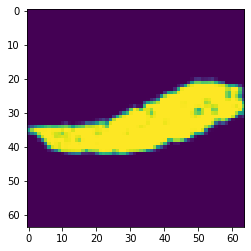

Dataframe Index:  300
Class Index:  0.0


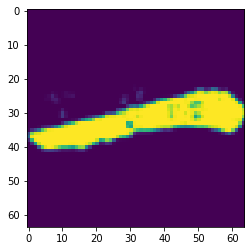

Dataframe Index:  301
Class Index:  0.0


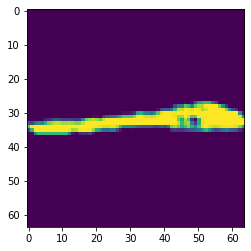

Dataframe Index:  302
Class Index:  0.0


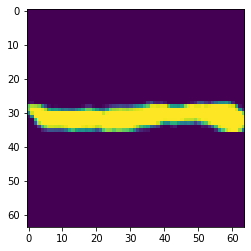

Dataframe Index:  303
Class Index:  0.0


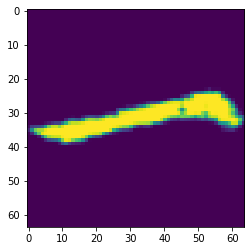

Dataframe Index:  304
Class Index:  0.0


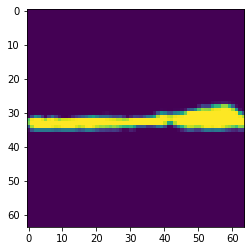

Dataframe Index:  305
Class Index:  0.0


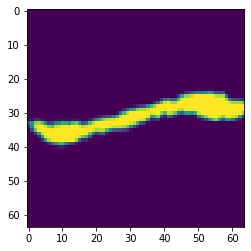

Dataframe Index:  306
Class Index:  0.0


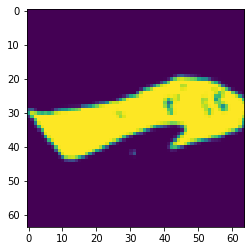

Dataframe Index:  307
Class Index:  0.0


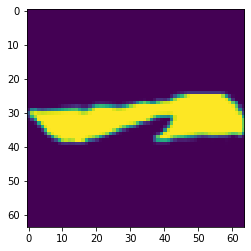

Dataframe Index:  308
Class Index:  0.0


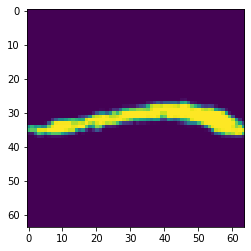

Dataframe Index:  309
Class Index:  0.0


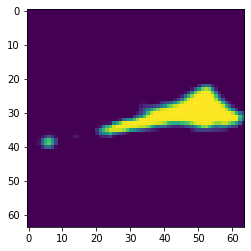

Dataframe Index:  310
Class Index:  0.0


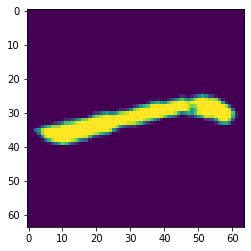

Dataframe Index:  311
Class Index:  0.0


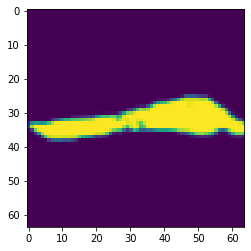

Dataframe Index:  312
Class Index:  0.0


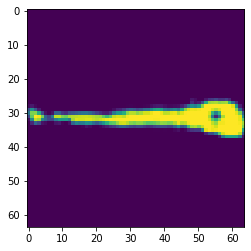

Dataframe Index:  313
Class Index:  0.0


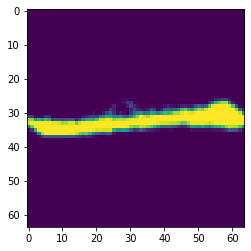

Dataframe Index:  314
Class Index:  0.0


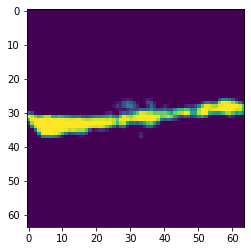

Dataframe Index:  315
Class Index:  0.0


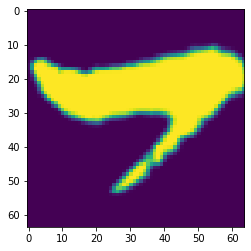

Dataframe Index:  316
Class Index:  0.0


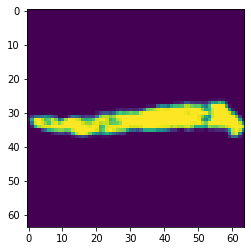

Dataframe Index:  317
Class Index:  0.0


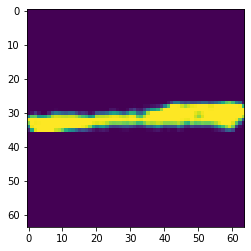

Dataframe Index:  318
Class Index:  0.0


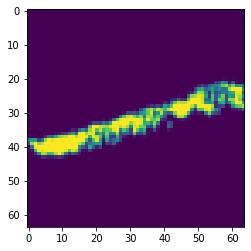

Dataframe Index:  319
Class Index:  0.0


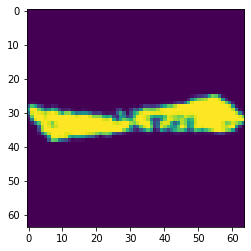

Dataframe Index:  320
Class Index:  0.0


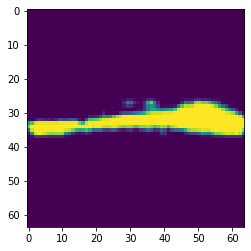

Dataframe Index:  321
Class Index:  0.0


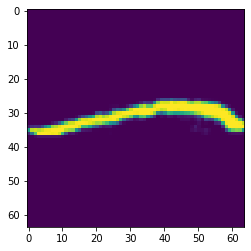

Dataframe Index:  322
Class Index:  0.0


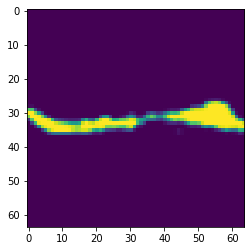

Dataframe Index:  323
Class Index:  0.0


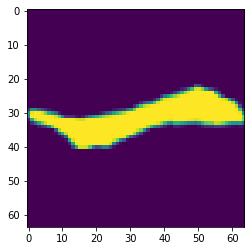

Dataframe Index:  324
Class Index:  0.0


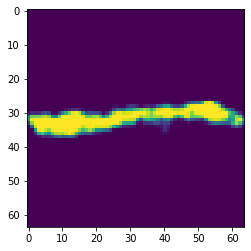

Dataframe Index:  325
Class Index:  0.0


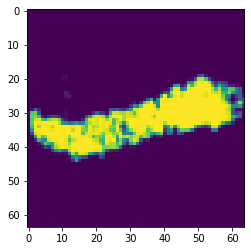

Dataframe Index:  326
Class Index:  0.0


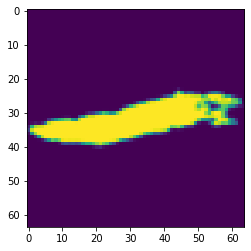

Dataframe Index:  327
Class Index:  0.0


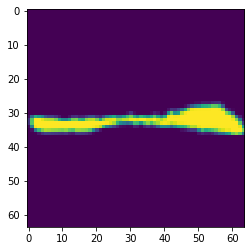

Dataframe Index:  328
Class Index:  0.0


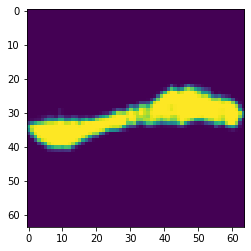

Dataframe Index:  329
Class Index:  0.0


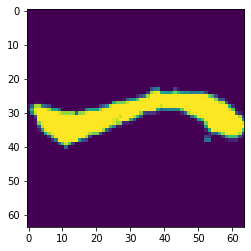

Dataframe Index:  330
Class Index:  0.0


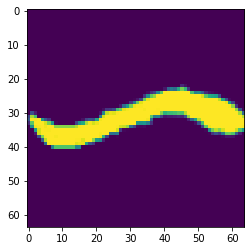

Dataframe Index:  331
Class Index:  0.0


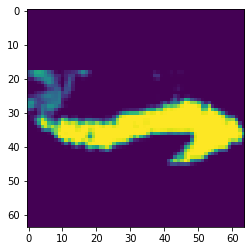

Dataframe Index:  332
Class Index:  0.0


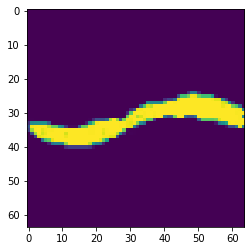

Dataframe Index:  333
Class Index:  0.0


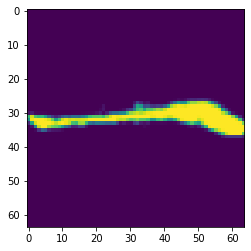

Dataframe Index:  334
Class Index:  0.0


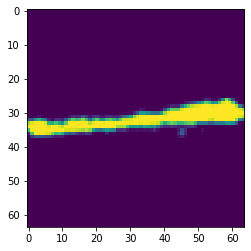

Dataframe Index:  335
Class Index:  0.0


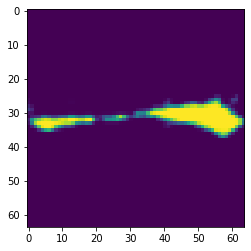

Dataframe Index:  336
Class Index:  0.0


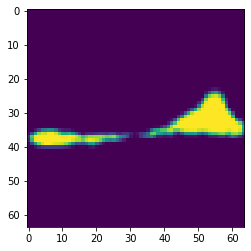

Dataframe Index:  337
Class Index:  0.0


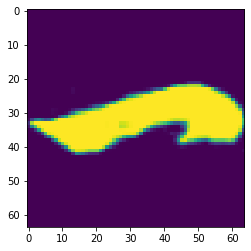

Dataframe Index:  338
Class Index:  0.0


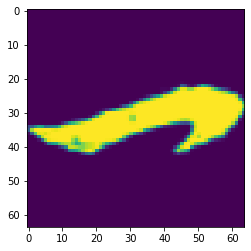

Dataframe Index:  339
Class Index:  0.0


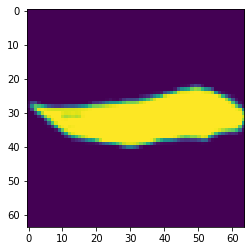

Dataframe Index:  340
Class Index:  0.0


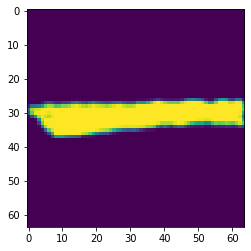

Dataframe Index:  341
Class Index:  0.0


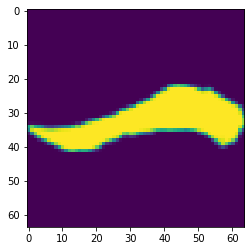

Dataframe Index:  342
Class Index:  0.0


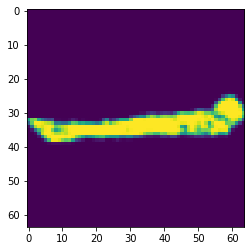

Dataframe Index:  343
Class Index:  0.0


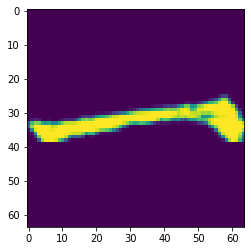

Dataframe Index:  344
Class Index:  0.0


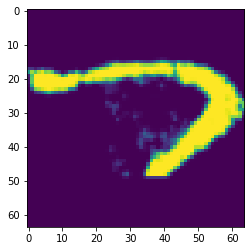

Dataframe Index:  345
Class Index:  0.0


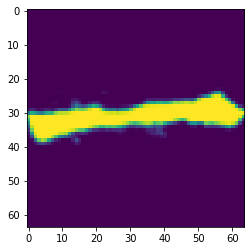

Dataframe Index:  346
Class Index:  0.0


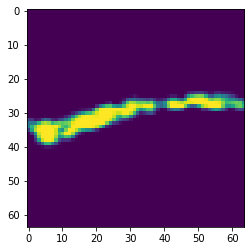

Dataframe Index:  347
Class Index:  0.0


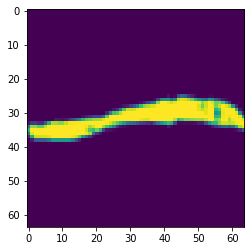

Dataframe Index:  348
Class Index:  0.0


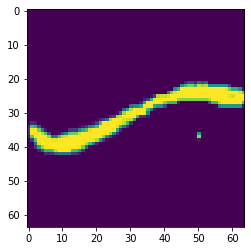

Dataframe Index:  349
Class Index:  0.0


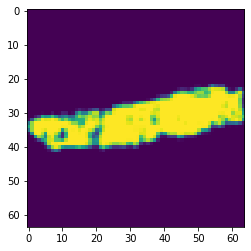

Dataframe Index:  350
Class Index:  0.0


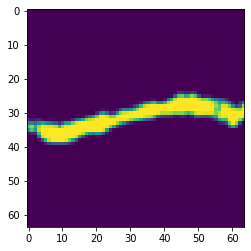

Dataframe Index:  351
Class Index:  0.0


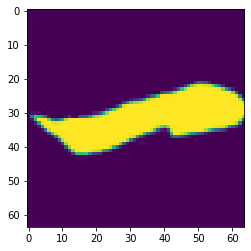

Dataframe Index:  352
Class Index:  0.0


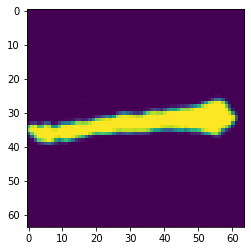

Dataframe Index:  353
Class Index:  0.0


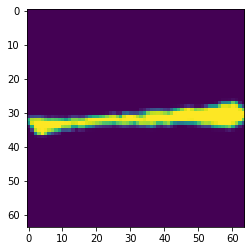

Dataframe Index:  354
Class Index:  0.0


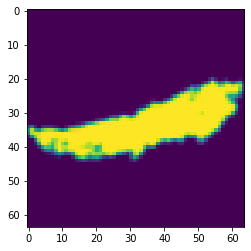

Dataframe Index:  355
Class Index:  0.0


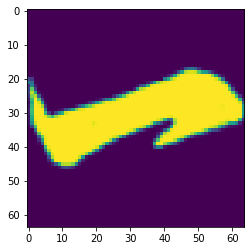

Dataframe Index:  356
Class Index:  0.0


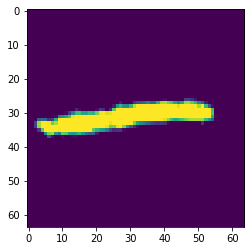

Dataframe Index:  357
Class Index:  0.0


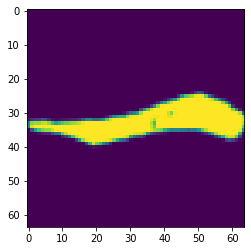

Dataframe Index:  358
Class Index:  0.0


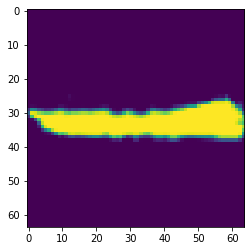

Dataframe Index:  359
Class Index:  0.0


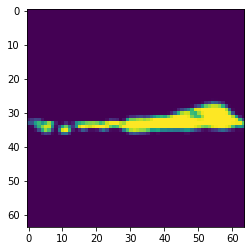

Dataframe Index:  360
Class Index:  0.0


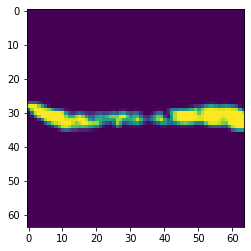

Dataframe Index:  361
Class Index:  0.0


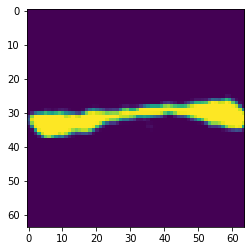

Dataframe Index:  362
Class Index:  0.0


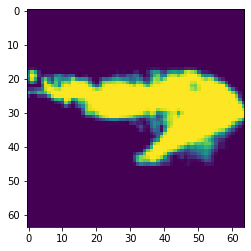

Dataframe Index:  363
Class Index:  0.0


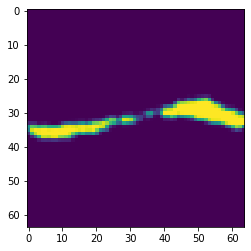

Dataframe Index:  364
Class Index:  0.0


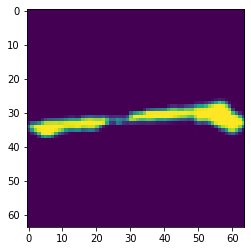

Dataframe Index:  365
Class Index:  0.0


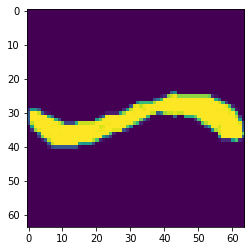

Dataframe Index:  366
Class Index:  0.0


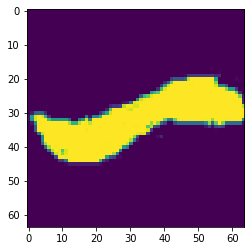

Dataframe Index:  367
Class Index:  0.0


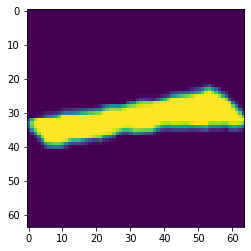

Dataframe Index:  368
Class Index:  0.0


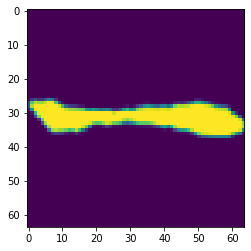

Dataframe Index:  369
Class Index:  0.0


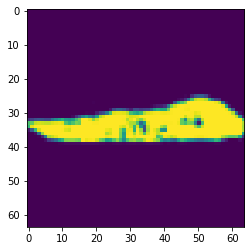

Dataframe Index:  370
Class Index:  0.0


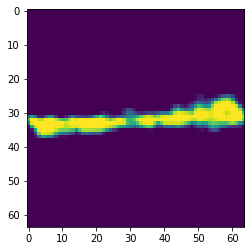

Dataframe Index:  371
Class Index:  0.0


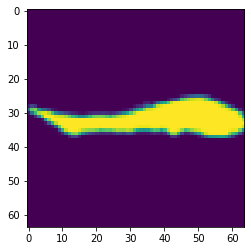

Dataframe Index:  372
Class Index:  0.0


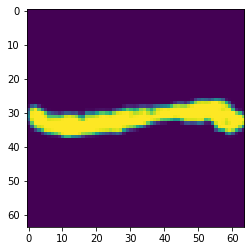

Dataframe Index:  373
Class Index:  0.0


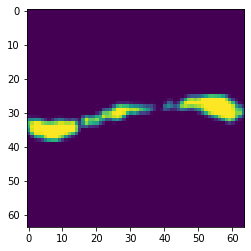

Dataframe Index:  374
Class Index:  0.0


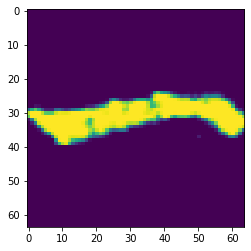

Dataframe Index:  375
Class Index:  0.0


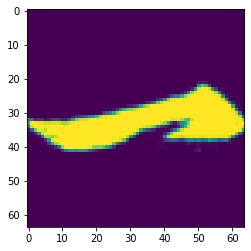

Dataframe Index:  376
Class Index:  0.0


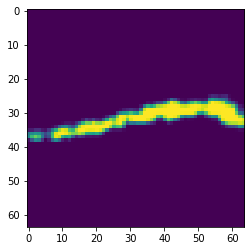

Dataframe Index:  377
Class Index:  0.0


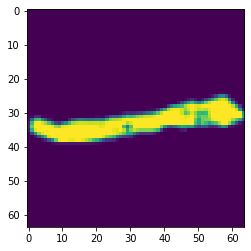

Dataframe Index:  378
Class Index:  0.0


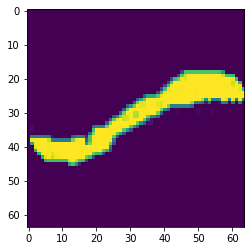

Dataframe Index:  379
Class Index:  0.0


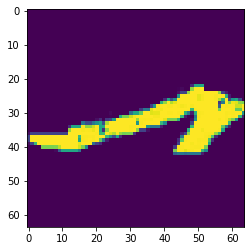

Dataframe Index:  380
Class Index:  0.0


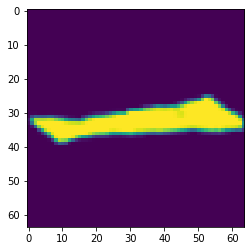

Dataframe Index:  381
Class Index:  0.0


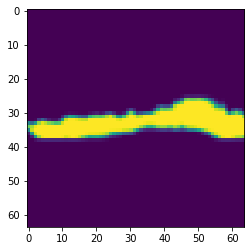

Dataframe Index:  382
Class Index:  0.0


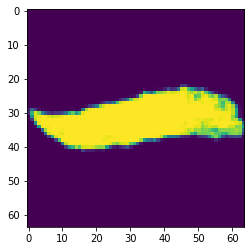

Dataframe Index:  383
Class Index:  0.0


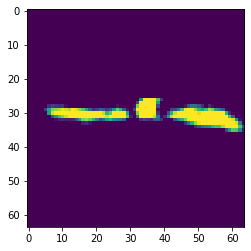

Dataframe Index:  384
Class Index:  0.0


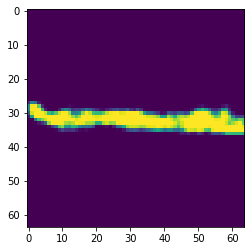

Dataframe Index:  385
Class Index:  0.0


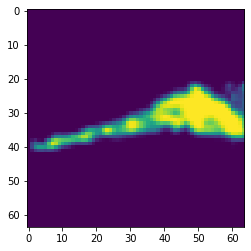

Dataframe Index:  386
Class Index:  0.0


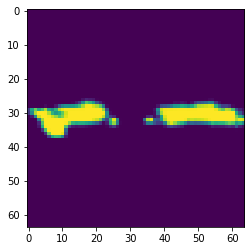

Dataframe Index:  387
Class Index:  0.0


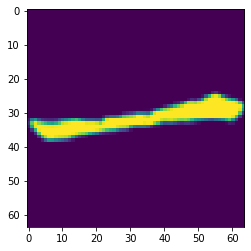

Dataframe Index:  388
Class Index:  0.0


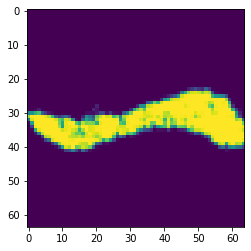

Dataframe Index:  389
Class Index:  0.0


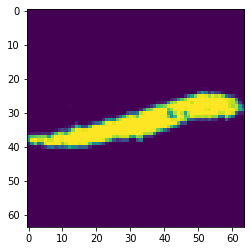

Dataframe Index:  390
Class Index:  0.0


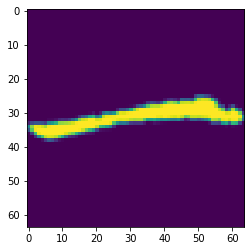

Dataframe Index:  391
Class Index:  0.0


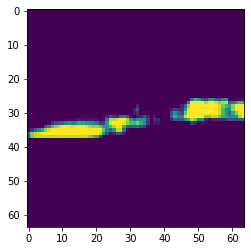

Dataframe Index:  392
Class Index:  0.0


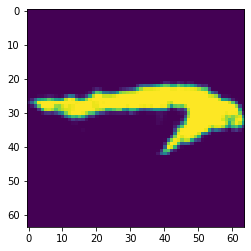

Dataframe Index:  393
Class Index:  0.0


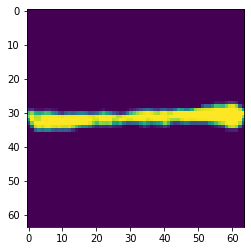

Dataframe Index:  394
Class Index:  0.0


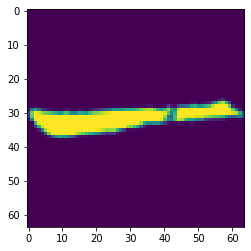

Dataframe Index:  395
Class Index:  0.0


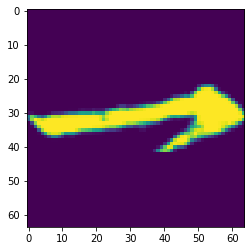

Dataframe Index:  396
Class Index:  0.0


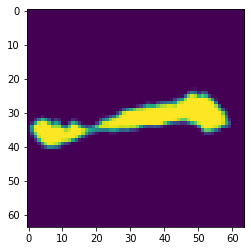

Dataframe Index:  397
Class Index:  0.0


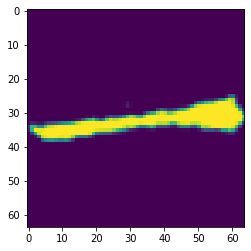

Dataframe Index:  398
Class Index:  0.0


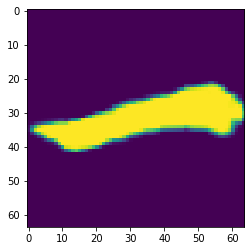

Dataframe Index:  399
Class Index:  0.0


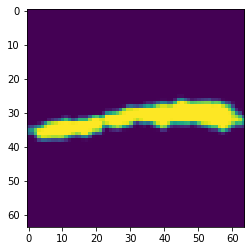

Dataframe Index:  400
Class Index:  0.0


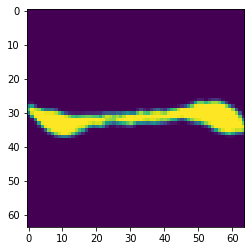

Dataframe Index:  401
Class Index:  0.0


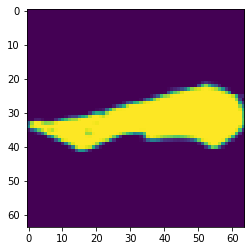

Dataframe Index:  402
Class Index:  0.0


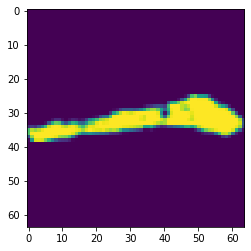

Dataframe Index:  403
Class Index:  0.0


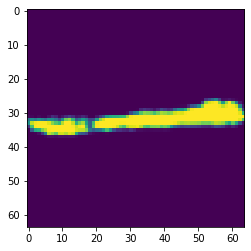

Dataframe Index:  404
Class Index:  0.0


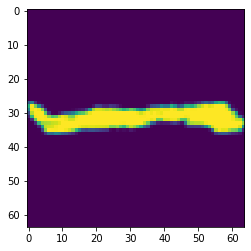

Dataframe Index:  405
Class Index:  0.0


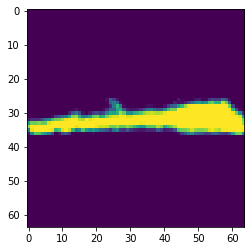

Dataframe Index:  406
Class Index:  0.0


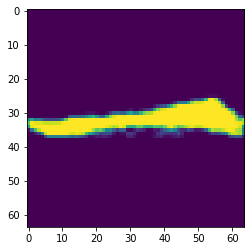

Dataframe Index:  407
Class Index:  0.0


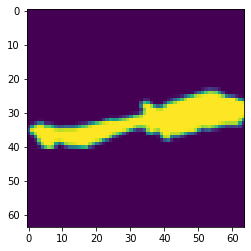

Dataframe Index:  408
Class Index:  0.0


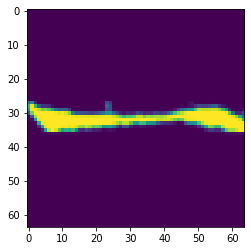

Dataframe Index:  409
Class Index:  0.0


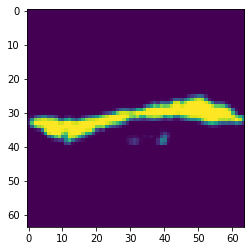

Dataframe Index:  410
Class Index:  0.0


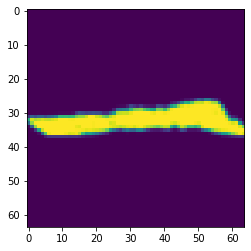

Dataframe Index:  411
Class Index:  0.0


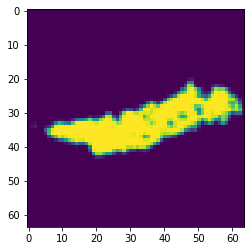

Dataframe Index:  412
Class Index:  0.0


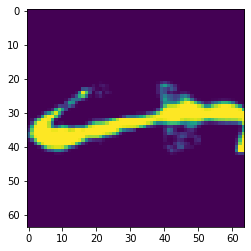

Dataframe Index:  413
Class Index:  0.0


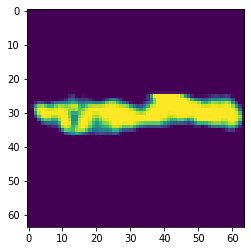

Dataframe Index:  414
Class Index:  0.0


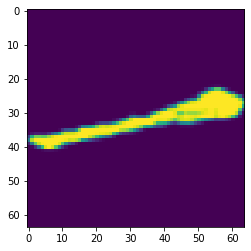

Dataframe Index:  415
Class Index:  0.0


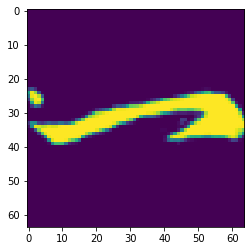

Dataframe Index:  416
Class Index:  0.0


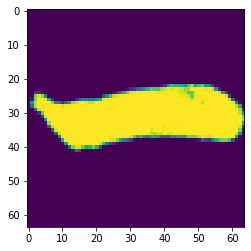

Dataframe Index:  417
Class Index:  0.0


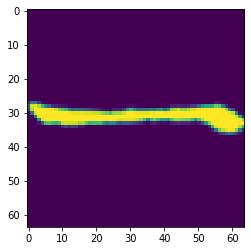

Dataframe Index:  418
Class Index:  0.0


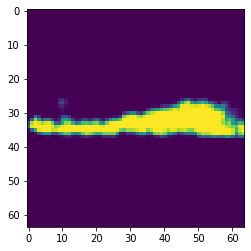

Dataframe Index:  419
Class Index:  0.0


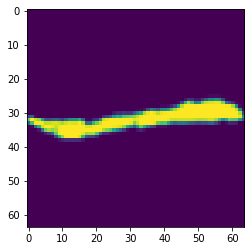

Dataframe Index:  420
Class Index:  0.0


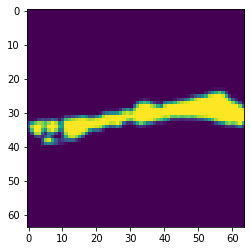

Dataframe Index:  421
Class Index:  0.0


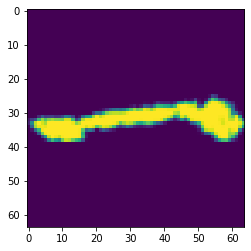

Dataframe Index:  422
Class Index:  0.0


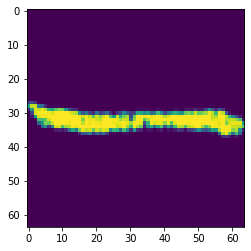

Dataframe Index:  423
Class Index:  0.0


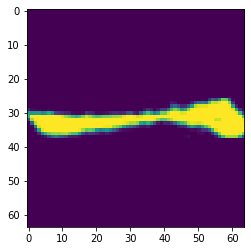

Dataframe Index:  424
Class Index:  0.0


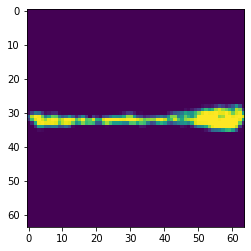

Dataframe Index:  425
Class Index:  0.0


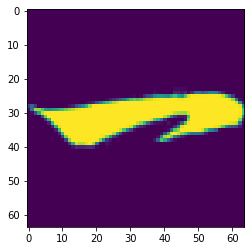

Dataframe Index:  426
Class Index:  0.0


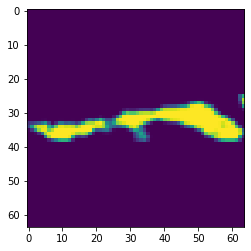

Dataframe Index:  427
Class Index:  0.0


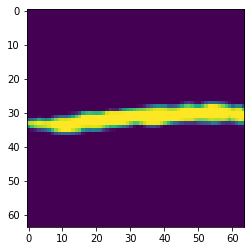

Dataframe Index:  428
Class Index:  0.0


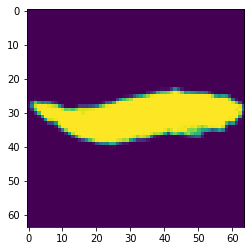

Dataframe Index:  429
Class Index:  0.0


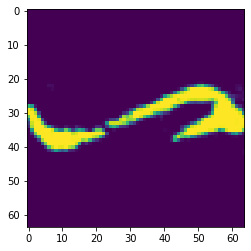

Dataframe Index:  430
Class Index:  0.0


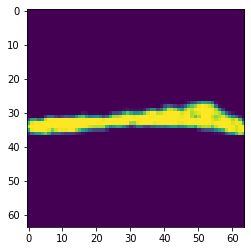

Dataframe Index:  431
Class Index:  0.0


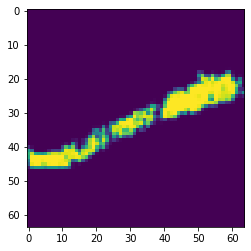

Dataframe Index:  432
Class Index:  0.0


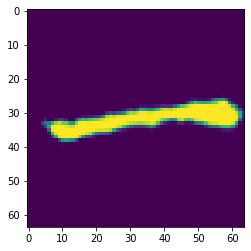

Dataframe Index:  433
Class Index:  0.0


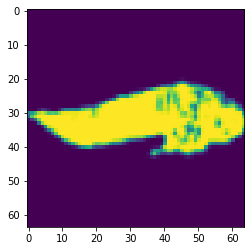

Dataframe Index:  434
Class Index:  0.0


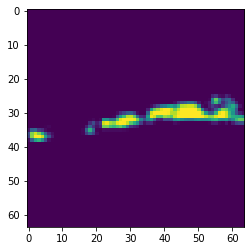

Dataframe Index:  435
Class Index:  0.0


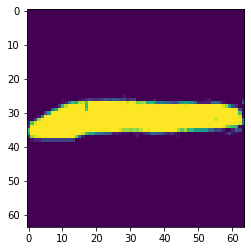

Dataframe Index:  436
Class Index:  0.0


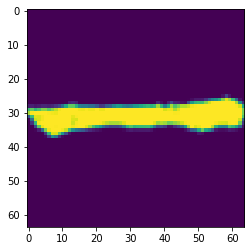

Dataframe Index:  437
Class Index:  0.0


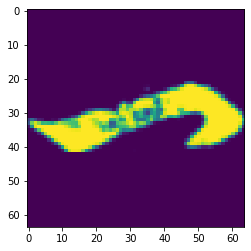

Dataframe Index:  438
Class Index:  0.0


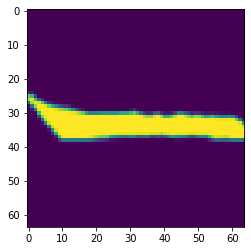

Dataframe Index:  439
Class Index:  0.0


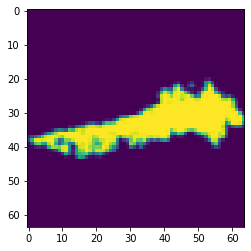

Dataframe Index:  440
Class Index:  0.0


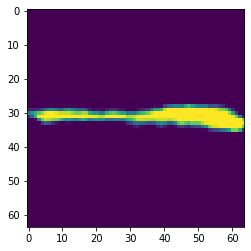

Dataframe Index:  441
Class Index:  0.0


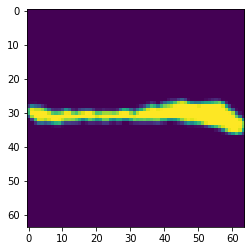

Dataframe Index:  442
Class Index:  0.0


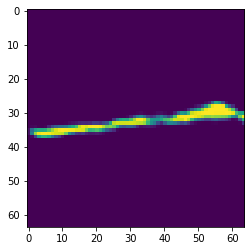

Dataframe Index:  443
Class Index:  0.0


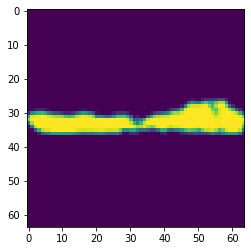

Dataframe Index:  444
Class Index:  0.0


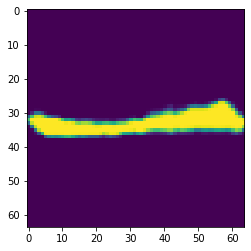

Dataframe Index:  445
Class Index:  0.0


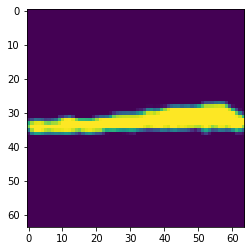

Dataframe Index:  446
Class Index:  0.0


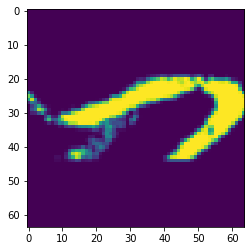

Dataframe Index:  447
Class Index:  0.0


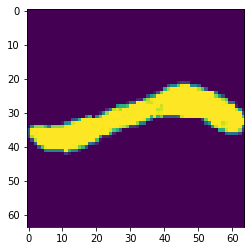

Dataframe Index:  448
Class Index:  0.0


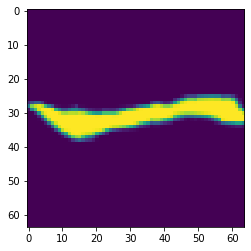

Dataframe Index:  449
Class Index:  0.0


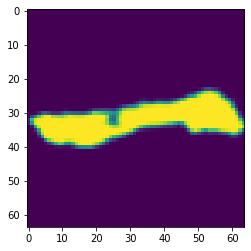

Dataframe Index:  450
Class Index:  0.0


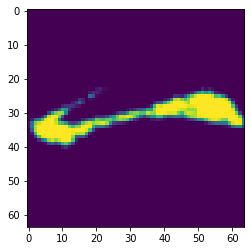

Dataframe Index:  451
Class Index:  0.0


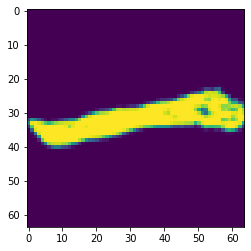

Dataframe Index:  452
Class Index:  0.0


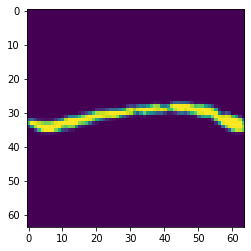

Dataframe Index:  453
Class Index:  0.0


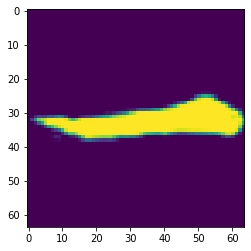

Dataframe Index:  454
Class Index:  0.0


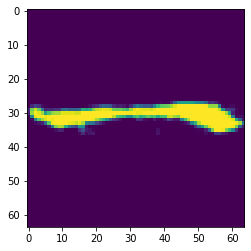

Dataframe Index:  455
Class Index:  0.0


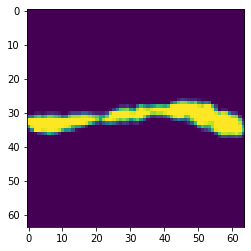

Dataframe Index:  456
Class Index:  0.0


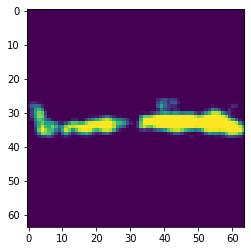

Dataframe Index:  457
Class Index:  0.0


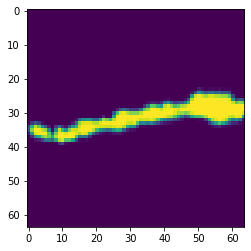

Dataframe Index:  458
Class Index:  0.0


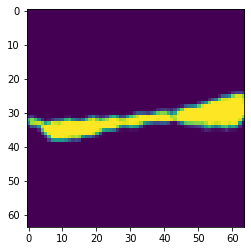

Dataframe Index:  459
Class Index:  0.0


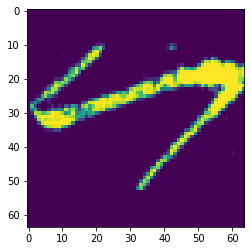

Dataframe Index:  460
Class Index:  0.0


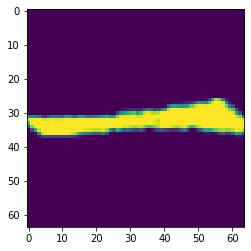

Dataframe Index:  461
Class Index:  0.0


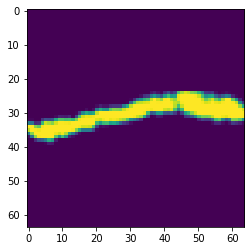

Dataframe Index:  462
Class Index:  0.0


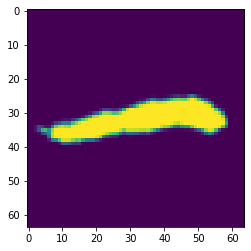

Dataframe Index:  463
Class Index:  0.0


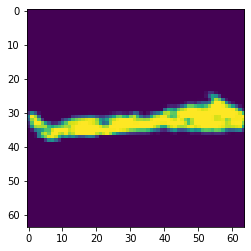

Dataframe Index:  464
Class Index:  0.0


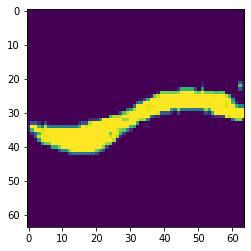

Dataframe Index:  465
Class Index:  0.0


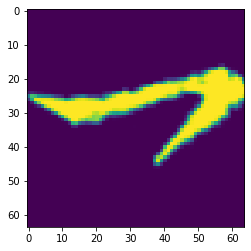

Dataframe Index:  466
Class Index:  0.0


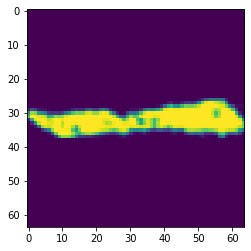

Dataframe Index:  467
Class Index:  0.0


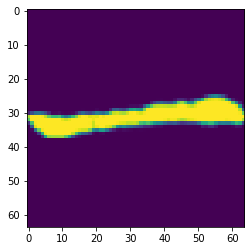

Dataframe Index:  468
Class Index:  0.0


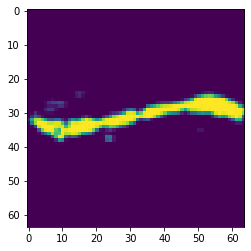

Dataframe Index:  469
Class Index:  0.0


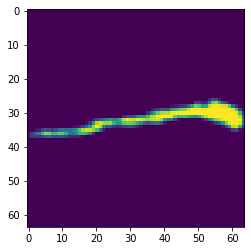

Dataframe Index:  470
Class Index:  0.0


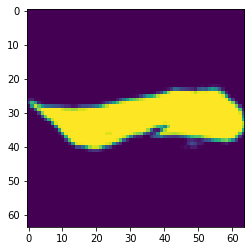

Dataframe Index:  471
Class Index:  0.0


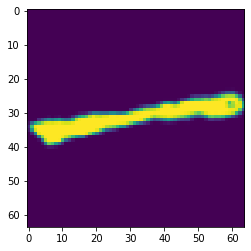

Dataframe Index:  472
Class Index:  0.0


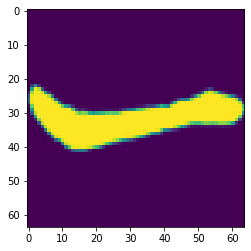

Dataframe Index:  473
Class Index:  0.0


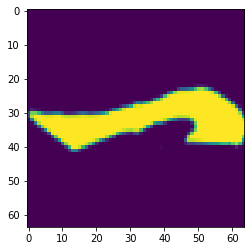

Dataframe Index:  474
Class Index:  0.0


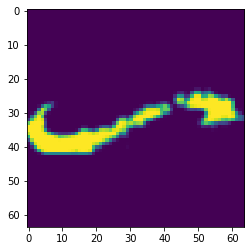

Dataframe Index:  475
Class Index:  0.0


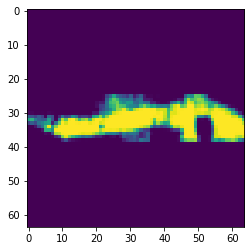

Dataframe Index:  476
Class Index:  0.0


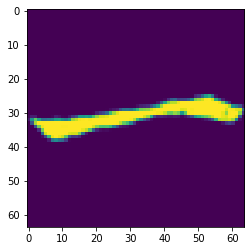

Dataframe Index:  477
Class Index:  0.0


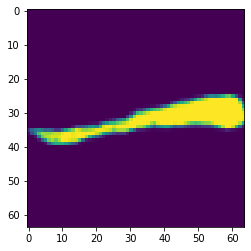

Dataframe Index:  478
Class Index:  0.0


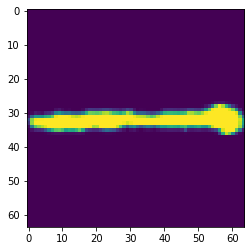

Dataframe Index:  479
Class Index:  0.0


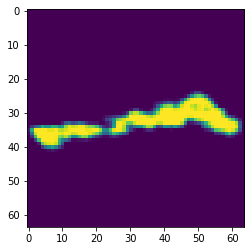

Dataframe Index:  480
Class Index:  0.0


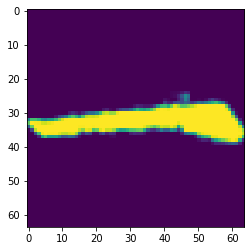

Dataframe Index:  481
Class Index:  0.0


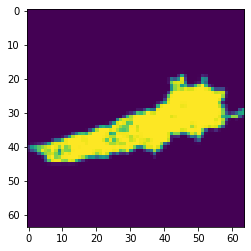

Dataframe Index:  482
Class Index:  0.0


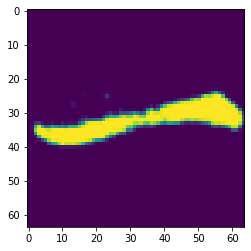

Dataframe Index:  483
Class Index:  0.0


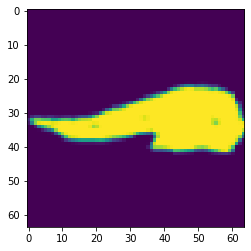

Dataframe Index:  484
Class Index:  0.0


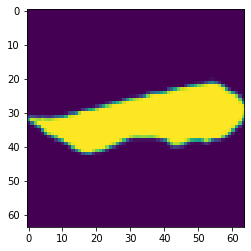

Dataframe Index:  485
Class Index:  0.0


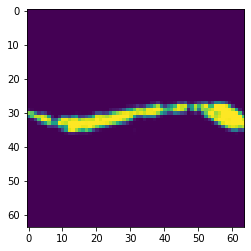

Dataframe Index:  486
Class Index:  0.0


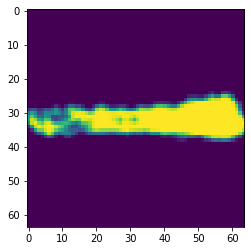

Dataframe Index:  487
Class Index:  0.0


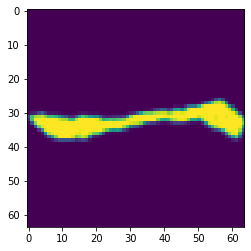

Dataframe Index:  488
Class Index:  0.0


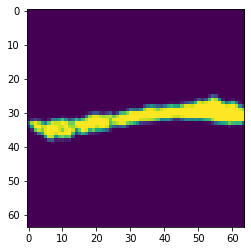

Dataframe Index:  489
Class Index:  0.0


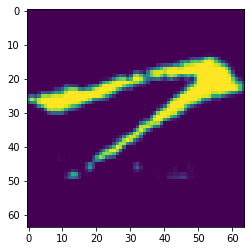

Dataframe Index:  490
Class Index:  0.0


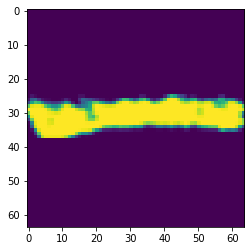

Dataframe Index:  491
Class Index:  0.0


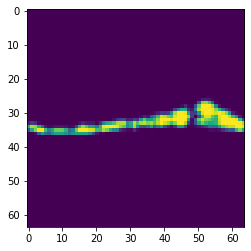

Dataframe Index:  492
Class Index:  0.0


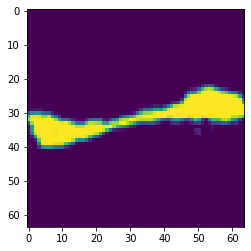

Dataframe Index:  493
Class Index:  0.0


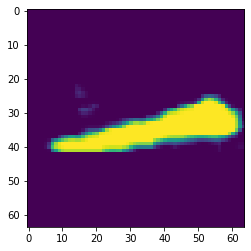

Dataframe Index:  494
Class Index:  0.0


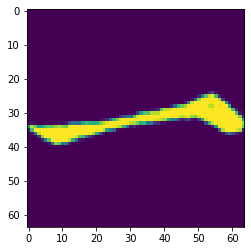

Dataframe Index:  495
Class Index:  0.0


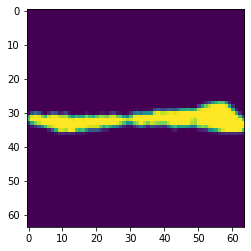

Dataframe Index:  496
Class Index:  0.0


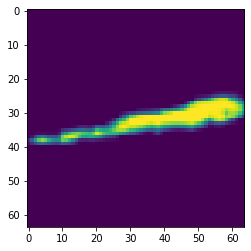

Dataframe Index:  497
Class Index:  0.0


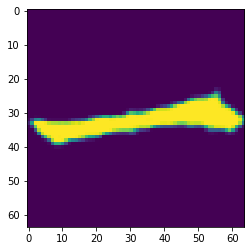

Dataframe Index:  498
Class Index:  0.0


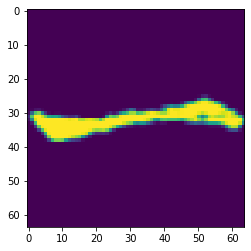

In [93]:
# walk through the dataframe and display an image and the
# image's class Index

for i in range(0,499):
    print('Dataframe Index: ', i)
    print('Class Index: ', df_kanji2['classIndex'][i])
    imag = image.imread(df_kanji2['image_file_path'][i])
    plt.figure()
    plt.imshow(imag)
    plt.show()
    
    i+=1

In [94]:
# so in our exploration of the 3rd dataset, we can see
# that the data set contains more complex images and 
# that they are larger, and also that this 3rd dataset
# is also an unbalanced dataset i.e. there are not
# the same numbers of each class.

[end]